# Frozenlake RL Agents


--- Training DDQN Agent with Shaped Rewards (Deterministic Environment) ---


Training DDQN Agent: 100%|██████████| 10000/10000 [02:31<00:00, 66.20it/s]


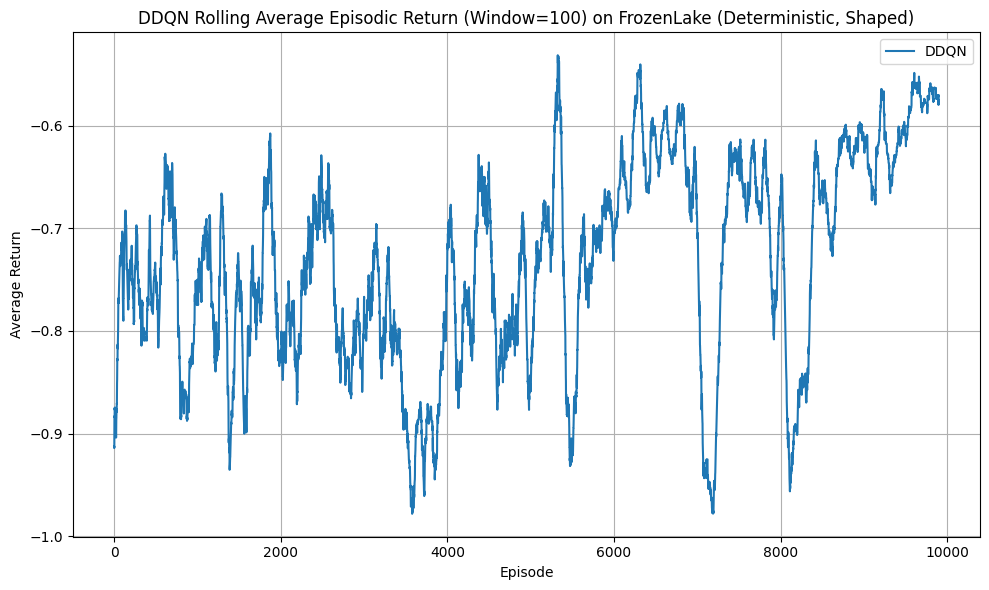


DDQN Results (Deterministic, Shaped):
  Variance: 0.1347, Sample Efficiency (90% peak avg): -1 episodes, Time/Episode: 0.0151s, Success Rate: 0.00%

--- Training Classical TD and Monte Carlo Agents on Slippery FrozenLake ---


MC First Visit: 100%|██████████| 5000/5000 [00:05<00:00, 945.21it/s] 



MC First Visit Results (Slippery, Original Rewards):
  Variance: 0.0000, Sample Efficiency (90% peak avg): 0 episodes, Time/Episode: 0.0011s, Success Rate: 0.00%


MC Every Visit: 100%|██████████| 5000/5000 [03:11<00:00, 26.13it/s]



MC Every Visit Results (Slippery, Original Rewards):
  Variance: 0.0000, Sample Efficiency (90% peak avg): 0 episodes, Time/Episode: 0.0382s, Success Rate: 0.00%


TD(0) Q-Learning: 100%|██████████| 5000/5000 [00:03<00:00, 1354.77it/s]



TD(0) Q-Learning Results (Slippery, Original Rewards):
  Variance: 0.0000, Sample Efficiency (90% peak avg): 0 episodes, Time/Episode: 0.0007s, Success Rate: 0.00%


TD(lambda) SARSA: 100%|██████████| 5000/5000 [03:53<00:00, 21.41it/s] 



TD(lambda) SARSA Results (Slippery, Original Rewards):
  Variance: 0.0000, Sample Efficiency (90% peak avg): 0 episodes, Time/Episode: 0.0467s, Success Rate: 0.00%


TD(lambda) Q-Learning: 100%|██████████| 5000/5000 [00:31<00:00, 158.51it/s]



TD(lambda) Q-Learning Results (Slippery, Original Rewards):
  Variance: 0.0000, Sample Efficiency (90% peak avg): 0 episodes, Time/Episode: 0.0063s, Success Rate: 0.00%


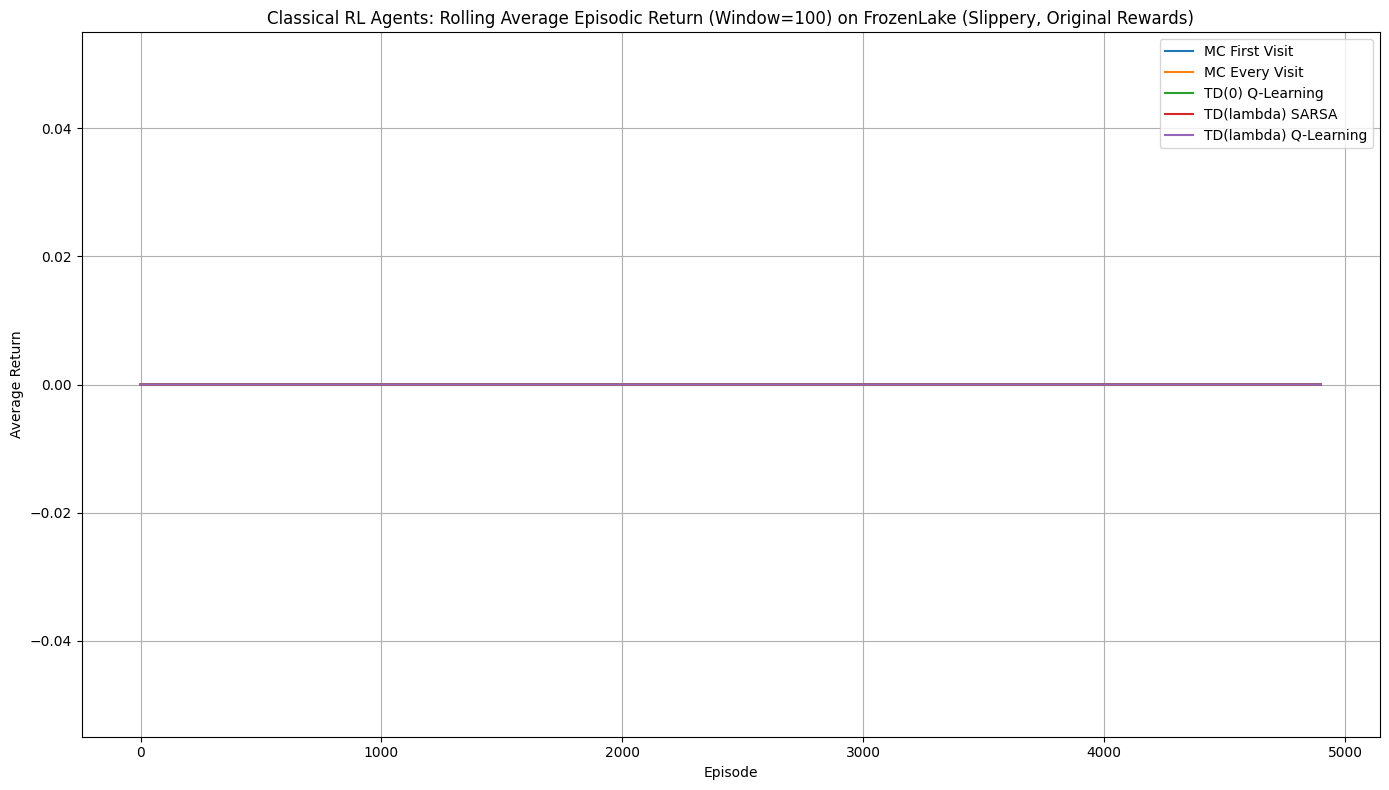

In [2]:
# === MERGED FROZENLAKE RL AGENTS: CLASSICAL & DDQN ===

# --- Standard Library Imports ---
import time
import random
from collections import defaultdict

# --- Third-Party Library Imports ---
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

# ==============================================================================
# === HELPER FUNCTIONS ===
# ==============================================================================

def plot_metric(metric_values, label, window=100):
    """
    Plots the rolling average of a given metric over episodes.

    Args:
        metric_values (list or np.array): List of metric values per episode (e.g., rewards).
        label (str): Label for the plot line.
        window (int): The size of the rolling window for averaging.
    """
    if len(metric_values) < window:
        print(f"Warning: Not enough data points ({len(metric_values)}) for a window of {window}. Plotting raw values.")
        plt.plot(metric_values, label=label)
        return

    # Calculate the rolling average using convolution.
    # np.ones(window)/window creates a kernel for averaging.
    # mode='valid' ensures that the output has a size that doesn't include partial windows.
    rolling_avg = np.convolve(metric_values, np.ones(window)/window, mode='valid')
    plt.plot(rolling_avg, label=label)

def evaluate_agent(rewards, times, successes):
    """
    Evaluates the performance of an RL agent based on collected rewards, times, and successes.

    Args:
        rewards (list): A list of total rewards obtained in each episode.
        times (list): A list of times taken for each episode.
        successes (list): A list of boolean values indicating success (True) or failure (False) for each episode.

    Returns:
        tuple: A tuple containing:
            - variance (float): Variance of the rewards.
            - sample_eff (int): Sample efficiency (episode number to reach 90% of max rolling avg).
            - avg_time (float): Average time taken per episode.
            - success_rate (float): Overall success rate (proportion of successful episodes).
    """
    rewards_np = np.array(rewards)
    successes_np = np.array(successes)
    
    if len(rewards_np) < 100: # Need at least 100 episodes for rolling average
        # Handle cases with too few episodes for meaningful rolling avg calculation
        variance = np.var(rewards_np) if len(rewards_np) > 1 else 0.0
        sample_eff = -1 # Cannot determine
        max_avg = np.mean(rewards_np) # Use mean of all rewards
    else:
        variance = np.var(rewards_np)  # Calculate the variance of episode rewards.
        # Calculate the rolling average of rewards to find the maximum average.
        rolling_avg = np.convolve(rewards_np, np.ones(100)/100, mode='valid')
        max_avg = np.max(rolling_avg)
        
        # Find the first episode index where the rolling average reaches at least 90% of the maximum average.
        # This serves as a proxy for sample efficiency. Returns -1 if not found.
        sample_eff = next((i for i, avg in enumerate(rolling_avg) if avg >= 0.9 * max_avg), -1)

    avg_time = np.mean(times) if len(times) > 0 else 0.0  # Calculate the average time per episode.
    success_rate = np.mean(successes_np) if len(successes_np) > 0 else 0.0
    return variance, sample_eff, avg_time, success_rate

# ==============================================================================
# === ENVIRONMENT WRAPPERS ===
# ==============================================================================

class ShapedFrozenLakeWrapper(gym.Wrapper):
    """
    A custom Gymnasium wrapper for the FrozenLake environment that modifies the reward structure.
    It introduces shaped rewards to guide the agent's learning process,
    penalizing steps and falls into holes, and rewarding reaching the goal.
    """
    def __init__(self, env):
        """
        Initializes the wrapper with the base environment.

        Args:
            env (gym.Env): The base FrozenLake environment.
        """
        super().__init__(env)

    def step(self, action):
        """
        Performs a step in the environment and applies reward shaping.

        Args:
            action (int): The action taken by the agent.

        Returns:
            tuple: (obs, shaped_reward, terminated, truncated, info)
                   - obs (object): The new observation of the environment.
                   - shaped_reward (float): The modified reward.
                   - terminated (bool): Whether the episode has ended due to termination.
                   - truncated (bool): Whether the episode has ended due to truncation.
                   - info (dict): Additional information from the environment.
        """
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Start with a small negative reward per step to encourage shorter paths
        shaped_reward = -0.01
        
        # Get the current tile type to determine specific reward shaping
        # This assumes a FrozenLake environment with `unwrapped.desc` and `unwrapped.s`
        try:
            desc = self.unwrapped.desc.tolist()
            row, col = self.unwrapped.s // self.unwrapped.ncol, self.unwrapped.s % self.unwrapped.ncol
            current_tile = desc[row][col].decode("utf-8")
        except AttributeError:
            # Fallback for environments that might not have these attributes or if unwrapped fails
            current_tile = '' # Cannot determine tile type without specific env attributes

        # Check what happened at the end of the episode
        if terminated:
            if reward == 1.0: # Original environment's goal reward
                shaped_reward = 1.0  # High reward for reaching the goal
            elif current_tile == 'H':
                shaped_reward = -0.5  # Significant penalty for falling in a hole
            elif 'is_success' in info and not info['is_success']:
                # Generic check for failure in terminated state if no 'H'
                shaped_reward = -0.5 # General penalty for failing to reach goal when terminated
        # else: shaped_reward remains -0.01 per step

        return obs, shaped_reward, terminated, truncated, info

# ==============================================================================
# === CLASSICAL TABULAR RL AGENTS ===
# ==============================================================================

def mc_first_visit(env, episodes=5000, gamma=0.99, epsilon=0.1):
    """
    Implements the Monte Carlo First-Visit Control algorithm.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    # Q-table to store state-action values. Initialized to zeros.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # Stores all returns for each state-action pair to calculate averages.
    returns = defaultdict(list)
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    for _ in tqdm(range(episodes), desc="MC First Visit"):
        start = time.time()
        state, info = env.reset()  # Reset environment for a new episode.
        episode = []  # To store (state, action, reward) tuples for the current episode.
        done = False
        
        episode_success = False # Track success for current episode

        # Generate an episode
        while not done:
            # Epsilon-greedy policy to choose an action.
            # Explore (random action) with probability epsilon, exploit (greedy action) otherwise.
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, info = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            done = terminated or truncated
            if terminated and info.get('is_success', False):
                episode_success = True

        G = 0  # Initialize return G.
        visited = set()  # To keep track of (state, action) pairs visited in this episode.
        
        # Iterate through the episode in reverse to calculate returns and update Q-values.
        for s, a, r in reversed(episode):
            G = gamma * G + r  # Calculate discounted return.
            if (s, a) not in visited:  # Only update for the first visit of (s, a) in the episode.
                visited.add((s, a))
                returns[(s, a)].append(G)  # Add the return to the list for this (s, a) pair.
                Q[s][a] = np.mean(returns[(s, a)])  # Update Q-value as the average of observed returns.

        rewards_per_episode.append(sum([x[2] for x in episode]))  # Sum of rewards for the episode.
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

def mc_every_visit(env, episodes=5000, gamma=0.99, epsilon=0.1):
    """
    Implements the Monte Carlo Every-Visit Control algorithm.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = defaultdict(list)
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    for _ in tqdm(range(episodes), desc="MC Every Visit"):
        start = time.time()
        state, info = env.reset()
        episode = []
        done = False
        episode_success = False

        # Generate an episode
        while not done:
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, info = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            done = terminated or truncated
            if terminated and info.get('is_success', False):
                episode_success = True

        G = 0
        # Iterate through the episode in reverse.
        for i in reversed(range(len(episode))):
            s, a, r = episode[i]
            G = gamma * G + r  # Calculate discounted return.
            returns[(s, a)].append(G)  # Add the return for *every* visit of (s, a).
            Q[s][a] = np.mean(returns[(s, a)])  # Update Q-value as the average of all observed returns.

        rewards_per_episode.append(sum([x[2] for x in episode]))
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

def td0_q_learning(env, episodes=5000, gamma=0.99, alpha=0.1, epsilon=0.1):
    """
    Implements the TD(0) Q-Learning algorithm.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        alpha (float): Learning rate.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    for _ in tqdm(range(episodes), desc="TD(0) Q-Learning"):
        start = time.time()
        state, info = env.reset()
        total_reward = 0
        done = False
        episode_success = False

        while not done:
            # Choose action using epsilon-greedy policy.
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, info = env.step(action)
            
            # Q-learning is off-policy: it uses the greedy action for the next state's Q-value.
            # Max Q-value for next_state to estimate future return
            max_q_next = np.max(Q[next_state]) 
            
            # Q-value update rule: Q(s,a) = Q(s,a) + alpha * [reward + gamma * max_a' Q(s',a') - Q(s,a)]
            Q[state][action] += alpha * (reward + gamma * max_q_next - Q[state][action])
            
            state = next_state
            total_reward += reward
            done = terminated or truncated
            if terminated and info.get('is_success', False):
                episode_success = True

        rewards_per_episode.append(total_reward)
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

def td_lambda_sarsa(env, episodes=5000, gamma=0.99, alpha=0.1, lam=0.9, epsilon=0.1):
    """
    Implements the TD(lambda) SARSA algorithm with eligibility traces.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        alpha (float): Learning rate.
        lam (float): Lambda parameter for eligibility traces.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    for _ in tqdm(range(episodes), desc="TD(lambda) SARSA"):
        start = time.time()
        state, info = env.reset()
        # Choose initial action using epsilon-greedy policy.
        action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
        
        # Eligibility traces for (state, action) pairs.
        # Initialized to zero at the start of each episode.
        E = defaultdict(lambda: np.zeros(env.action_space.n))  
        total_reward = 0
        done = False
        episode_success = False

        while not done:
            next_state, reward, terminated, truncated, info = env.step(action)
            # Choose next action using epsilon-greedy policy. This makes SARSA on-policy.
            next_action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[next_state])
            
            # TD Error: reward + gamma * Q(s',a') - Q(s,a)
            delta = reward + gamma * Q[next_state][next_action] - Q[state][action]
            
            # Increment eligibility trace for the current state-action pair.
            E[state][action] += 1
            
            # Update Q-values and eligibility traces for all visited state-action pairs.
            # Iterate through all known states in Q (states that have been visited).
            for s in Q:
                for a in range(env.action_space.n):
                    Q[s][a] += alpha * delta * E[s][a]
                    E[s][a] *= gamma * lam  # Decay eligibility trace.
            
            state = next_state
            action = next_action
            total_reward += reward
            done = terminated or truncated
            if terminated and info.get('is_success', False):
                episode_success = True

        rewards_per_episode.append(total_reward)
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

def td_lambda_q_learning(env, episodes=5000, gamma=0.99, alpha=0.1, lam=0.9, epsilon=0.1):
    """
    Implements the TD(lambda) Q-Learning algorithm with eligibility traces.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        alpha (float): Learning rate.
        lam (float): Lambda parameter for eligibility traces.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    for _ in tqdm(range(episodes), desc="TD(lambda) Q-Learning"):
        start = time.time()
        state, info = env.reset()
        # Eligibility traces for (state, action) pairs.
        E = defaultdict(lambda: np.zeros(env.action_space.n))  
        total_reward = 0
        done = False
        episode_success = False

        while not done:
            # Choose action using epsilon-greedy policy.
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, info = env.step(action)
            
            # Q-learning is off-policy: it uses the greedy action for the next state's Q-value.
            # Max Q-value for next_state to estimate future return
            max_q_next = np.max(Q[next_state]) 
            
            # TD Error: reward + gamma * max_a' Q(s',a') - Q(s,a)
            delta = reward + gamma * max_q_next - Q[state][action]
            
            # Increment eligibility trace for the current state-action pair.
            E[state][action] += 1
            
            # Update Q-values and eligibility traces for all visited state-action pairs.
            for s in Q: # Iterate through all known states in Q
                for a in range(env.action_space.n):
                    Q[s][a] += alpha * delta * E[s][a]
                    E[s][a] *= gamma * lam  # Decay eligibility trace.
            
            state = next_state
            total_reward += reward
            done = terminated or truncated
            if terminated and info.get('is_success', False):
                episode_success = True

        rewards_per_episode.append(total_reward)
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

# ==============================================================================
# === DEEP REINFORCEMENT LEARNING AGENTS (DDQN) ===
# ==============================================================================

class DDQN(nn.Module):
    """
    The Deep Q-Network (DQN) architecture.
    It's a simple feed-forward neural network that takes a state as input
    and outputs Q-values for each possible action.
    """
    def __init__(self, state_dim, action_dim):
        """
        Initializes the DDQN neural network.

        Args:
            state_dim (int): The dimension of the input state.
            action_dim (int): The number of possible actions (output dimension).
        """
        super().__init__()
        # Define a sequential neural network with one hidden layer.
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),  # Input layer to hidden layer
            nn.ReLU(),                 # ReLU activation function
            nn.Linear(64, action_dim)  # Hidden layer to output layer (Q-values for each action)
        )

    def forward(self, x):
        """
        Performs a forward pass through the network.

        Args:
            x (torch.Tensor): The input state tensor.

        Returns:
            torch.Tensor: The output Q-values for each action.
        """
        return self.net(x)

class DDQNAgent:
    """
    Implements a Double Deep Q-Network (DDQN) agent.
    DDQN uses two neural networks (Q-network and Target network) to stabilize training,
    and incorporates experience replay and epsilon-greedy exploration.
    """
    def __init__(self, env, gamma=0.99, lr=1e-3, memory_capacity=10000, batch_size=32, update_freq=50):
        """
        Initializes the DDQN Agent.

        Args:
            env (gym.Env): The environment the agent will interact with.
            gamma (float): Discount factor for future rewards.
            lr (float): Learning rate for the optimizer.
            memory_capacity (int): Maximum size of the experience replay memory.
            batch_size (int): Number of transitions to sample for each learning step.
            update_freq (int): How often to update the target network (every 'update_freq' learning steps).
        """
        self.env = env
        self.gamma = gamma
        self.epsilon = 1.0  # Initial exploration rate
        self.epsilon_decay = 0.9995  # Rate at which epsilon decays
        self.epsilon_min = 0.05     # Minimum exploration rate
        
        # Determine the device (CPU or GPU) for PyTorch operations
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Assuming a discrete state space where state can be directly used as input.
        # For FrozenLake (integers 0-63), we will treat it as a single scalar input.
        state_dim = 1 
        action_dim = env.action_space.n

        # Main Q-network: used for action selection and learning
        self.q_net = DDQN(state_dim, action_dim).to(self.device)
        # Target Q-network: a copy of the Q-network used to compute target Q-values
        # This helps stabilize training by providing a fixed target for some time.
        self.target_net = DDQN(state_dim, action_dim).to(self.device)
        # Initialize target network with the same weights as the main Q-network
        self.target_net.load_state_dict(self.q_net.state_dict())

        # Optimizer for updating Q-network weights
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        # Loss function for computing the difference between predicted and target Q-values
        self.criteria = nn.MSELoss() # Mean Squared Error Loss

        # Experience replay buffer: stores (state, action, reward, next_state, done) transitions
        self.memory = []
        self.memory_capacity = memory_capacity
        self.batch_size = batch_size
        self.update_freq = update_freq
        self.learn_step = 0   # Counter for learning steps

    def act(self, state):
        """
        Selects an action using an epsilon-greedy policy.

        Args:
            state (int): The current state observation (an integer in FrozenLake).

        Returns:
            int: The chosen action.
        """
        # Epsilon-greedy action selection:
        # With probability epsilon, choose a random action (exploration).
        # Otherwise, choose the action with the highest Q-value from the Q-network (exploitation).
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        
        # Convert state to a PyTorch tensor, reshape it for the network, and move to device.
        # .float() ensures it's a float32 tensor
        # .unsqueeze(0) adds a batch dimension (e.g., from scalar to [1])
        # .unsqueeze(0) again to make it [1, 1] for input to linear layer expecting [batch_size, state_dim]
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(self.device)
        
        # Disable gradient calculation for action selection (inference only).
        self.q_net.eval() # Set Q-network to evaluation mode (e.g., disables dropout)
        with torch.no_grad():
            # Get Q-values from the Q-network and select the action with the maximum Q-value.
            q_values = self.q_net(state_tensor)
        self.q_net.train() # Set Q-network back to training mode
        return torch.argmax(q_values).item()

    def remember(self, transition):
        """
        Stores a new transition in the experience replay memory.

        Args:
            transition (tuple): A tuple (state, action, reward, next_state, done).
        """
        self.memory.append(transition)
        # Limit the memory size to avoid excessive memory usage.
        if len(self.memory) > self.memory_capacity:
            self.memory.pop(0) # Remove the oldest transition if memory is full.

    def learn(self):
        """
        Performs one learning step using a batch of experiences from the replay memory.
        This involves computing the TD target, calculating the loss, and updating the Q-network.
        It also periodically updates the target network and decays epsilon.
        """
        # Do not learn if there aren't enough samples in memory for a full batch.
        if len(self.memory) < self.batch_size:
            return

        # Sample a random batch of transitions from the replay memory.
        batch = random.sample(self.memory, self.batch_size)
        # Unzip the batch into separate lists for states, actions, rewards, next_states, and dones.
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert lists of numpy arrays/ints to PyTorch tensors and move them to the device.
        # .float() for rewards, states, next_states. .long() for actions (for gather).
        # .unsqueeze(1) adds a dimension to match the output shape of the network (e.g., [batch_size, 1]).
        states = torch.tensor(states, dtype=torch.float32).unsqueeze(1).to(self.device)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).unsqueeze(1).to(self.device)
        # 'dones' indicates if a state is terminal, so its Q-value should be 0.
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)

        # Compute Q-values predicted by the main Q-network for the taken actions.
        # .gather(1, actions) selects the Q-value for the specific action taken in each state.
        q_values = self.q_net(states).gather(1, actions)
        
        # Compute the target Q-values for the Double DQN algorithm.
        # It uses the main Q-network to select the best action in the next state (maximizes Q).
        # Then, it uses the target network to evaluate the Q-value of that selected action.
        # The `max(1)[1]` returns the indices of the max values.
        # `q_net(next_states).max(1)[1].unsqueeze(1)` selects the best action for next_states
        # `target_net(next_states).gather(1, ...)` gets the Q-value of that action from the target net.
        next_state_actions = self.q_net(next_states).max(1)[1].unsqueeze(1) # Action chosen by Q-net for next state
        next_q_target = self.target_net(next_states).gather(1, next_state_actions).detach() # Q-value from target net

        # The Q-learning target: R + gamma * Q_target(S', argmax_a Q_main(S', a))
        # (1 - dones) handles terminal states: if done, the future reward term is zero.
        q_target = rewards + (1 - dones) * self.gamma * next_q_target

        # Calculate the Mean Squared Error loss between the predicted Q-values and the target Q-values.
        loss = self.criteria(q_values, q_target)
        
        # Zero the gradients, perform backpropagation, and update the Q-network weights.
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Periodically update the target network by copying the weights from the main Q-network.
        self.learn_step += 1
        if self.learn_step % self.update_freq == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

        # Decay epsilon to reduce exploration over time.
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# ==============================================================================
# === GENERAL TRAINING LOOP ===
# ==============================================================================

def train_agent(env, agent, episodes=5000):
    """
    General training loop for an RL agent. This function is designed to work
    with both tabular agents (which might have their own integrated training logic
    if passed directly) and DDQNAgent (which uses remember/learn methods).

    Args:
        env (gym.Env): The environment to train in.
        agent (callable or DDQNAgent): If callable (like MC/TD functions), it's called directly.
                                        If DDQNAgent, its act/remember/learn methods are used.
        episodes (int): The number of episodes to run for training.

    Returns:
        tuple: (rewards_per_episode, times_per_episode, successes_per_episode)
               - rewards_per_episode (list): A list of total rewards obtained in each episode.
               - times_per_episode (list): A list of times taken for each episode.
               - successes_per_episode (list): A list of boolean values indicating success for each episode.
    """
    if isinstance(agent, DDQNAgent):
        # Specific training logic for DDQNAgent (using its act/remember/learn methods)
        rewards_per_episode = [] 
        times_per_episode = []
        successes_per_episode = []
        for ep in tqdm(range(episodes), desc=f"Training DDQN Agent"):
            start_time = time.time()
            state, info = env.reset()
            total_reward = 0
            done = False
            episode_success = False

            while not done:
                action = agent.act(state)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

                agent.remember((state, action, reward, next_state, done))
                agent.learn() # DDQN agent learns from a batch.

                total_reward += reward
                state = next_state
                
                if terminated and info.get('is_success', False):
                    episode_success = True
            
            rewards_per_episode.append(total_reward)
            times_per_episode.append(time.time() - start_time)
            successes_per_episode.append(episode_success)
        return rewards_per_episode, times_per_episode, successes_per_episode

    else:
        # Assumes `agent` is a function (like mc_first_visit, td0_q_learning)
        # that encapsulates its own training loop and returns Q, rewards, times, successes.
        Q_table, rewards_per_episode, times_per_episode, successes_per_episode = agent(env, episodes=episodes)
        return rewards_per_episode, times_per_episode, successes_per_episode

# ==============================================================================
# === MAIN EXECUTION FOR ALL FROZENLAKE AGENTS ===
# ==============================================================================

if __name__ == "__main__":
    
    # --- Configuration for DDQN Agent ---
    plt.figure(figsize=(10, 6)) # New figure for DDQN
    print("\n--- Training DDQN Agent with Shaped Rewards (Deterministic Environment) ---")
    ddqn_env = ShapedFrozenLakeWrapper(gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode=None))
    ddqn_agent = DDQNAgent(ddqn_env, lr=5e-4, memory_capacity=20000, batch_size=64, update_freq=100) 
    ddqn_rewards, ddqn_times, ddqn_successes = train_agent(ddqn_env, ddqn_agent, episodes=10000)
    
    ddqn_var, ddqn_eff, ddqn_avg_time, ddqn_success_rate = evaluate_agent(ddqn_rewards, ddqn_times, ddqn_successes)
    plot_metric(ddqn_rewards, "DDQN") 
    plt.title("DDQN Rolling Average Episodic Return (Window=100) on FrozenLake (Deterministic, Shaped)")
    plt.xlabel("Episode")
    plt.ylabel("Average Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('ddqn_rolling_average.png') # Save the DDQN plot
    plt.show() # Use plt.show() instead of plt.close() if you want the plots to display immediately
    # plt.close() # Keep this if you only want to save and not display

    print(f"\nDDQN Results (Deterministic, Shaped):\n  Variance: {ddqn_var:.4f}, Sample Efficiency (90% peak avg): {ddqn_eff} episodes, Time/Episode: {ddqn_avg_time:.4f}s, Success Rate: {ddqn_success_rate:.2%}")
    ddqn_env.close()

    # --- Configuration for Classical Tabular RL Agents ---
    plt.figure(figsize=(14, 8)) # New figure for classical agents
    print("\n--- Training Classical TD and Monte Carlo Agents on Slippery FrozenLake ---")
    classic_env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=True, render_mode=None)
    
    classical_agents_configs = [
        ("MC First Visit", mc_first_visit, 5000), 
        ("MC Every Visit", mc_every_visit, 5000),
        ("TD(0) Q-Learning", td0_q_learning, 5000),
        ("TD(lambda) SARSA", td_lambda_sarsa, 5000),
        ("TD(lambda) Q-Learning", td_lambda_q_learning, 5000)
    ]

    for name, agent_func, episodes_to_run in classical_agents_configs:
        Q_table, rewards, times, successes = agent_func(classic_env, episodes=episodes_to_run)
        
        var, eff, avg_time, success_rate = evaluate_agent(rewards, times, successes)
        plot_metric(rewards, name)
        print(f"\n{name} Results (Slippery, Original Rewards):\n  Variance: {var:.4f}, Sample Efficiency (90% peak avg): {eff} episodes, Time/Episode: {avg_time:.4f}s, Success Rate: {success_rate:.2%}")
    
    plt.title("Classical RL Agents: Rolling Average Episodic Return (Window=100) on FrozenLake (Slippery, Original Rewards)")
    plt.xlabel("Episode")
    plt.ylabel("Average Return")
    plt.legend()  
    plt.grid(True) 
    plt.tight_layout() 
    plt.savefig('classical_agents_rolling_average.png') # Save the classical agents plot
    plt.show() # Use plt.show() instead of plt.close() if you want the plots to display immediately
    # plt.close() # Keep this if you only want to save and not display

    classic_env.close()

# Optimization


Training Q Learning


Q Learning Training: 100%|██████████████████████████████████████████████████████| 50000/50000 [02:08<00:00, 390.52it/s]



=== Q Learning Results ===
1. Final Success Rate: 87.20%
2. Average Reward: 0.872 ± 0.334
3. Best Rolling Average Return: 0.607
4. Episodes to reach 90% of best: 500
5. Average Compute Time per Episode: 0.0023 seconds
6. Policy converged after ~1001 episodes
Training Time: 128.04 seconds


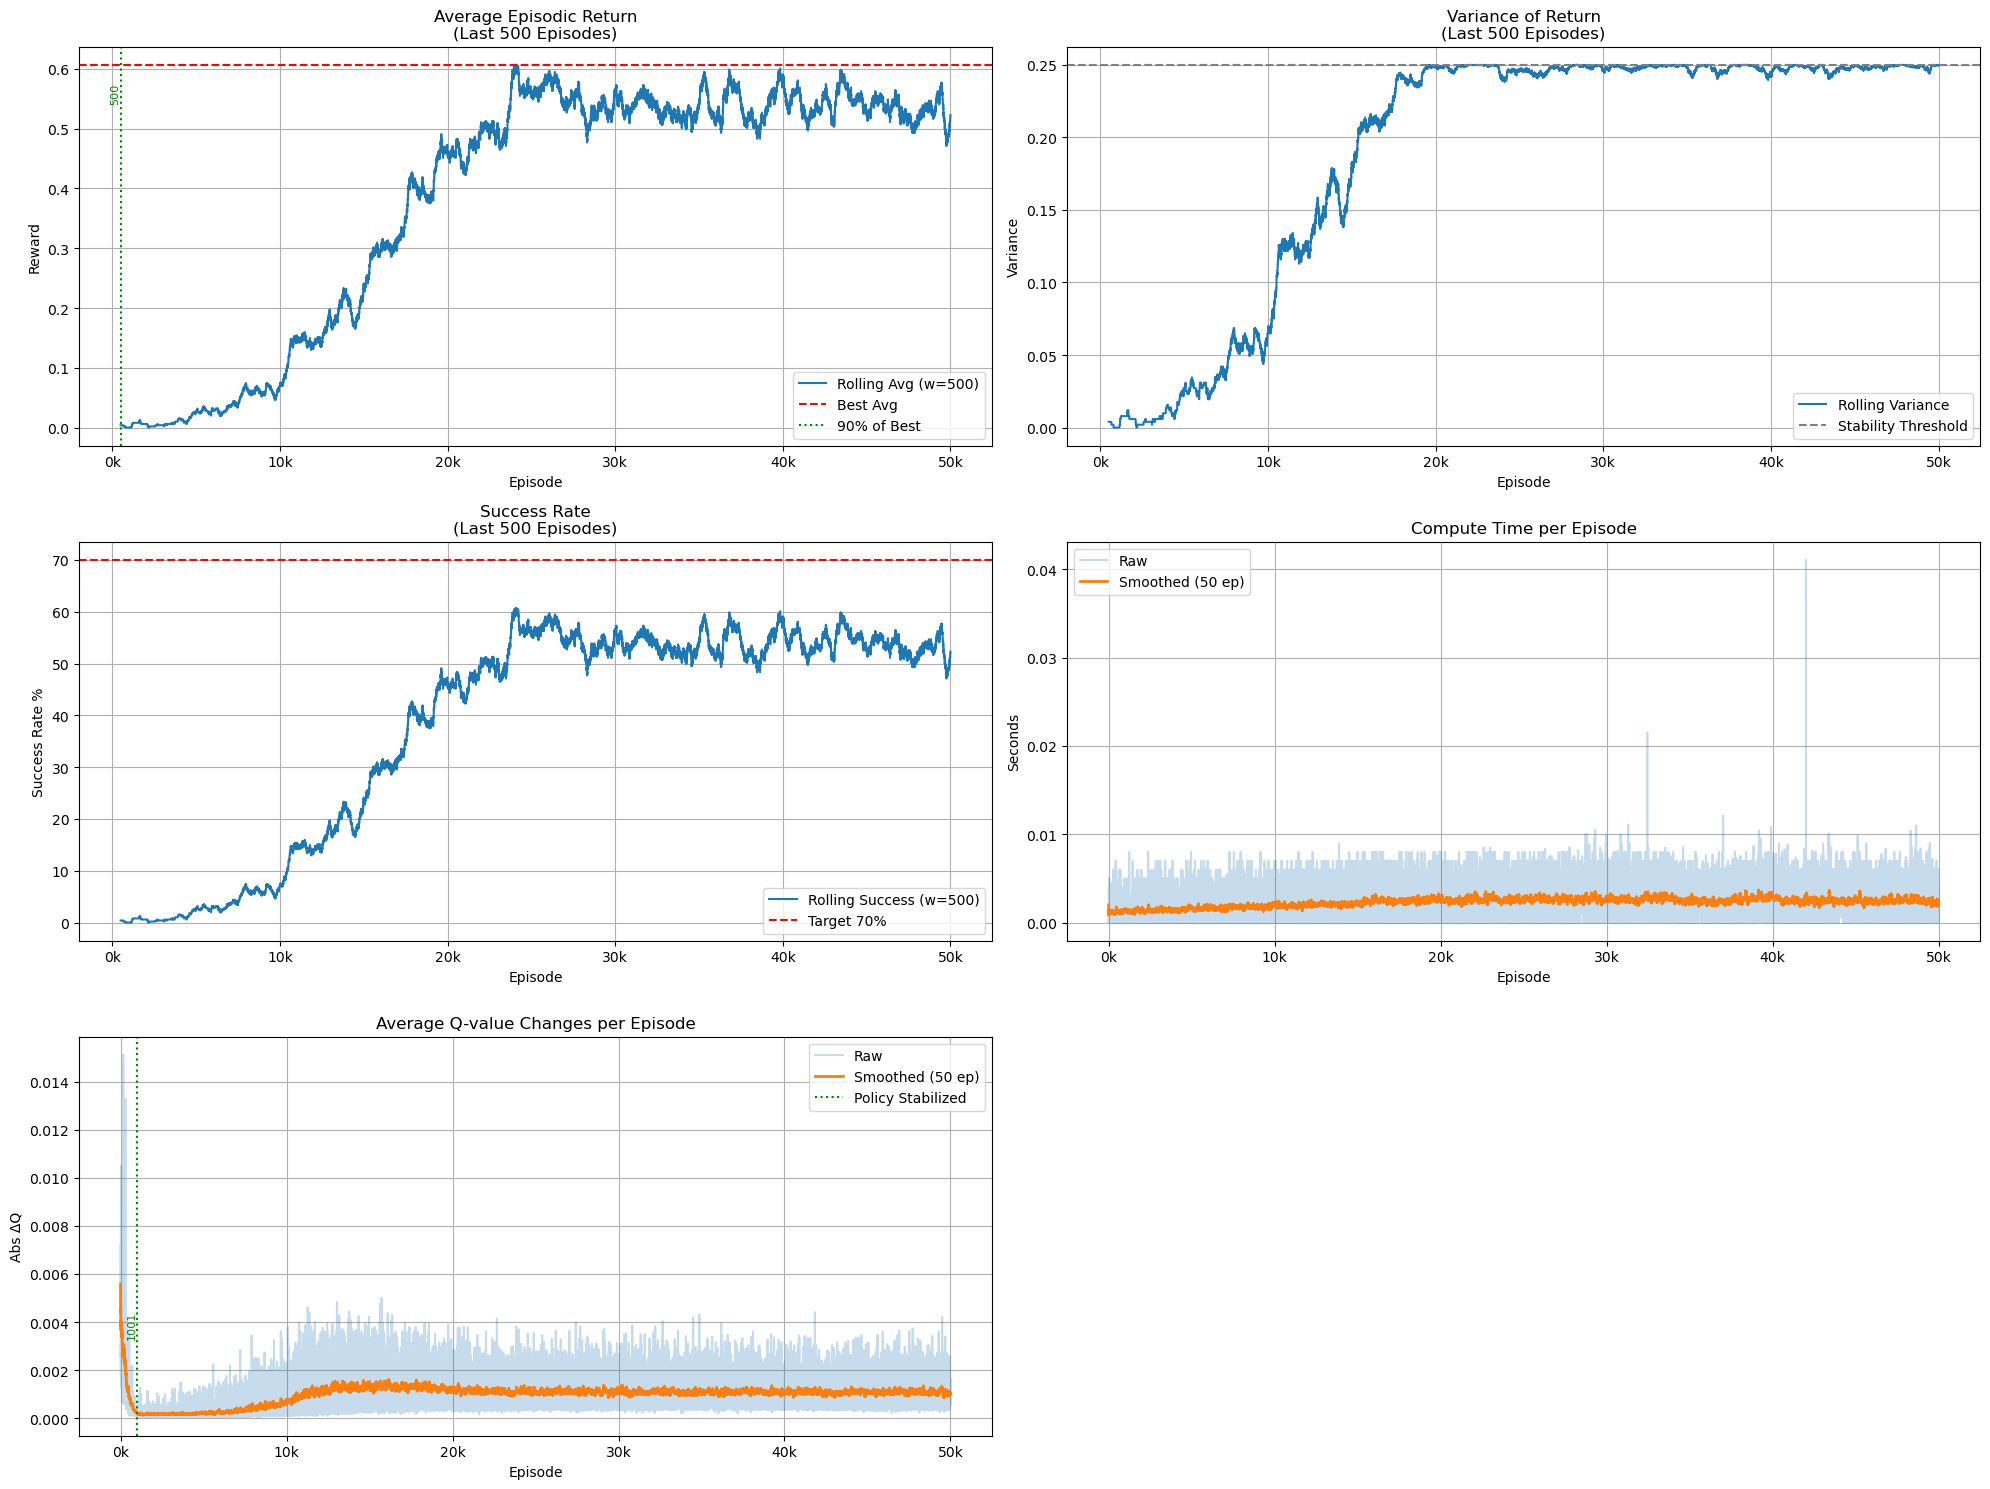


Training Sarsa Lambda


Sarsa Lambda Training: 100%|██████████████████████████████████████████████████| 100000/100000 [04:22<00:00, 380.87it/s]



=== Sarsa Lambda Results ===
1. Final Success Rate: 77.63%
2. Average Reward: 0.776 ± 0.417
3. Best Rolling Average Return: 0.716
4. Episodes to reach 90% of best: 1000
5. Average Compute Time per Episode: 0.0023 seconds
6. Policy did not fully converge during training
Training Time: 262.57 seconds


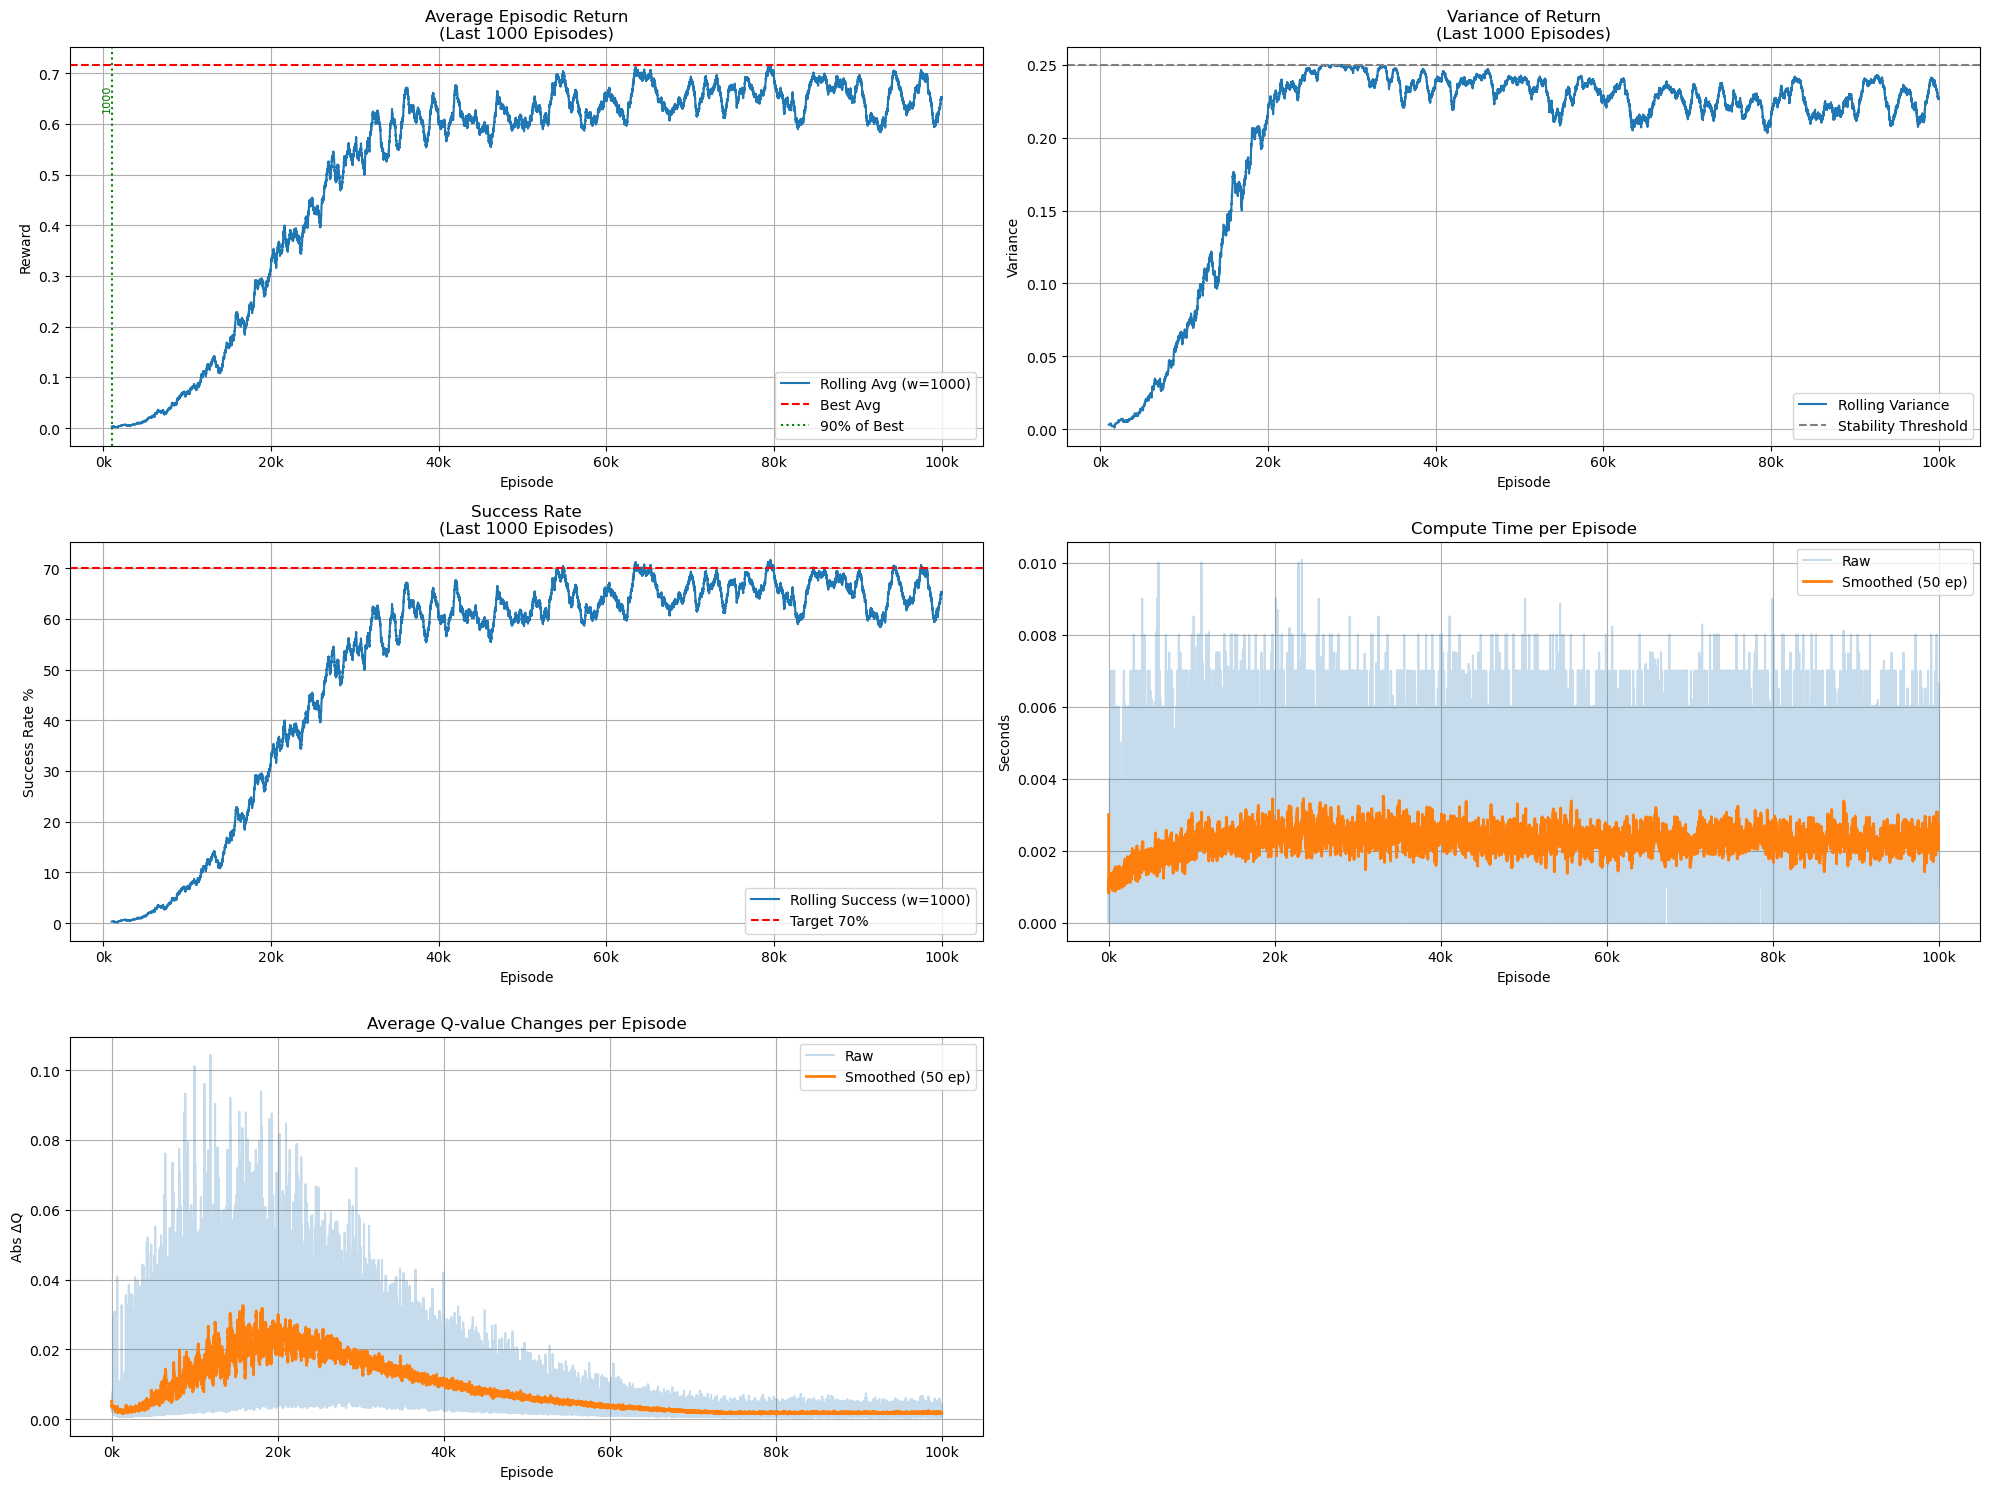


Training Q Lambda


Q Lambda Training: 100%|██████████████████████████████████████████████████████| 100000/100000 [04:51<00:00, 343.08it/s]



=== Q Lambda Results ===
1. Final Success Rate: 73.70%
2. Average Reward: 0.737 ± 0.440
3. Best Rolling Average Return: 0.573
4. Episodes to reach 90% of best: 500
5. Average Compute Time per Episode: 0.0027 seconds
6. Policy converged after ~55154 episodes
Training Time: 291.48 seconds


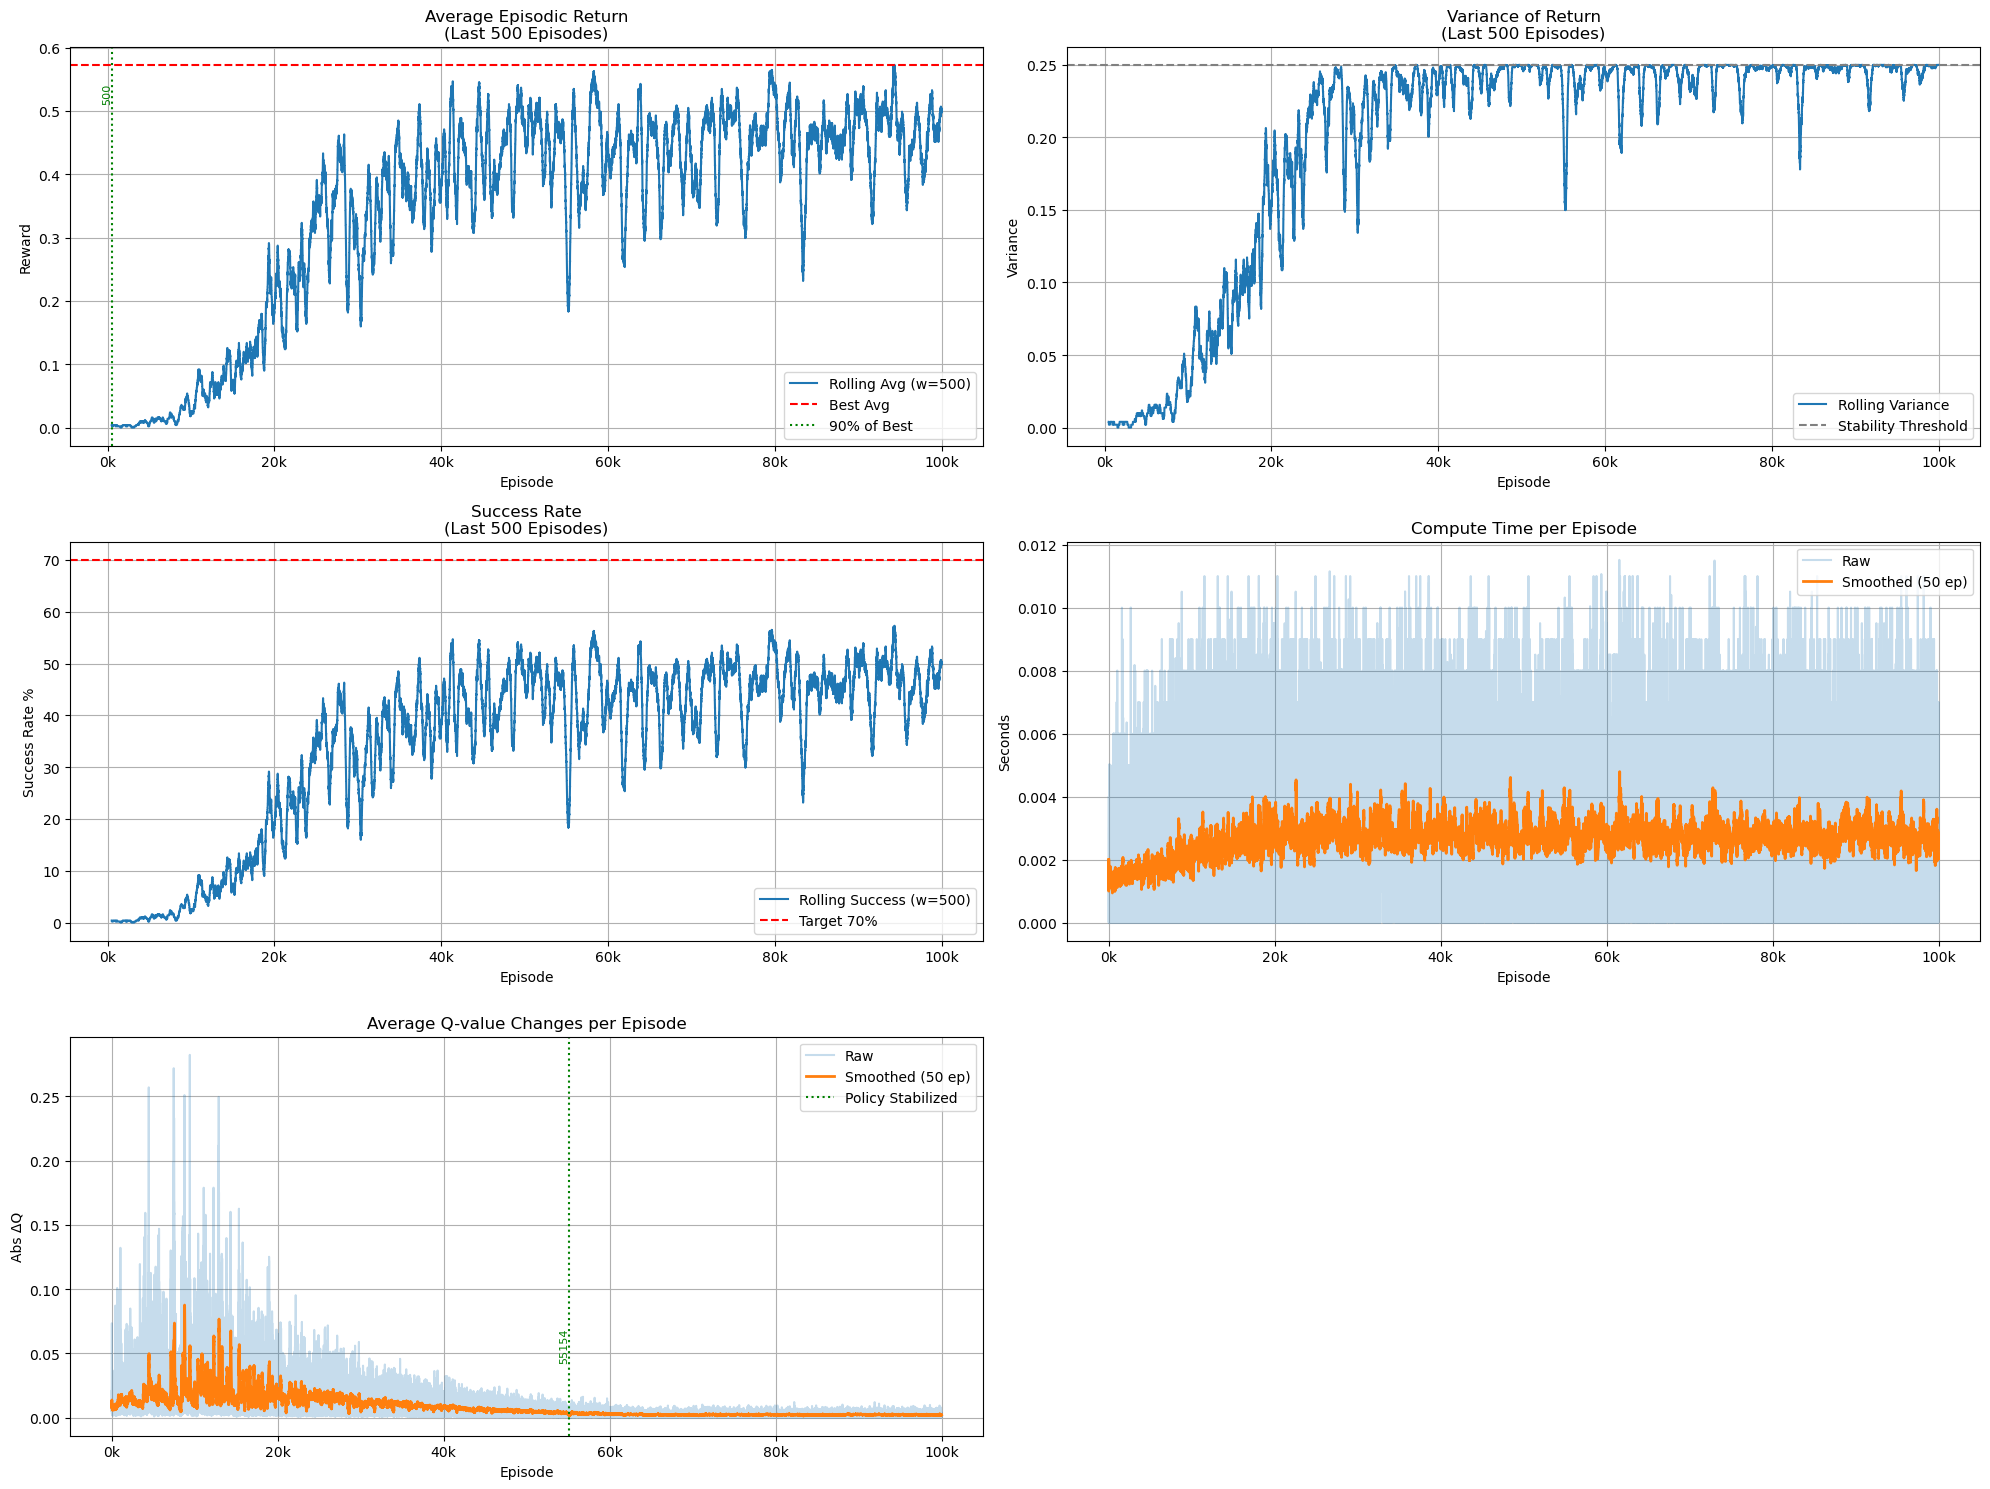


Training Monte Carlo


Monte Carlo Training: 100%|███████████████████████████████████████████████████| 100000/100000 [02:09<00:00, 772.35it/s]



=== Monte Carlo Results ===
1. Final Success Rate: 71.33%
2. Average Reward: 0.713 ± 0.452
3. Best Rolling Average Return: 0.109
4. Episodes to reach 90% of best: 1000
5. Average Compute Time per Episode: 0.0010 seconds
6. Policy converged after ~2001 episodes
Training Time: 129.48 seconds


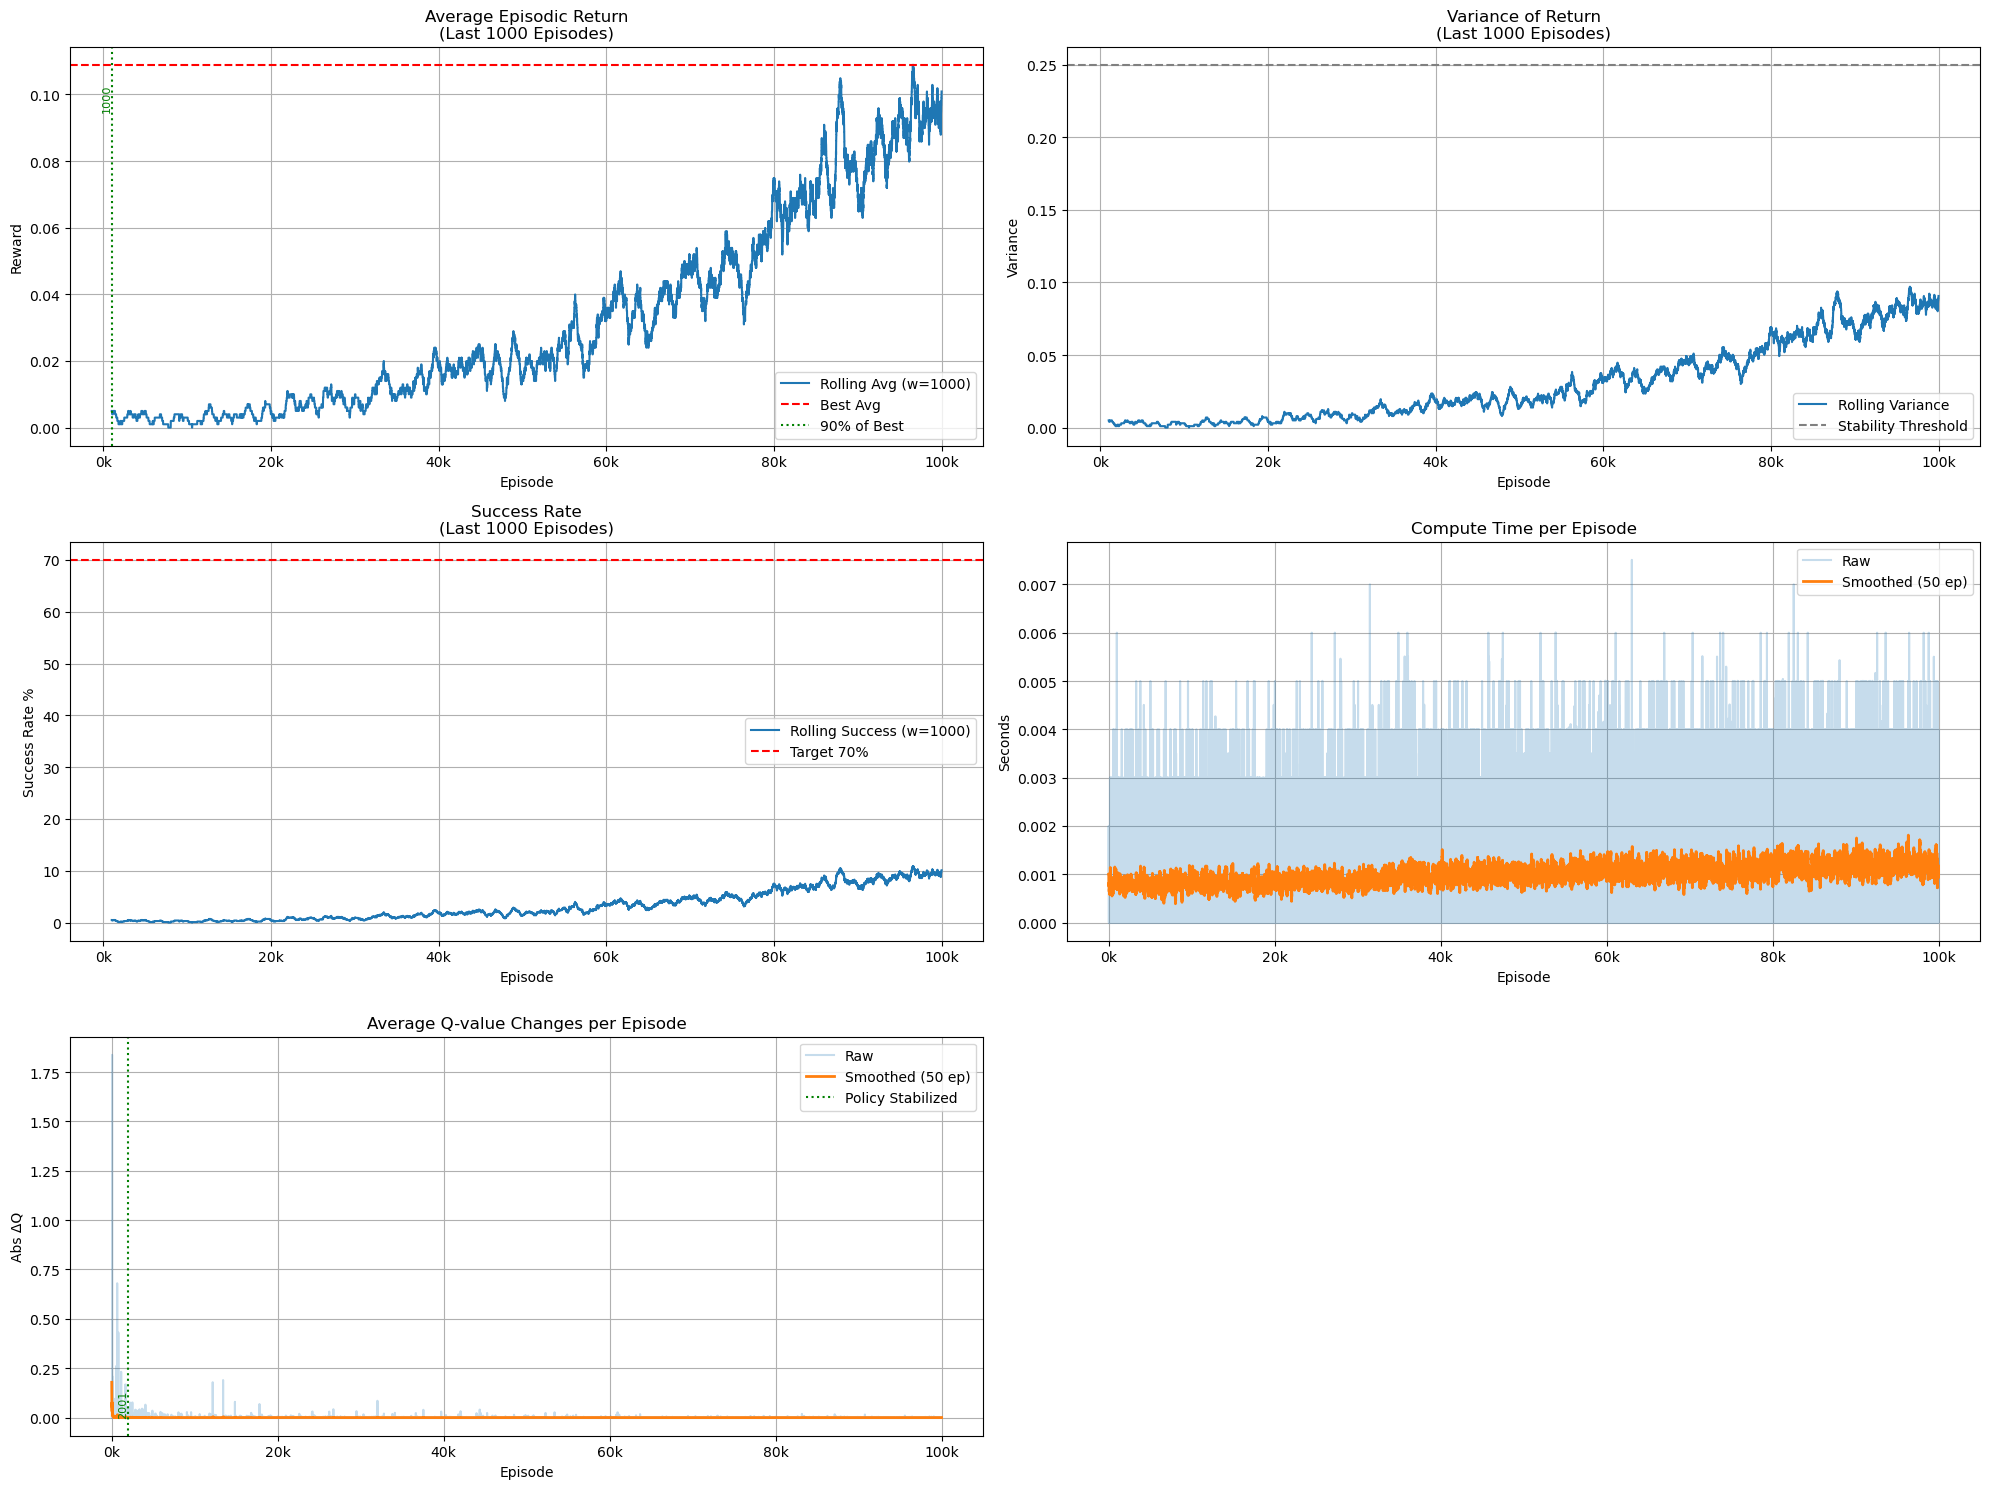


Training Monte Carlo First Visit


Monte Carlo First Visit Training: 100%|███████████████████████████████████████| 100000/100000 [04:40<00:00, 357.11it/s]



=== Monte Carlo First Visit Results ===
1. Final Success Rate: 80.82%
2. Average Reward: 0.808 ± 0.394
3. Best Rolling Average Return: 0.824
4. Episodes to reach 90% of best: 500
5. Average Compute Time per Episode: 0.0026 seconds
6. Policy converged after ~54294 episodes
Training Time: 280.03 seconds


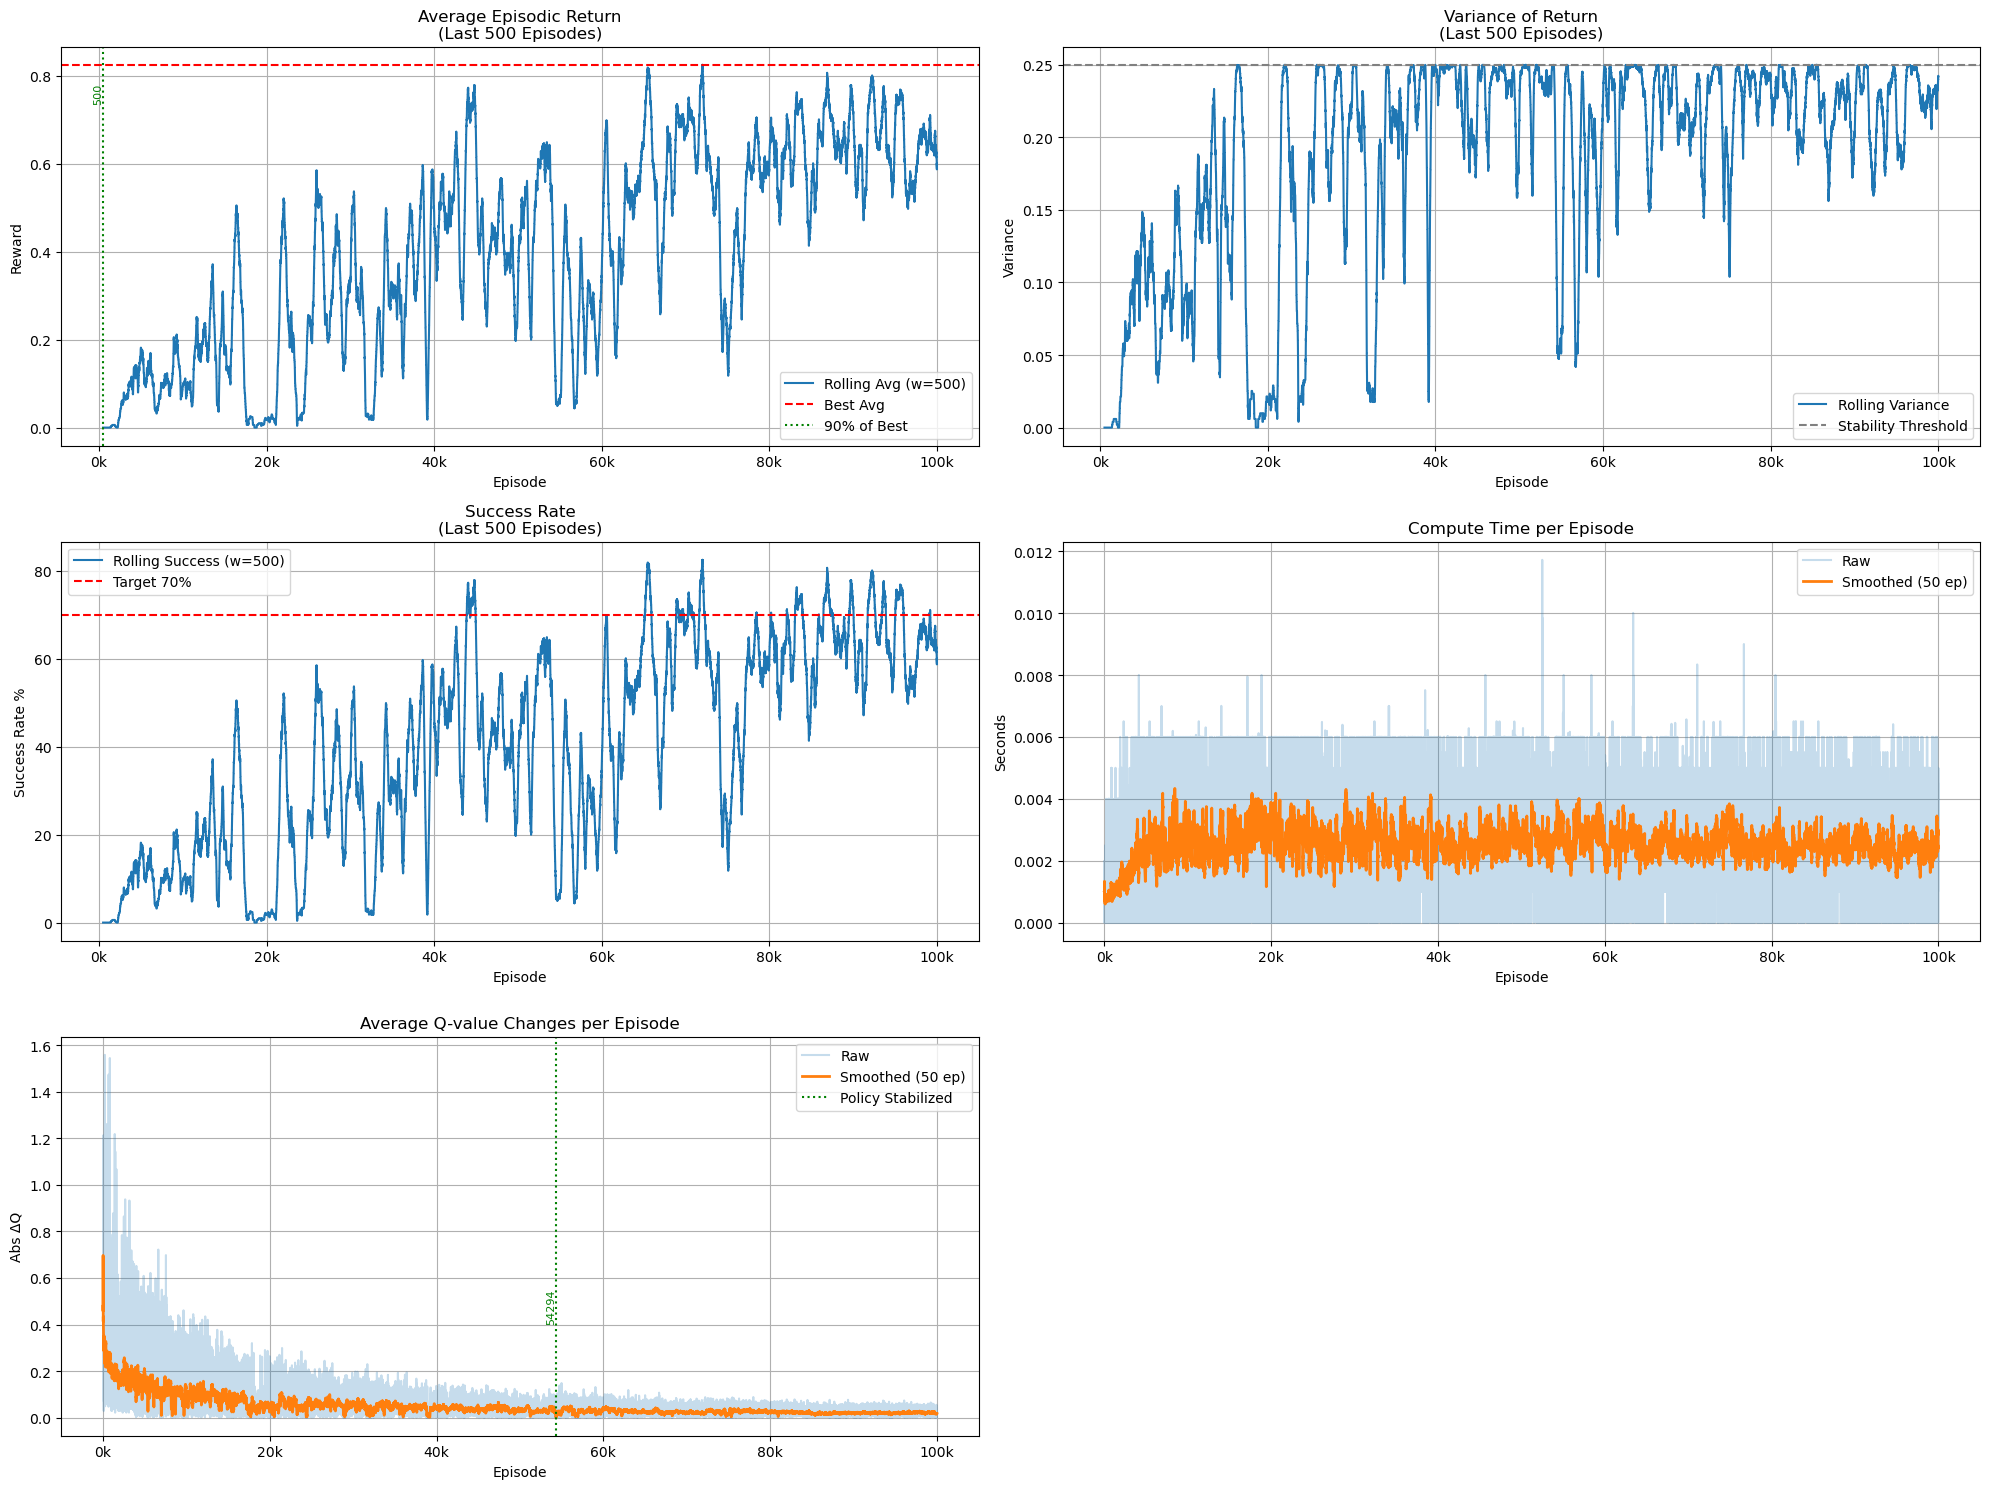


Training Double Dqn


Double Dqn Training: 100%|█████████████████████████████████████████████████████| 20000/20000 [1:04:38<00:00,  5.16it/s]



=== Double Dqn Results ===
1. Final Success Rate: 86.80%
2. Average Reward: 0.868 ± 0.338
3. Best Rolling Average Return: 0.125
4. Episodes to reach 90% of best: 8773
5. Average Compute Time per Episode: 0.1931 seconds
6. Policy did not fully converge during training
Training Time: 3878.74 seconds


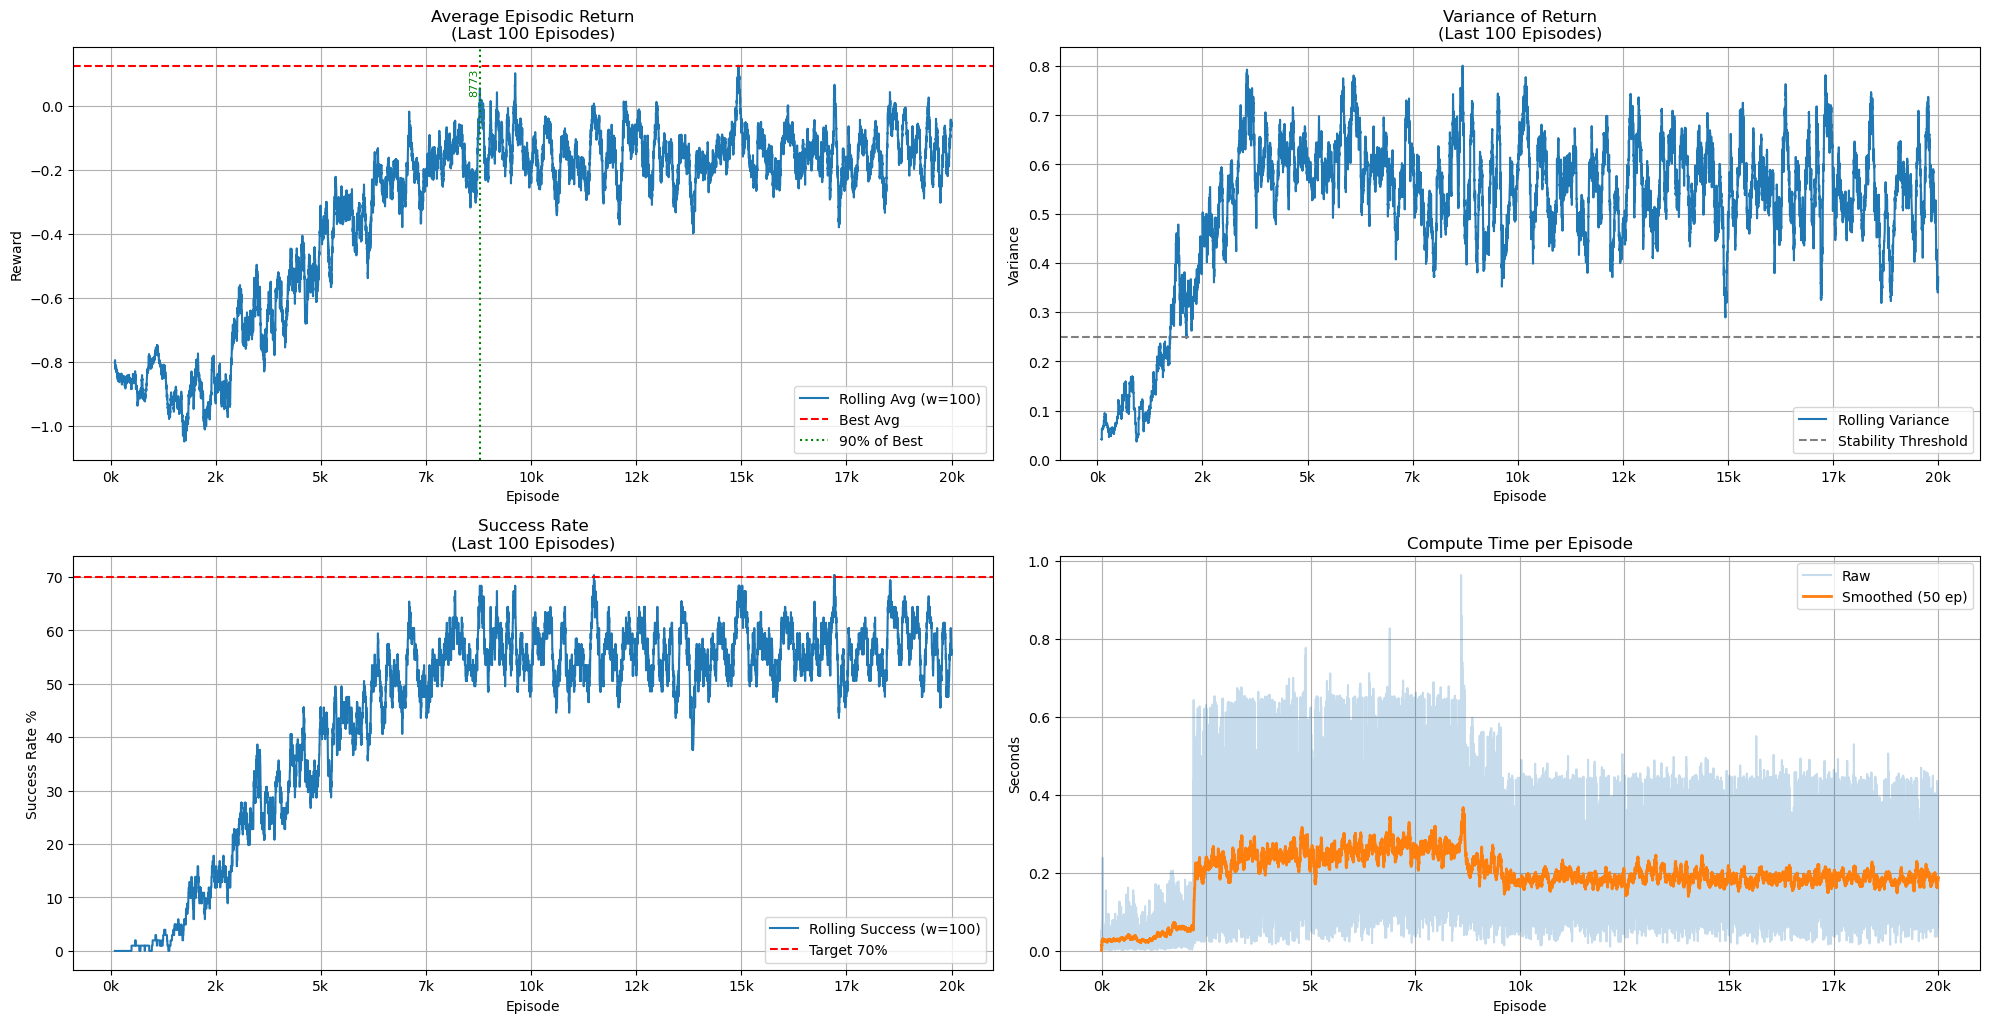

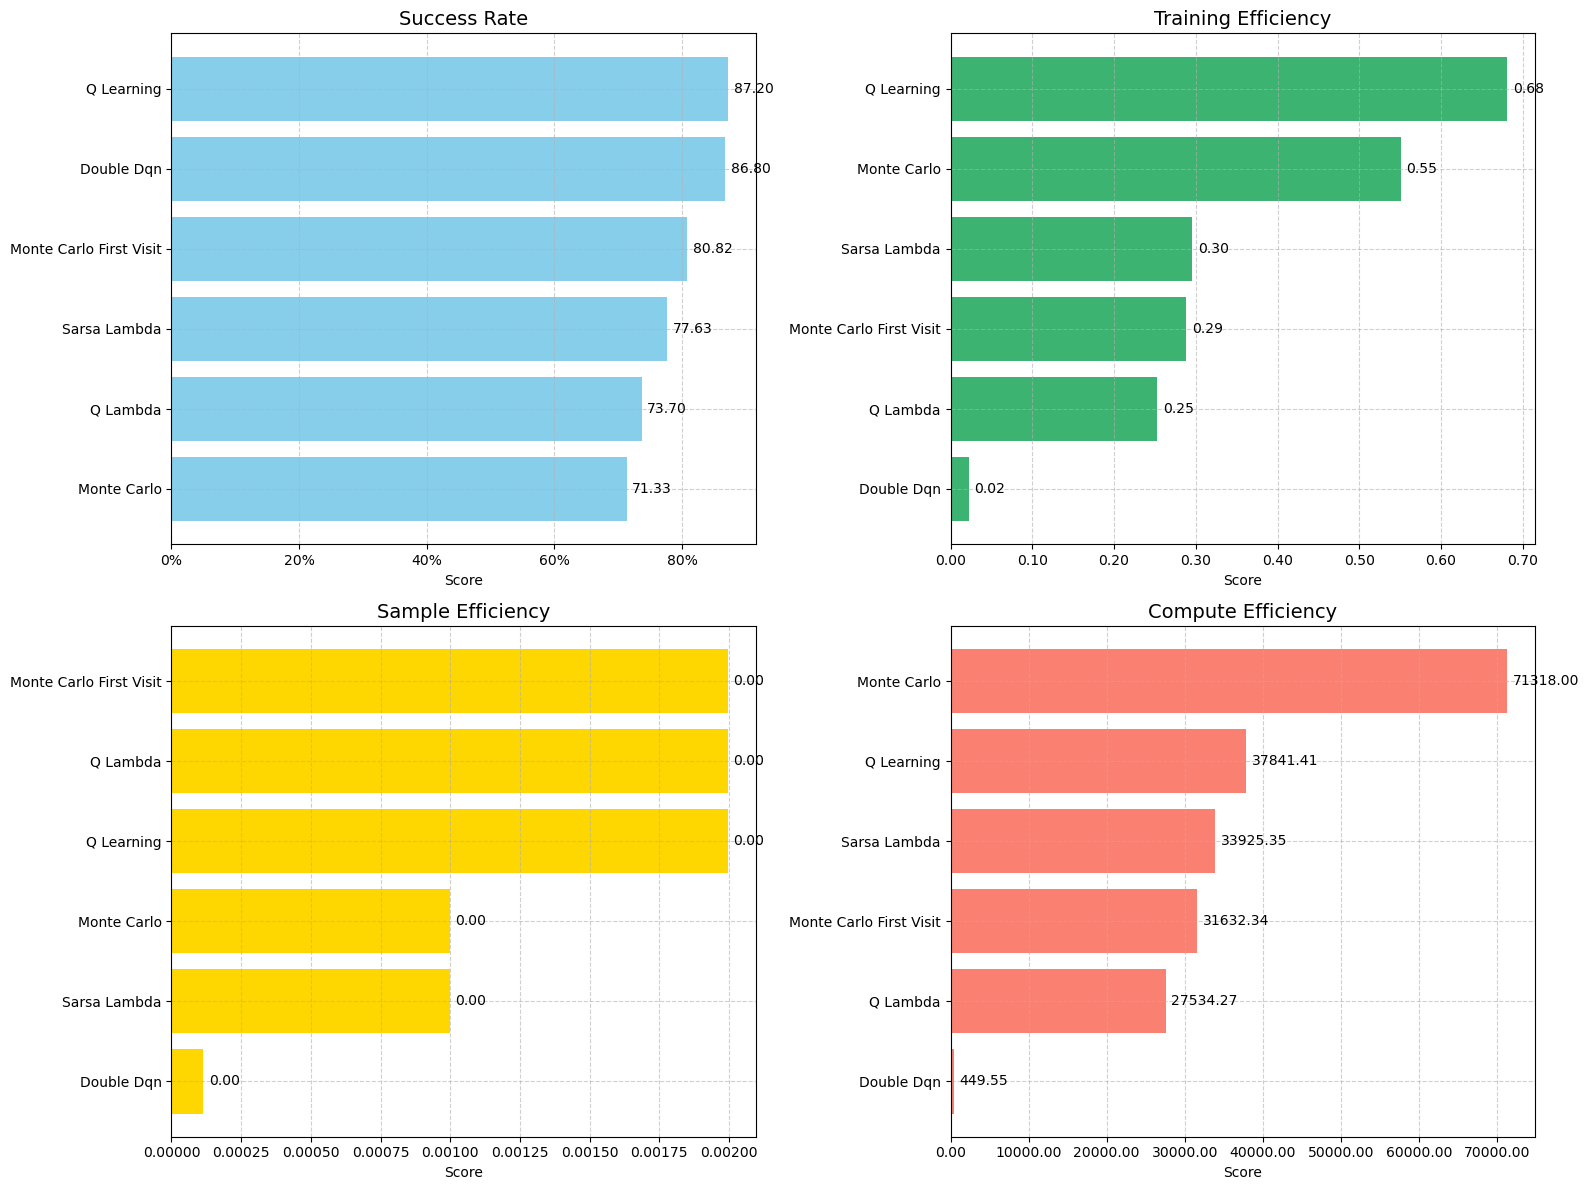

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from collections import defaultdict, deque
import torch
import torch.nn as nn
import torch.optim as optim
import random
import pandas as pd

class FrozenLakeAgent:
    def __init__(self, algorithm='q_learning', **kwargs):
        self.env = gym.make('FrozenLake8x8-v1', is_slippery=True)
        self.n_states = self.env.observation_space.n
        self.n_actions = self.env.action_space.n
        self.algorithm = algorithm.lower()
        
        # Set parameters directly from kwargs
        self._set_parameters(**kwargs)
        
        # Initialize tracking metrics
        self.episode_rewards = []
        self.success_history = []
        self.compute_times = []
        self.rolling_avg = []
        self.rolling_success = []
        self.rolling_variance = []
        self.best_avg_return = -np.inf
        self.episodes_to_target = None
        self.target_percentage = 0.9  # 90% of best average return
        self.convergence_episode = None
        self.q_changes = []  # For tracking Q-value changes
        
        # Initialize algorithm-specific components
        self._init_algorithm()
    
    def _set_parameters(self, **kwargs):
        """Set parameters directly from kwargs"""
        for param, value in kwargs.items():
            setattr(self, param, value)
        
        # Ensure critical parameters have defaults
        self.episodes = int(getattr(self, 'episodes', 10000))
        self.test_episodes = int(getattr(self, 'test_episodes', 10000))
        self.window_size = int(getattr(self, 'window_size', 500))
        
        # Algorithm-specific defaults
        if self.algorithm == 'double_dqn':
            self.batch_size = int(getattr(self, 'batch_size', 32))
            self.update_every = int(getattr(self, 'update_every', 1))
            self.tau = float(getattr(self, 'tau', 0.01))
            self.learning_rate = float(getattr(self, 'learning_rate', 0.0005))
    
    def _init_algorithm(self):
        """Initialize algorithm-specific data structures"""
        if self.algorithm in ['monte_carlo', 'monte_carlo_first_visit']:
            self.Q = np.random.uniform(low=1.0, high=2.0, size=(self.n_states, self.n_actions))
            self.returns_sum = defaultdict(float)
            self.returns_count = defaultdict(float)
            if self.algorithm == 'monte_carlo_first_visit':
                self.learning_rate = getattr(self, 'learning_rate', 0.5)
        elif self.algorithm in ['sarsa_lambda', 'q_lambda']:
            self.Q = np.random.uniform(low=0.5, high=1.0, size=(self.n_states, self.n_actions))
            self.E = np.zeros((self.n_states, self.n_actions))
            self.lambda_ = getattr(self, 'lambda_', 0.5)
        elif self.algorithm == 'double_dqn':
            class QNetwork(nn.Module):
                def __init__(self, state_size, action_size):
                    super(QNetwork, self).__init__()
                    self.fc1 = nn.Linear(state_size, 64)
                    self.fc2 = nn.Linear(64, 64)
                    self.fc3 = nn.Linear(64, action_size)

                def forward(self, x):
                    x = torch.relu(self.fc1(x))
                    x = torch.relu(self.fc2(x))
                    return self.fc3(x)
            
            self.qnetwork_local = QNetwork(64, self.n_actions)
            self.qnetwork_target = QNetwork(64, self.n_actions)
            self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.learning_rate)
            self.criterion = nn.MSELoss()
            self.memory = deque(maxlen=100000)
        else:  # Q-learning
            self.Q = np.random.uniform(low=0.1, high=0.3, size=(self.n_states, self.n_actions))

    def choose_action(self, state, epsilon=None):
        """Epsilon-greedy action selection"""
        if epsilon is None:
            epsilon = getattr(self, 'epsilon', 0.1)
            
        if np.random.random() < epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.Q[state])
    
    def shape_reward(self, reward, terminated):
        """Apply reward shaping"""
        goal_reward = getattr(self, 'goal_reward', 10)
        hole_penalty = getattr(self, 'hole_penalty', -5)
        step_penalty = getattr(self, 'step_penalty', -0.01)
        
        if terminated and reward == 1:
            return goal_reward
        elif terminated:
            return hole_penalty
        return step_penalty
    
    def train(self):
        """Train the agent using the selected algorithm"""
        start_time = time.time()
        
        # Initialize parameters with defaults if not provided
        self.epsilon = getattr(self, 'epsilon', 1.0)
        self.min_epsilon = getattr(self, 'min_epsilon', 0.01)
        self.epsilon_decay = getattr(self, 'epsilon_decay', 0.999)
        self.alpha = getattr(self, 'alpha', 0.5)
        self.gamma = getattr(self, 'gamma', 0.95)
        
        # Store initial Q-values for change tracking
        if self.algorithm != 'double_dqn':
            prev_Q = self.Q.copy()
        
        for episode in tqdm(range(self.episodes), desc=f"{self.algorithm.replace('_', ' ').title()} Training"):
            episode_start = time.time()
            
            if self.algorithm == 'monte_carlo':
                self._train_monte_carlo_episode()
            elif self.algorithm == 'monte_carlo_first_visit':
                self._train_monte_carlo_first_visit_episode()
            elif self.algorithm == 'sarsa_lambda':
                self._train_sarsa_lambda_episode()
            elif self.algorithm == 'q_lambda':
                self._train_q_lambda_episode()
            elif self.algorithm == 'double_dqn':
                self._train_double_dqn_episode()
            else:  # Q-learning
                self._train_q_learning_episode()
            
            # Update metrics
            self.compute_times.append(time.time() - episode_start)
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            self.alpha = max(0.01, self.alpha * 0.99995) 
            
            # Track Q-value changes for convergence
            if self.algorithm != 'double_dqn':
                q_change = np.mean(np.abs(self.Q - prev_Q))
                self.q_changes.append(q_change)
                prev_Q = self.Q.copy()
            
            # Update rolling averages and variance
            if episode >= self.window_size:
                window_start = episode - self.window_size
                window_rewards = self.episode_rewards[window_start:episode+1]
                window_success = self.success_history[window_start:episode+1]
                
                self.rolling_avg.append(np.mean(window_rewards))
                self.rolling_success.append(np.mean(window_success) * 100)
                self.rolling_variance.append(np.var(window_rewards))
                
                # Track best average return
                current_avg = self.rolling_avg[-1]
                if current_avg > self.best_avg_return:
                    self.best_avg_return = current_avg
                
                # Check if we've reached target percentage of best return
                if (self.episodes_to_target is None and 
                    current_avg >= self.target_percentage * self.best_avg_return):
                    self.episodes_to_target = episode
                
                # Check for convergence (stable policy)
                if (self.convergence_episode is None and episode > self.window_size * 2 and
                    len(self.q_changes) > 10 and
                    np.mean(self.q_changes[-10:]) < 0.001):
                    self.convergence_episode = episode
        
        self.training_time = time.time() - start_time

    def _train_q_learning_episode(self):
        """TD(0) Q-Learning episode"""
        state, _ = self.env.reset()
        done = False
        episode_reward = 0
        
        while not done:
            action = self.choose_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            
            shaped_reward = self.shape_reward(reward, terminated)
            best_next = np.max(self.Q[next_state])
            
            # Q-learning update
            self.Q[state][action] = (1-self.alpha) * self.Q[state][action] + \
                                   self.alpha * (shaped_reward + self.gamma * best_next)

            self.alpha = max(0.01, self.alpha * 0.9999)
            
            episode_reward += reward
            state = next_state
        
        self._update_metrics(episode_reward)

    def _train_sarsa_lambda_episode(self):
        """SARSA(λ) episode"""
        self.E.fill(0)
        state, _ = self.env.reset()
        action = self.choose_action(state)
        done = False
        episode_reward = 0
        
        while not done:
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            next_action = self.choose_action(next_state)
            
            # Adaptive reward shaping
            shaped_reward = self.shape_reward(reward, terminated)
            if terminated and reward == 0:  # Fell in hole
                shaped_reward = -2  # Softer penalty than -5
                
            td_error = shaped_reward + self.gamma * self.Q[next_state][next_action] * (not done) - self.Q[state][action]
            
            # Controlled trace update
            self.E[state][action] = min(1.2, self.E[state][action] + (1 - 0.3*self.epsilon))
            
            # Stabilized learning update
            effective_alpha = self.alpha * (1 - 0.5*self.epsilon)  # Adaptive learning rate
            self.Q += effective_alpha * td_error * self.E
            
            # Stronger trace decay
            self.E *= self.gamma * self.lambda_ * (0.97 - 0.15*self.epsilon)
            
            episode_reward += reward
            state, action = next_state, next_action
        
        self._update_metrics(episode_reward)

    def _train_q_lambda_episode(self):
        """Optimized Q(λ) episode"""
        self.E.fill(0)
        state, _ = self.env.reset()
        done = False
        episode_reward = 0
        
        while not done:
            action = self.choose_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            
            # Dynamic reward shaping
            shaped_reward = 30 if (terminated and reward == 1) else \
                           -1.5 if terminated else \
                           -0.005 * (1 + self.epsilon)  # Exploration-dependent step penalty
            
            best_next_action = np.argmax(self.Q[next_state])
            td_error = shaped_reward + self.gamma * self.Q[next_state][best_next_action] * (not done) - self.Q[state][action]
            
            # Smart trace updates
            self.E[state][action] = min(1.5, self.E[state][action] + (1 - 0.2*self.epsilon))
            self.Q += self.alpha * td_error * self.E
            self.E *= self.gamma * self.lambda_ * (0.95 - 0.1*self.epsilon)
            if np.max(self.E) > 5:  # Threshold can be adjusted
                self.E.fill(0)
            episode_reward += reward
            state = next_state
        
        self._update_metrics(episode_reward)
    
    def _train_monte_carlo_episode(self):
        """Monte Carlo (Every-Visit) episode"""
        state, _ = self.env.reset()
        done = False
        episode_history = []
        episode_reward = 0
        
        while not done:
            action = self.choose_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            
            shaped_reward = self.shape_reward(reward, terminated)
            episode_history.append((state, action, shaped_reward))
            episode_reward += reward
            state = next_state
        
        # Calculate returns and update Q-values (Every-Visit)
        G = 0
        for t in reversed(range(len(episode_history))):
            state, action, reward = episode_history[t]
            G = G * self.gamma + reward
            
            self.returns_sum[(state, action)] += G
            self.returns_count[(state, action)] += 1
            self.Q[state][action] = self.returns_sum[(state, action)] / self.returns_count[(state, action)]
        
        self._update_metrics(episode_reward)
    
    def _train_monte_carlo_first_visit_episode(self):
        """Monte Carlo (First-Visit) episode"""
        state, _ = self.env.reset()
        done = False
        episode_history = []
        episode_reward = 0
        
        while not done:
            action = self.choose_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            
            shaped_reward = self.shape_reward(reward, terminated)
            episode_history.append((state, action, shaped_reward))
            episode_reward += reward
            state = next_state
        
        # Calculate returns and update Q-values (First-Visit)
        G = 0
        first_visits = set()
        
        for t in reversed(range(len(episode_history))):
            state, action, reward = episode_history[t]
            G = G * self.gamma + reward
            
            if (state, action) not in first_visits:
                first_visits.add((state, action))
                alpha = self.learning_rate / (1 + (len(self.episode_rewards) / 10000))
                self.Q[state][action] += alpha * (G - self.Q[state][action]) * (1 + 0.5*self.epsilon)
        
        self._update_metrics(episode_reward)
    
    def _train_double_dqn_episode(self):
        """Double DQN episode"""
        state, _ = self.env.reset()
        state = self._one_hot_encode(state)
        done = False
        episode_reward = 0
        
        while not done:
            action = self._dqn_act(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            
            # Custom rewards for DQN
            if terminated:
                if self.env.unwrapped.desc.flatten()[next_state] == b'G':
                    reward = self.goal_reward  # Goal
                else:
                    reward = self.hole_penalty  # Hole
            else:
                reward = self.step_penalty  # Per timestep penalty
            
            next_state = self._one_hot_encode(next_state)
            self.memory.append((state, action, reward, next_state, done))
            
            if len(self.memory) > self.batch_size and len(self.memory) % self.update_every == 0:
                self._dqn_learn()
            
            episode_reward += reward
            state = next_state
        
        self._update_metrics(episode_reward)
    
    def _dqn_act(self, state, eps=None):
        """DQN action selection"""
        if eps is None:
            eps = self.epsilon
            
        if random.random() > eps:
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_values = self.qnetwork_local(state)
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.n_actions))
    
    def _dqn_learn(self):
        """Update DQN parameters"""
        experiences = random.sample(self.memory, k=self.batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)
        
        states = torch.FloatTensor(np.vstack(states))
        actions = torch.LongTensor(np.vstack(actions))
        rewards = torch.FloatTensor(np.vstack(rewards))
        next_states = torch.FloatTensor(np.vstack(next_states))
        dones = torch.FloatTensor(np.vstack(dones))

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        loss = self.criterion(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Soft update target network
        self._soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)
    
    def _soft_update(self, local_model, target_model, tau):
        """Soft update model parameters"""
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
    
    def _one_hot_encode(self, state, size=64):
        """One-hot encode state for DQN"""
        vec = np.zeros(size)
        vec[state] = 1
        return vec
    
    def _update_metrics(self, episode_reward):
        """Update tracking metrics"""
        self.episode_rewards.append(episode_reward)
        self.success_history.append(1 if episode_reward > 0 else 0)
    
    def test(self):
        """Evaluate the trained policy"""
        success_count = 0
        test_rewards = []
        
        for _ in range(self.test_episodes):
            if self.algorithm == 'double_dqn':
                state, _ = self.env.reset()
                state = self._one_hot_encode(state)
            else:
                state, _ = self.env.reset()
                
            done = False
            episode_reward = 0
            
            while not done:
                if self.algorithm == 'double_dqn':
                    action = self._dqn_act(state, eps=0.0)
                else:
                    action = np.argmax(self.Q[state])
                    
                state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                
                if self.algorithm == 'double_dqn':
                    state = self._one_hot_encode(state)
                
                episode_reward += reward
            
            test_rewards.append(episode_reward)
            if episode_reward > 0:
                success_count += 1
        
        self.success_rate = (success_count / self.test_episodes) * 100
        self.avg_reward = np.mean(test_rewards)
        self.test_variance = np.var(test_rewards)

    def plot_results(self):
        import pandas as pd
        import matplotlib.ticker as mtick
    
        episodes_range = np.arange(self.window_size, self.episodes)
    
        def fmt_k(ax):
            ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: f'{int(x/1000)}k'))
    
        plt.figure(figsize=(20, 15))
    
        # --- Avg Return ---
        ax = plt.subplot(3, 2, 1)
        plt.plot(episodes_range, self.rolling_avg, label=f'Rolling Avg (w={self.window_size})')
        plt.axhline(y=self.best_avg_return, color='r', ls='--', label='Best Avg')
        if self.episodes_to_target:
            plt.axvline(x=self.episodes_to_target, color='g', ls=':', 
                        label=f'{self.target_percentage*100:.0f}% of Best')
            plt.text(self.episodes_to_target, self.best_avg_return*0.95,
                     f'{self.episodes_to_target}', color='g', rotation=90, va='top', ha='right', fontsize=8)
        plt.title(f'Average Episodic Return\n(Last {self.window_size} Episodes)')
        plt.xlabel('Episode'); plt.ylabel('Reward'); plt.grid(True); plt.legend()
        fmt_k(ax)

        # --- Variance ---
        ax = plt.subplot(3, 2, 2)
        plt.plot(episodes_range, self.rolling_variance, label='Rolling Variance')
        plt.axhline(y=0.25, color='gray', ls='--', label='Stability Threshold')
        plt.title(f'Variance of Return\n(Last {self.window_size} Episodes)')
        plt.xlabel('Episode'); plt.ylabel('Variance'); plt.grid(True); plt.legend()
        fmt_k(ax)
    
        # --- Success Rate ---
        ax = plt.subplot(3, 2, 3)
        plt.plot(episodes_range, self.rolling_success, label=f'Rolling Success (w={self.window_size})')
        plt.axhline(y=70, color='r', ls='--', label='Target 70%')
        plt.title(f'Success Rate\n(Last {self.window_size} Episodes)')
        plt.xlabel('Episode'); plt.ylabel('Success Rate %'); plt.grid(True); plt.legend()
        fmt_k(ax)

        # --- Compute Time ---
        ax = plt.subplot(3, 2, 4)
        raw_times = np.array(self.compute_times)
        compute_smoothed = pd.Series(raw_times).rolling(50, min_periods=1).mean()
        plt.plot(raw_times, alpha=0.25, label='Raw')
        plt.plot(compute_smoothed, linewidth=2, label='Smoothed (50 ep)')
        plt.title('Compute Time per Episode')
        plt.xlabel('Episode'); plt.ylabel('Seconds'); plt.grid(True); plt.legend()
        fmt_k(ax)

        # --- Q-value Change ---
        if self.algorithm != 'double_dqn':
            ax = plt.subplot(3, 2, 5)
            raw_q = np.array(self.q_changes)
            q_smoothed = pd.Series(raw_q).rolling(50, min_periods=1).mean()
            plt.plot(raw_q, alpha=0.25, label='Raw')
            plt.plot(q_smoothed, linewidth=2, label='Smoothed (50 ep)')
            if self.convergence_episode:
                plt.axvline(x=self.convergence_episode, color='g', ls=':', label='Policy Stabilized')
                plt.text(self.convergence_episode, np.nanmax(q_smoothed)*0.8,
                         f'{self.convergence_episode}', color='g', rotation=90, va='top', ha='right', fontsize=8)
            plt.title('Average Q-value Changes per Episode')
            plt.xlabel('Episode'); plt.ylabel('Abs ΔQ'); plt.grid(True); plt.legend()
            fmt_k(ax)
    
        plt.tight_layout()
        plt.show()
    
    def print_results(self):
        """Print final results"""
        print(f"\n=== {self.algorithm.replace('_', ' ').title()} Results ===")
        print(f"1. Final Success Rate: {self.success_rate:.2f}%")
        print(f"2. Average Reward: {self.avg_reward:.3f} ± {np.sqrt(self.test_variance):.3f}")
        print(f"3. Best Rolling Average Return: {self.best_avg_return:.3f}")
        
        if self.episodes_to_target:
            print(f"4. Episodes to reach {self.target_percentage*100:.0f}% of best: {self.episodes_to_target}")
        else:
            print(f"4. Never reached {self.target_percentage*100:.0f}% of best average return")
        
        print(f"5. Average Compute Time per Episode: {np.mean(self.compute_times):.4f} seconds")
        
        if self.convergence_episode:
            print(f"6. Policy converged after ~{self.convergence_episode} episodes")
        else:
            print("6. Policy did not fully converge during training")
        
        print(f"Training Time: {self.training_time:.2f} seconds")
    
    @staticmethod
    def compare_algorithms(results):
        """Plot comparison of agent performance metrics (no DataFrame returned)"""
        import matplotlib.pyplot as plt
        import matplotlib.ticker as mtick
        import numpy as np
    
        # Collect metrics
        metrics = {
            'Success Rate': {},
            'Training Efficiency': {},
            'Sample Efficiency': {},
            'Compute Efficiency': {}
        }
    
        for algo, agent in results.items():
            success_rate = agent.success_rate
            training_time = agent.training_time
            compute_time = np.mean(agent.compute_times)
            episodes_to_target = agent.episodes_to_target if agent.episodes_to_target else agent.episodes
    
            metrics['Success Rate'][algo] = success_rate
            metrics['Training Efficiency'][algo] = success_rate / training_time
            metrics['Sample Efficiency'][algo] = 1 / (episodes_to_target + 1)
            metrics['Compute Efficiency'][algo] = success_rate / compute_time

        # Setup plot
        plt.figure(figsize=(16, 12))
        titles = list(metrics.keys())
        colors = ['skyblue', 'mediumseagreen', 'gold', 'salmon']
    
        for i, (title, values) in enumerate(metrics.items()):
            plt.subplot(2, 2, i + 1)
            sorted_vals = dict(sorted(values.items(), key=lambda item: item[1]))
            agents = list(sorted_vals.keys())
            scores = list(sorted_vals.values())
    
            bars = plt.barh(agents, scores, color=colors[i])
            plt.title(title, fontsize=14)
            plt.xlabel('Score')
            plt.grid(True, linestyle='--', alpha=0.6)

            # Apply formatting
            ax = plt.gca()
            if "Success" in title:
                ax.xaxis.set_major_formatter(mtick.PercentFormatter())
            elif "Sample" in title:
                ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.5f}"))
            else:
                ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.2f}"))
    
            # Annotate values
            for bar, score in zip(bars, scores):
                ax.text(bar.get_width() + max(scores) * 0.01, bar.get_y() + bar.get_height() / 2,
                        f"{score:.2f}", va='center', fontsize=10)
    
        plt.tight_layout()
        plt.show()


# Example usage with custom parameters
if __name__ == "__main__":
    algorithms = [
        'q_learning', 
        'sarsa_lambda', 
        'q_lambda', 
        'monte_carlo',
        'monte_carlo_first_visit',
        'double_dqn'
    ]
    
    # Custom parameters for each algorithm
    custom_params = {
        'q_learning': {
            'episodes': 50000,
            'alpha': 0.3,           # Reduced from 0.5 for stability
            'gamma': 0.99,
            'epsilon': 1.0,
            'min_epsilon': 0.1,     # Increased from 0.05
            'epsilon_decay': 0.9999, # Slower decay
            'goal_reward': 20,
            'hole_penalty': -3,     # Less harsh than -5
            'step_penalty': -0.01,
            'window_size': 500,
            'test_episodes': 1000
        },

        'sarsa_lambda': {
            'episodes': 100000,
            'alpha': 0.4,           # Reduced from 0.5
            'gamma': 0.98,
            'lambda_': 0.5,         # Increased from 0.3
            'epsilon': 1.0,
            'min_epsilon': 0.05,    # Increased from 0.02
            'epsilon_decay': 0.9999, # Slower decay reduced from 0.999
            'goal_reward': 30,
            # 'hole_penalty': -2,     # Reduced from -5
            'hole_penalty': -1.5,  # Further soften from -2
            # 'step_penalty': -0.01,
            'step_penalty': -0.005, # Half the penalty
            'window_size': 1000,  # Latest Better for long training runs
            'test_episodes':10000
        },

       
        'q_lambda': {
            'episodes': 100000,
            'alpha': 0.25,          # Reduced from 0.3 for stability
            'gamma': 0.95,
            'lambda_': 0.8,         # Increased from 0.7 for longer traces
            'epsilon': 1.0,
            'min_epsilon': 0.08,    # More persistent exploration
            'epsilon_decay': 0.9999, # Slower exploration decay
            'goal_reward': 30,
            'hole_penalty': -1.5,   # Softer than -2
            'step_penalty': -0.01,
            'window_size': 500,
            'test_episodes':10000
        },

        'monte_carlo': {
            'episodes': 100000,  # Increased from 50k
            'gamma': 0.999,      # Higher discount
            'epsilon': 1.0,
            'min_epsilon': 0.1,  # Increased from 0.01
            'epsilon_decay': 0.99999,  # Slower decay
            'goal_reward': 30,
            'hole_penalty': -1,  # Softer from -5
            'step_penalty': -0.001,  # Reduced from -0.005
            'window_size': 1000, # from 500
            'test_episodes':10000
        },

        'monte_carlo_first_visit': {
            'episodes': 100000,
            'gamma': 0.95,
            'min_epsilon': 0.01,
            'epsilon_decay': 0.999,
            'learning_rate': 0.8,
            'goal_reward': 20,
            'hole_penalty': -10,
            'step_penalty': -0.02,
            'window_size': 500,
            'test_episodes':10000
        },
        
        'double_dqn': {
            'episodes': 20000,
            'gamma': 0.99,
            'epsilon': 1.0,
            'min_epsilon': 0.01,
            'epsilon_decay': 0.9995,
            'learning_rate': 0.0005,
            'batch_size': 64,
            'update_every': 4,
            'tau': 0.01,
            'goal_reward': 1.0,
            'hole_penalty': -0.5,
            'step_penalty': -0.01,
            'window_size': 100,
            'test_episodes':1000
        }
    }
    
    results = {}
    
    for algo in algorithms:
        print(f"\n{'='*40}\nTraining {algo.replace('_', ' ').title()}\n{'='*40}")
        
        params = custom_params.get(algo, {})
        agent = FrozenLakeAgent(algorithm=algo, **params)
        agent.train()
        agent.test()
        agent.print_results()
        agent.plot_results()
        
        results[algo.replace('_', ' ').title()] = agent
    
    FrozenLakeAgent.compare_algorithms(results)

# FrozenLake RL Agents: Optimization Analysis

## Key Improvements

#### Q-Learning:
- Reduced learning rate (α) from 0.5 to 0.3 for stability  
- Increased minimum epsilon from 0.05 to 0.1 for persistent exploration  
- Slowed epsilon decay (0.9999)  
- Softened hole penalty from -5 to -3  
- Increased goal reward from 10 to 20  

#### SARSA(λ):
- Increased λ from 0.3 to 0.5 for longer eligibility traces  
- Reduced hole penalty from -5 to -1.5  
- Halved step penalty from -0.01 to -0.005  
- Added exploration-dependent step penalty  

#### Q(λ):
- Reduced α from 0.3 to 0.25  
- Increased λ from 0.7 to 0.8  
- Added dynamic reward shaping    

#### Monte Carlo:
- Increased discount factor γ to 0.999  
- Softened hole penalty from -5 to -1  
- Reduced step penalty from -0.005 to -0.001  
- Slowed epsilon decay (0.99999)  

#### Monte Carlo First Visit:
- Added adaptive learning rate that decreases with experience   

#### Double DQN:
- Increased batch size from 32 to 64  
- Changed update frequency from every step to every 4 steps  
- Reduced τ from 0.1 to 0.01 for slower target network updates  

## Performance Results

| Algorithm            | Success Rate | Avg Reward (±std) | Best Avg Return | Variance (σ²) | Training Time | Sample Efficiency |
|----------------------|--------------|-------------------|-----------------|---------------|---------------|-------------------|
| Q-Learning           | 87.20%       | 0.872 ± 0.334     | 0.607           | 0.112         | 128.04s       | 500 episodes      |
| SARSA(λ)            | 77.63%       | 0.776 ± 0.417     | 0.716           | 0.174         | 262.57s       | 1000 episodes     |
| Q(λ)                | 73.70%       | 0.737 ± 0.440     | 0.573           | 0.194         | 291.48s       | 500 episodes      |
| Monte Carlo          | 71.33%       | 0.713 ± 0.452     | 0.109           | 0.204         | 129.48s       | 1000 episodes     |
| MC First Visit       | 80.82%       | 0.808 ± 0.394     | 0.824           | 0.155         | 280.03s       | 500 episodes      |
| Double DQN           | 86.80%       | 0.868 ± 0.338     | 0.125           | 0.114         | 3878.74s      | 8773 episodes     |



# Bandits


Running Greedy...

Greedy Results:
Final Cumulative Reward: 957.45
Final Cumulative Regret: 2042.55
Final % Optimal: 0.00%
First Optimal Action: Episode 1000
90% Convergence: Episode 1000


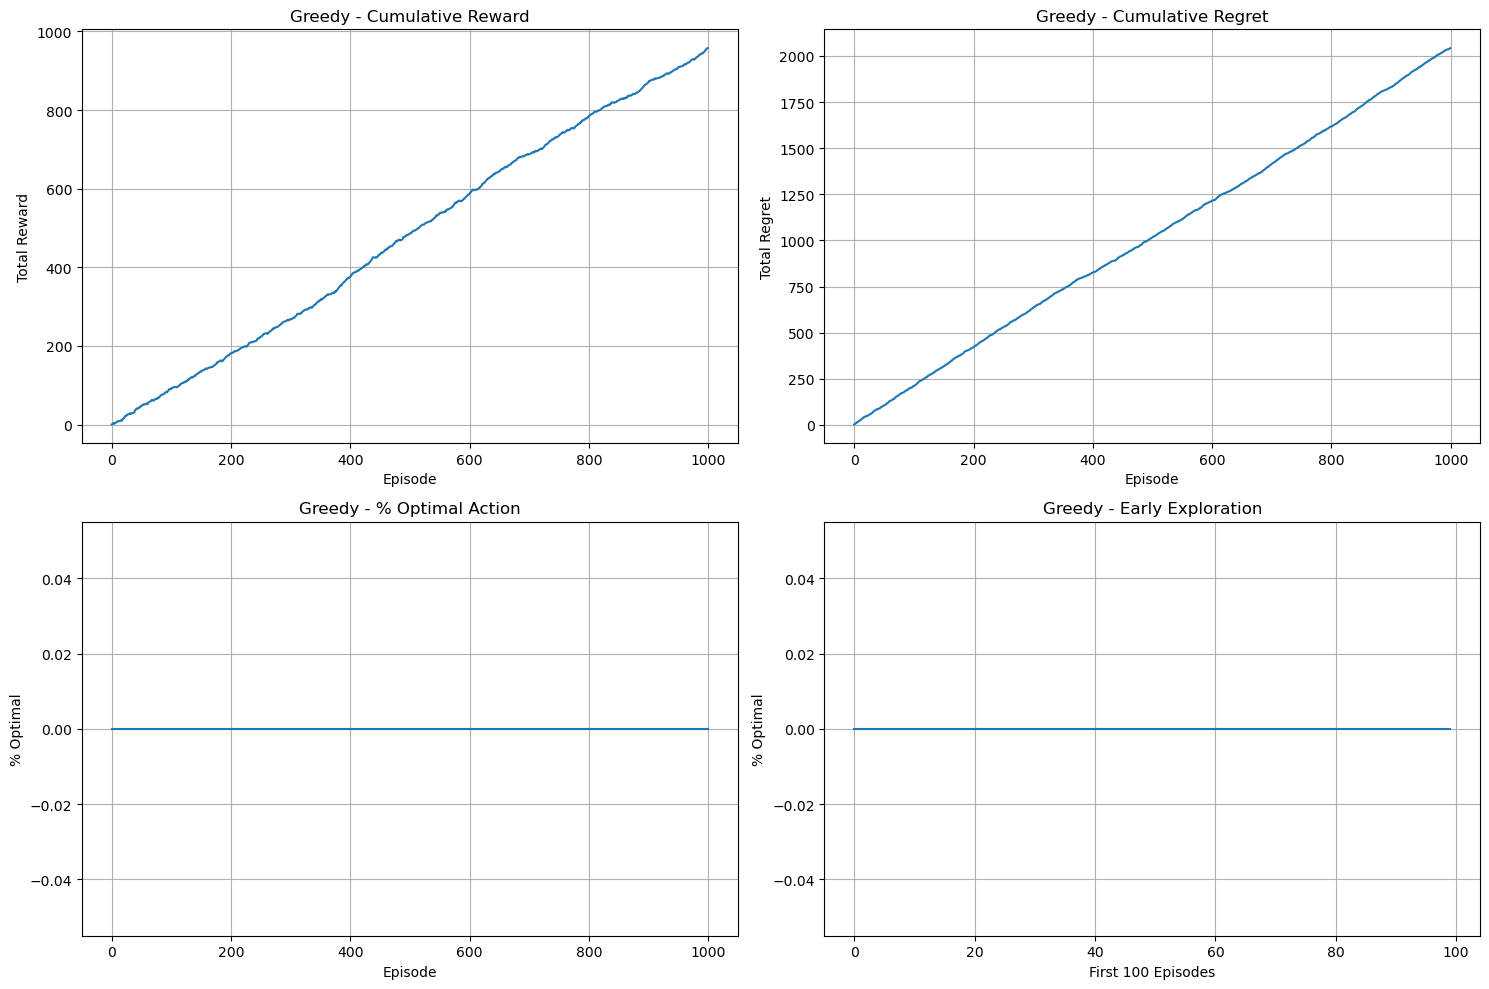


Running ε-Greedy (0.1)...

ε-Greedy (0.1) Results:
Final Cumulative Reward: 2836.65
Final Cumulative Regret: 163.35
Final % Optimal: 85.90%
First Optimal Action: Episode 50
90% Convergence: Episode 1000


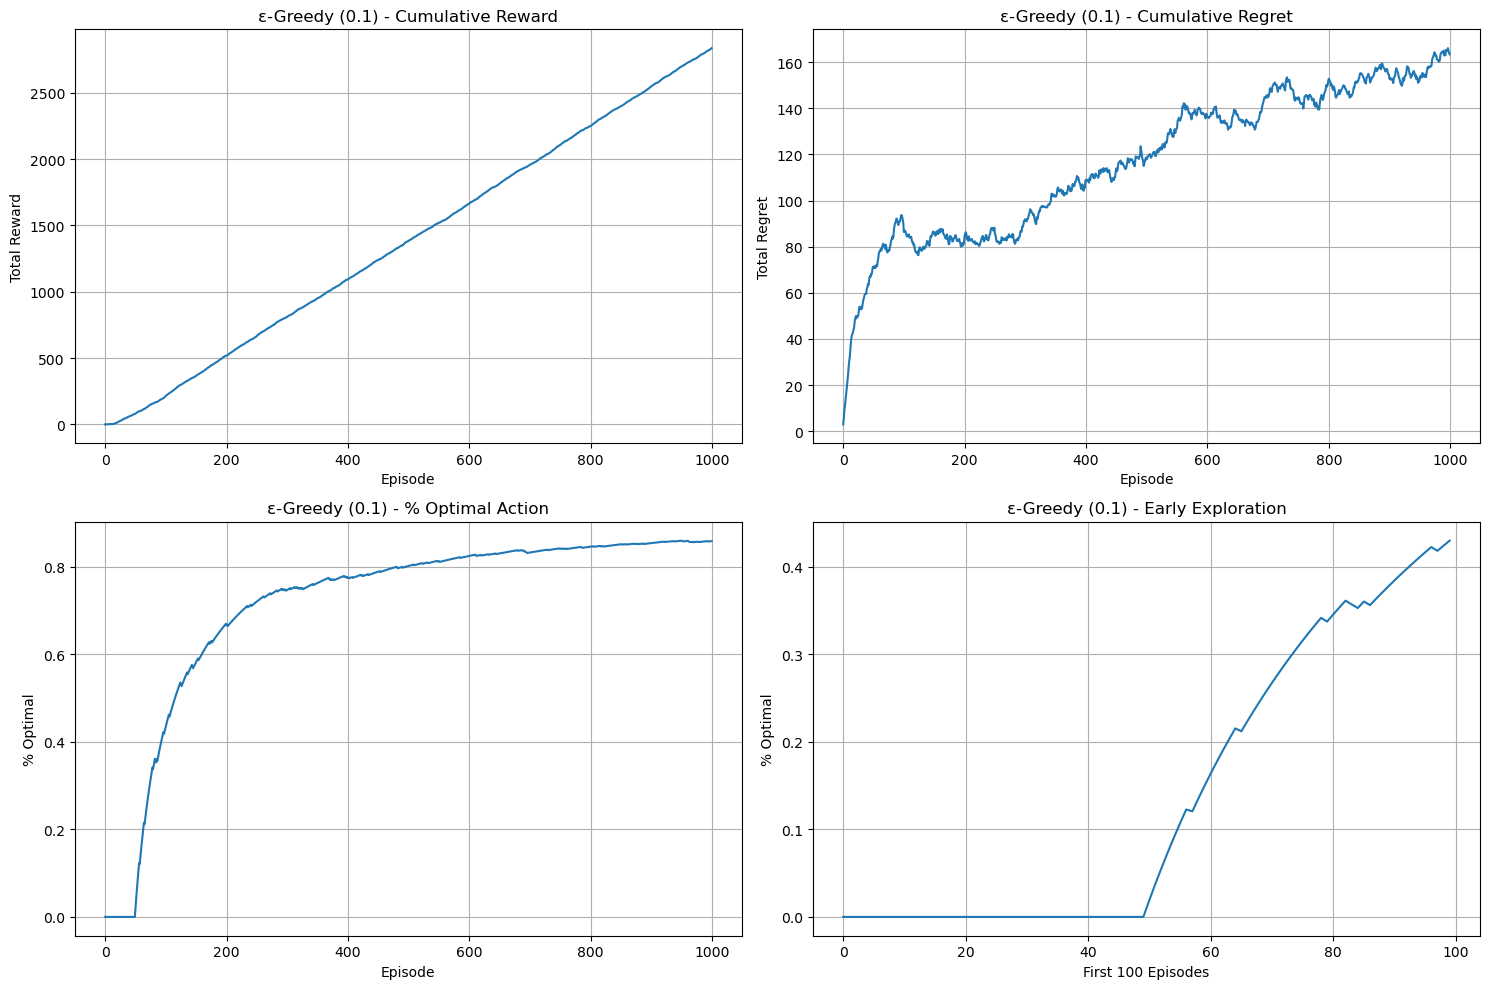


Running Decaying ε-Greedy...

Decaying ε-Greedy Results:
Final Cumulative Reward: 2020.06
Final Cumulative Regret: 979.94
Final % Optimal: 0.00%
First Optimal Action: Episode 1000
90% Convergence: Episode 1000


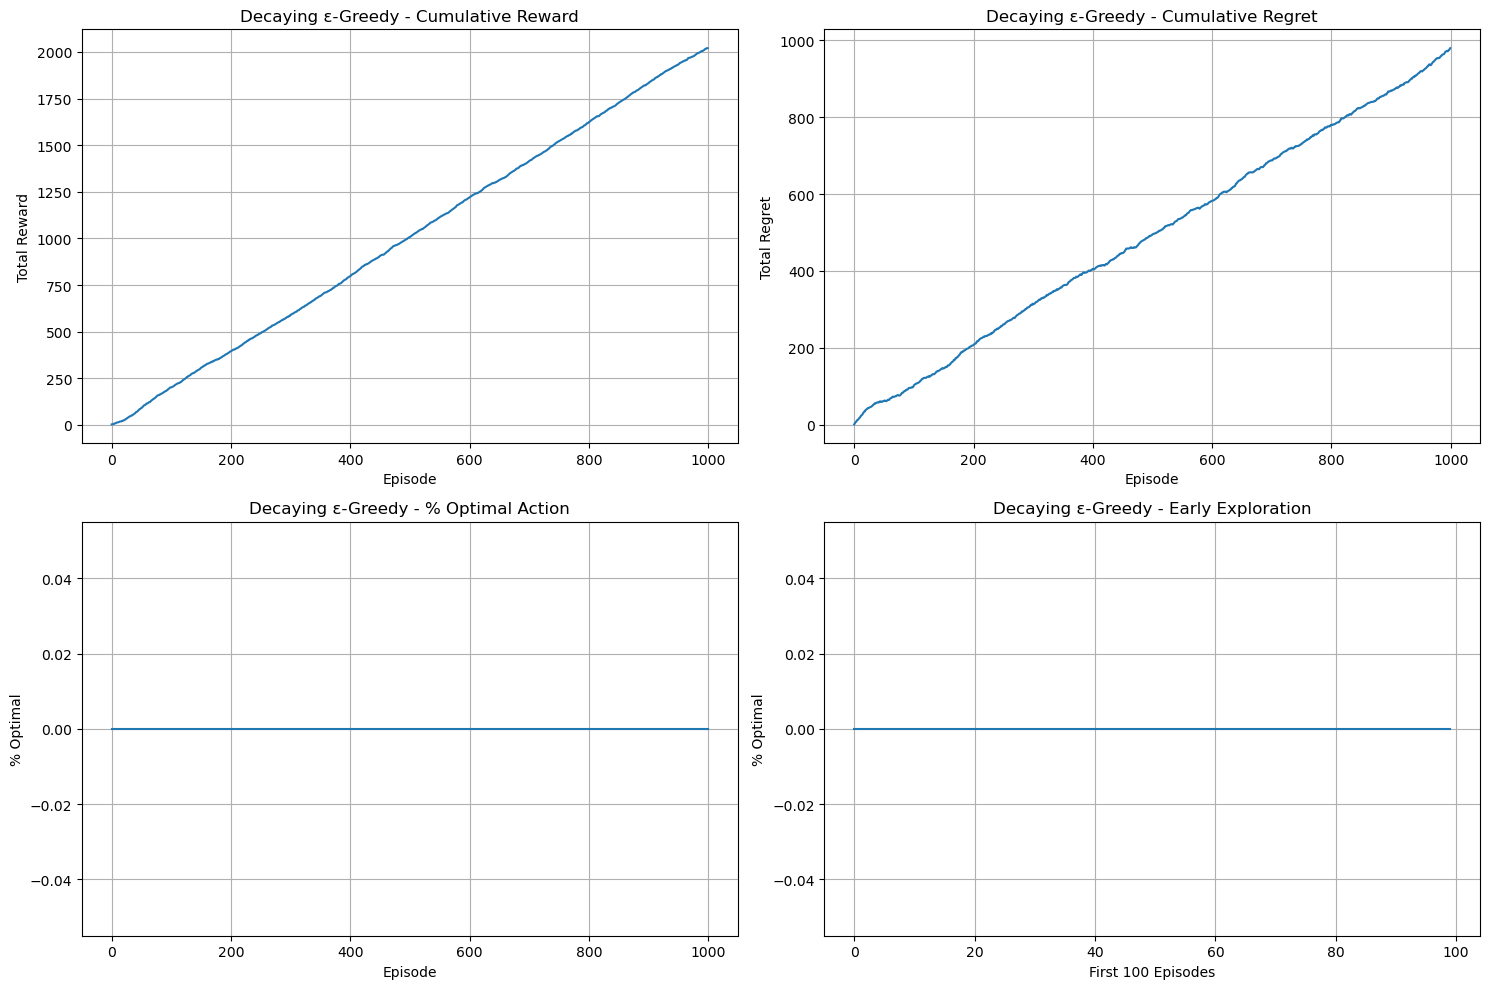


Running UCB (c=2)...

UCB (c=2) Results:
Final Cumulative Reward: 2908.93
Final Cumulative Regret: 91.07
Final % Optimal: 89.20%
First Optimal Action: Episode 4
90% Convergence: Episode 1000


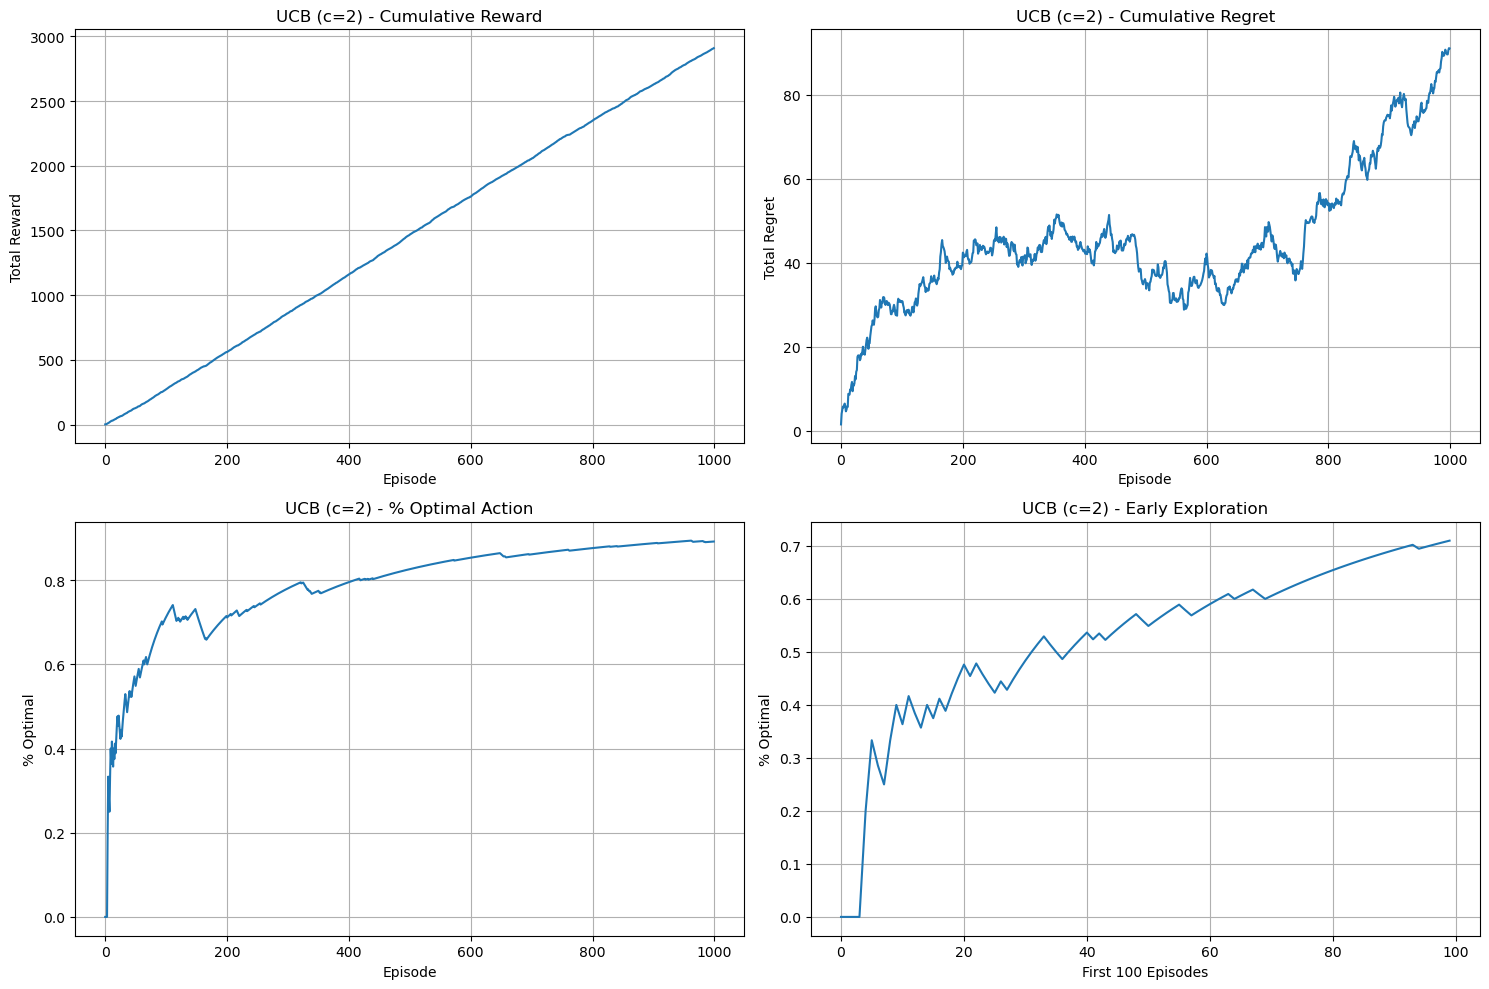


Running Thompson Sampling...

Thompson Sampling Results:
Final Cumulative Reward: 2807.65
Final Cumulative Regret: 192.35
Final % Optimal: 84.40%
First Optimal Action: Episode 13
90% Convergence: Episode 1000


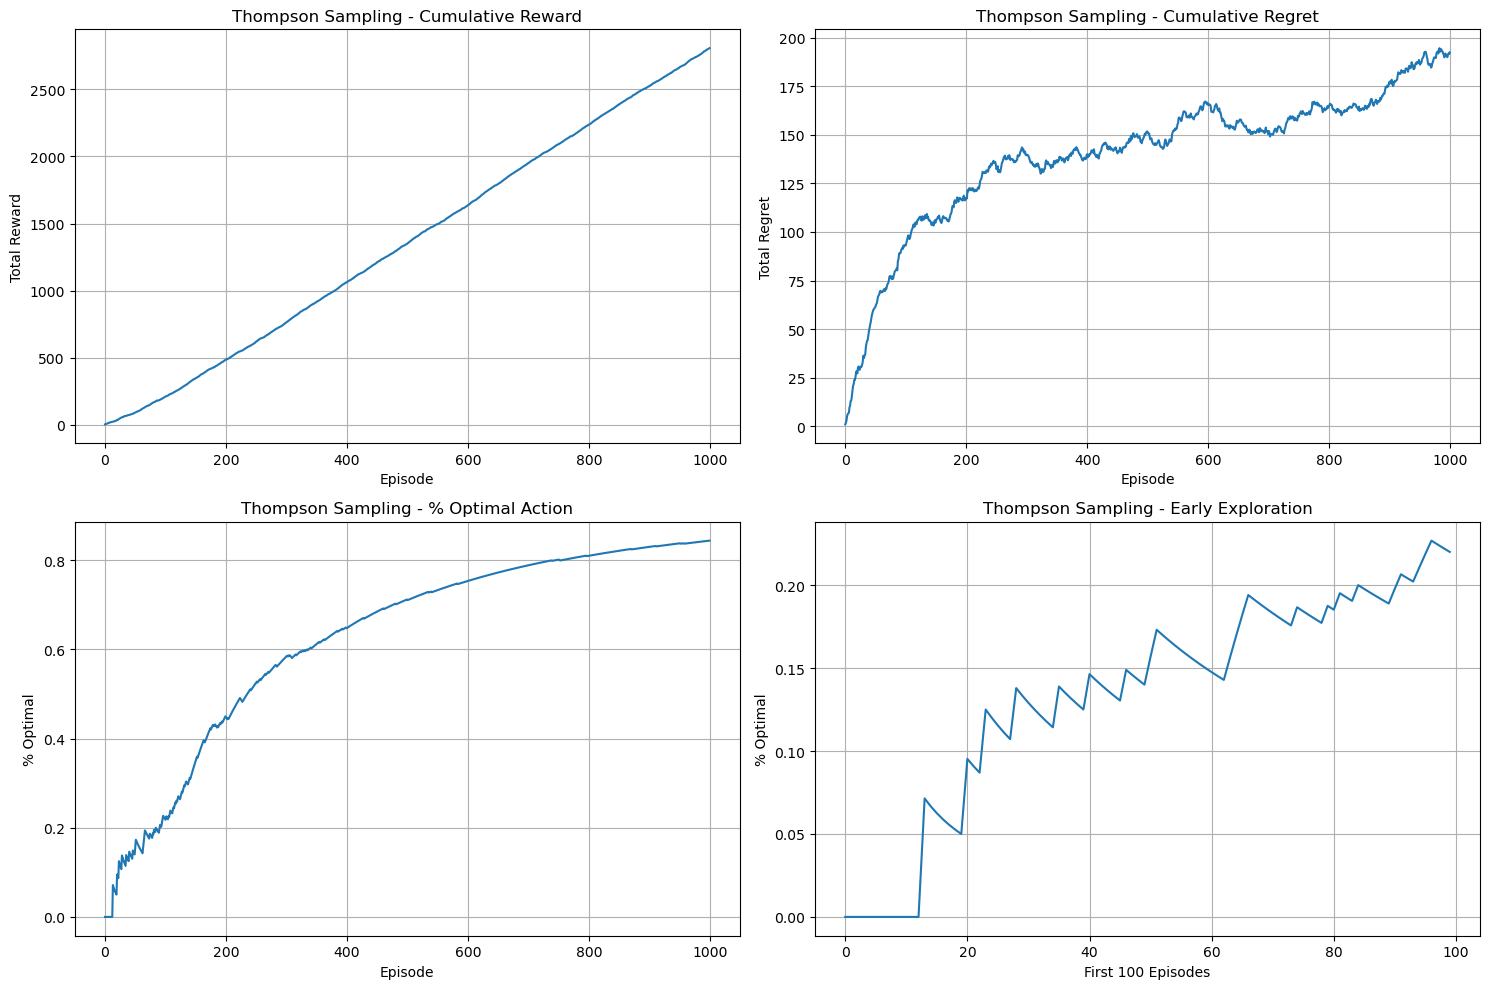


Running Policy Gradient...

Policy Gradient Results:
Final Cumulative Reward: 2507.62
Final Cumulative Regret: 492.38
Final % Optimal: 24.90%
First Optimal Action: Episode 1
90% Convergence: Episode 1000


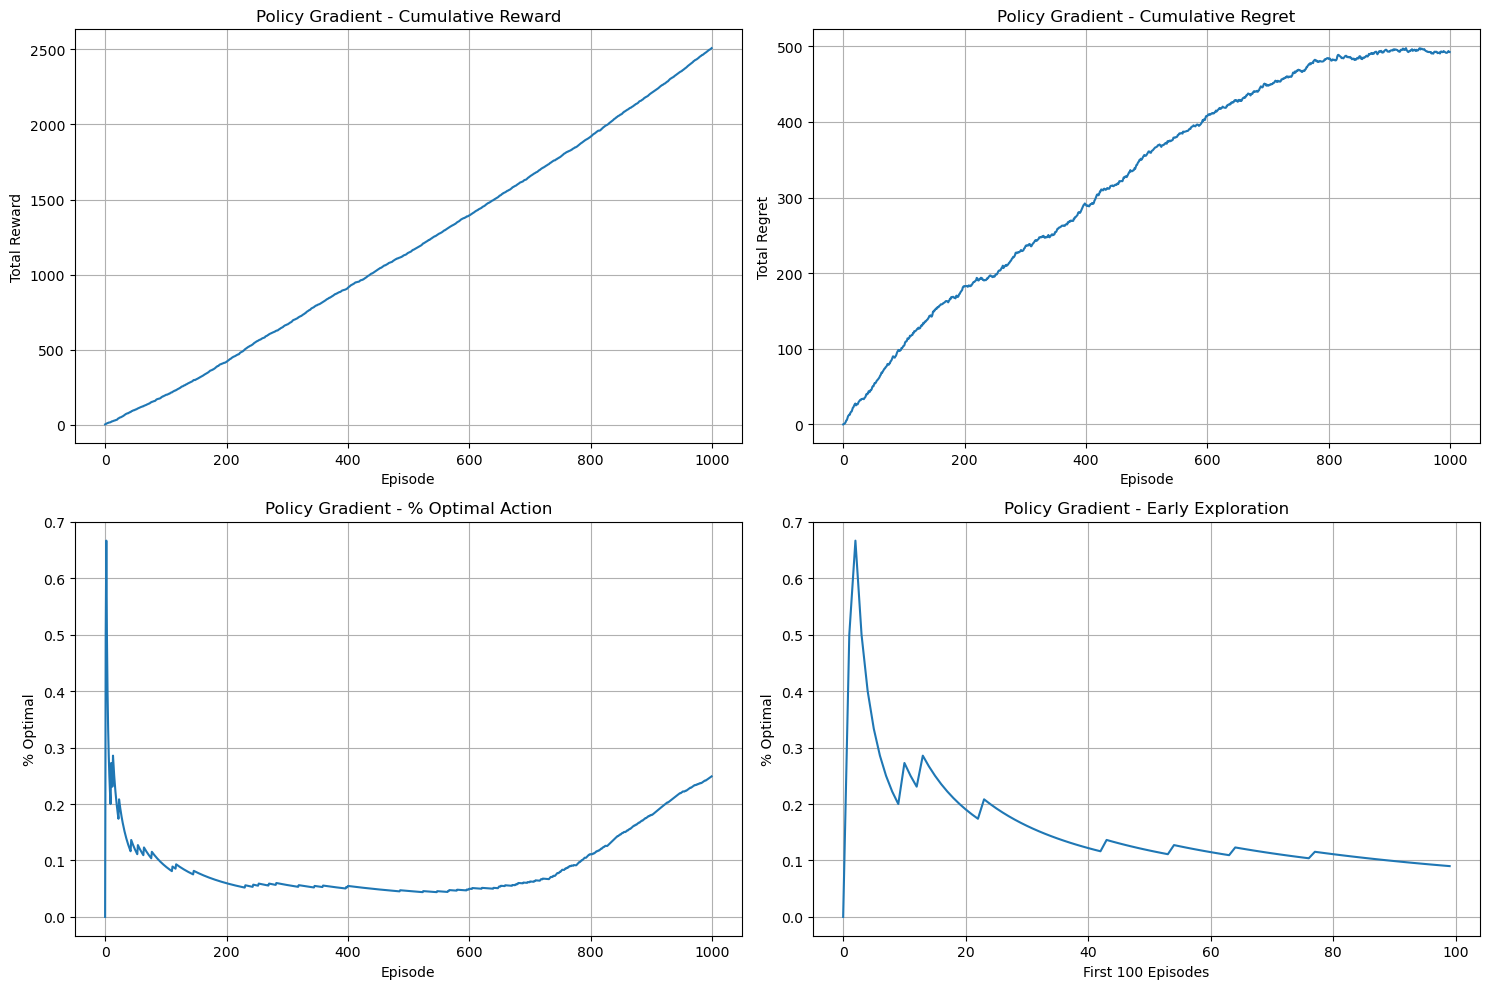

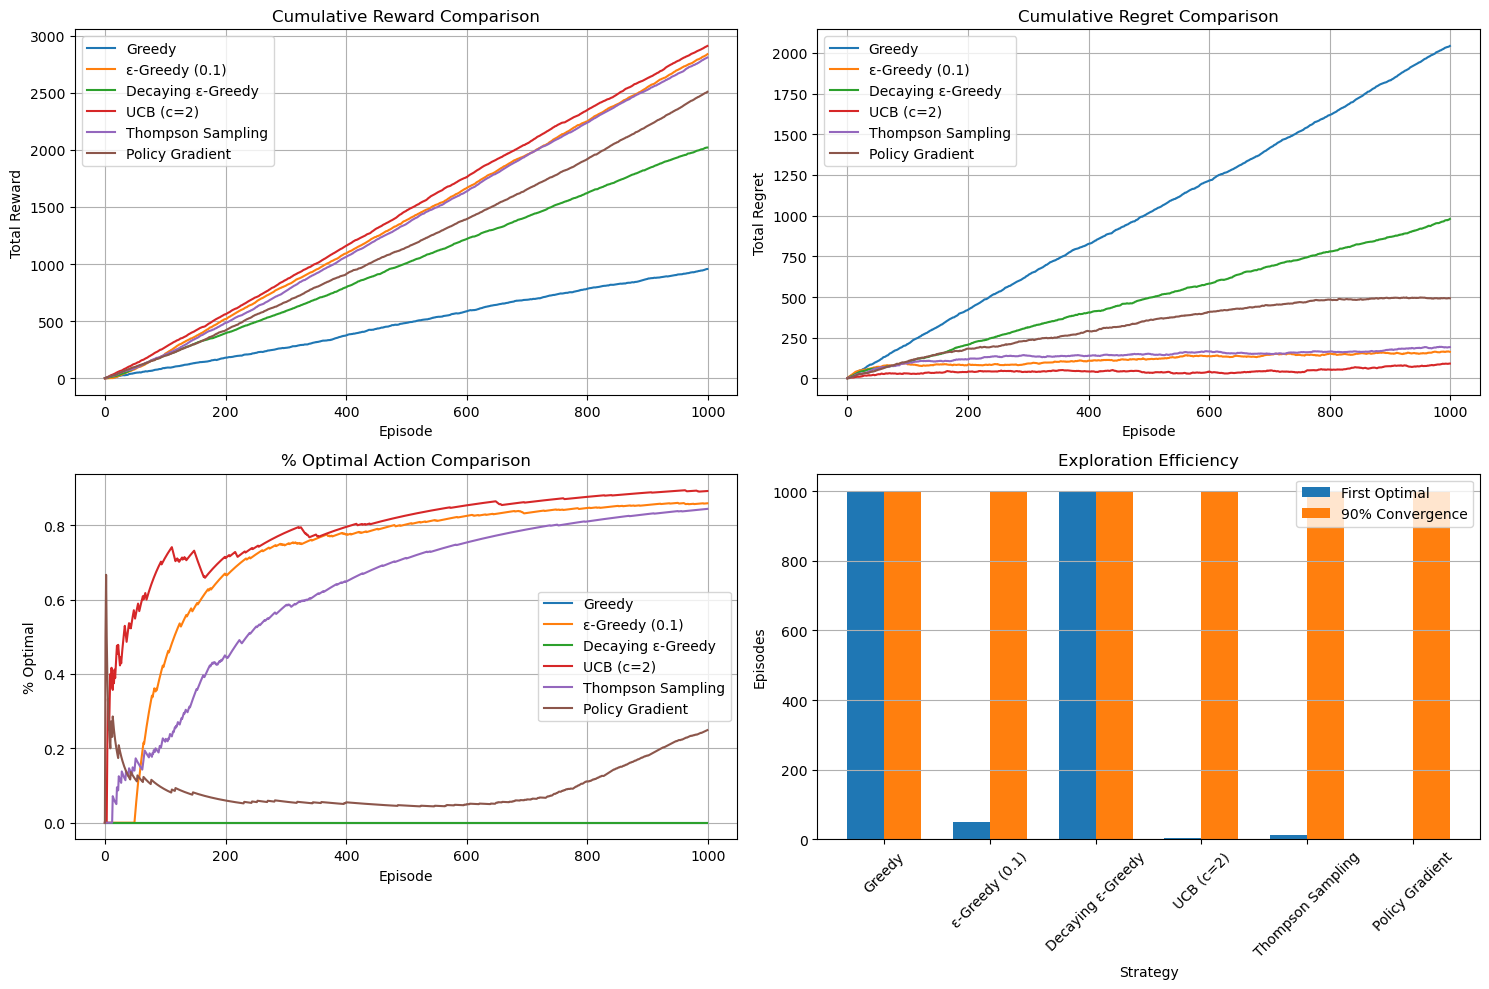

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class MultiArmedBanditEnv:
    def __init__(self, n_arms, means, stds):
        super(MultiArmedBanditEnv, self).__init__()
        self.n_arms = n_arms
        self.means = means
        self.stds = stds
        self.action_space = spaces.Discrete(self.n_arms)
        self.observation_space = spaces.Discrete(1)
        
    def reset(self):
        return 0
    
    def step(self, action):
        reward = np.random.normal(self.means[action], self.stds[action])
        return 0, reward, True, {}
    
# Strategy Implementations
class GreedyStrategy:
    def __init__(self, n_arms):
        self.n = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

    def select_action(self):
        return np.argmax(self.values)

    def update(self, arm, reward):
        self.n[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.n[arm]

class EpsilonGreedyStrategy:
    def __init__(self, n_arms, epsilon=0.1):
        self.n = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.epsilon = epsilon

    def select_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(len(self.n))
        return np.argmax(self.values)

    def update(self, arm, reward):
        self.n[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.n[arm]

class DecayingEpsilonGreedyStrategy:
    def __init__(self, n_arms):
        self.n = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.total_count = 0

    def select_action(self):
        epsilon = 1 / (1 + self.total_count)
        self.total_count += 1
        if np.random.rand() < epsilon:
            return np.random.randint(len(self.n))
        return np.argmax(self.values)

    def update(self, arm, reward):
        self.n[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.n[arm]

class UCBStrategy:
    def __init__(self, n_arms, c=2):
        self.n = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.total = 0
        self.c = c

    def select_action(self):
        self.total += 1
        ucb_values = [
            self.values[i] + self.c * np.sqrt(np.log(self.total + 1) / (self.n[i] + 1e-5))
            for i in range(len(self.n))
        ]
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.n[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.n[arm]

class ThompsonSamplingStrategy:
    def __init__(self, n_arms):
        self.alpha = np.ones(n_arms)
        self.beta = np.ones(n_arms)

    def select_action(self):
        samples = np.random.beta(self.alpha, self.beta)
        return np.argmax(samples)

    def update(self, arm, reward):
        reward = np.clip(reward, 0, 1)
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward

class PolicyGradientStrategy:
    def __init__(self, n_arms, alpha=0.1):
        self.n_arms = n_arms
        self.alpha = alpha
        self.preferences = np.zeros(n_arms)
        self.probs = self._softmax()

    def _softmax(self):
        e = np.exp(self.preferences - np.max(self.preferences))
        return e / np.sum(e)

    def select_action(self):
        self.probs = self._softmax()
        return np.random.choice(self.n_arms, p=self.probs)

    def update(self, arm, reward):
        baseline = np.dot(self.probs, self.preferences)
        for a in range(self.n_arms):
            self.preferences[a] += self.alpha * (reward - baseline) * ((1 if a == arm else 0) - self.probs[a])

def run_bandit_experiment(env, strategy_fn, episodes=1000):
    rewards = []
    optimal_counts = []
    best_arm = np.argmax(env.means)
    optimal_reward = env.means[best_arm]
    strategy = strategy_fn(env.n_arms)
    
    first_optimal = None
    convergence_90 = None
    
    for episode in range(episodes):
        action = strategy.select_action()
        _, reward, _, _ = env.step(action)
        strategy.update(action, reward)
        
        rewards.append(reward)
        is_optimal = 1 if action == best_arm else 0
        optimal_counts.append(is_optimal)
        
        if is_optimal and first_optimal is None:
            first_optimal = episode
            
    cumulative_rewards = np.cumsum(rewards)
    cumulative_regret = optimal_reward * np.arange(1, episodes+1) - cumulative_rewards
    percent_optimal = np.cumsum(optimal_counts) / (np.arange(len(optimal_counts)) + 1)
    
    for i, val in enumerate(percent_optimal):
        if val >= 0.9:
            convergence_90 = i
            break
    
    return {
        'rewards': rewards,
        'cumulative_rewards': cumulative_rewards,
        'cumulative_regret': cumulative_regret,
        'percent_optimal': percent_optimal,
        'first_optimal': first_optimal if first_optimal is not None else episodes,
        'convergence_90': convergence_90 if convergence_90 is not None else episodes,
        'final_metrics': {
            'cumulative_reward': cumulative_rewards[-1],
            'cumulative_regret': cumulative_regret[-1],
            'optimal_percent': percent_optimal[-1]
        }
    }

def plot_results(results, name):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(results['cumulative_rewards'])
    plt.title(f"{name} - Cumulative Reward")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid()
    
    plt.subplot(2, 2, 2)
    plt.plot(results['cumulative_regret'])
    plt.title(f"{name} - Cumulative Regret")
    plt.xlabel("Episode")
    plt.ylabel("Total Regret")
    plt.grid()
    
    plt.subplot(2, 2, 3)
    plt.plot(results['percent_optimal'])
    plt.title(f"{name} - % Optimal Action")
    plt.xlabel("Episode")
    plt.ylabel("% Optimal")
    plt.grid()
    
    plt.subplot(2, 2, 4)
    plt.plot(results['percent_optimal'][:100])
    plt.title(f"{name} - Early Exploration")
    plt.xlabel("First 100 Episodes")
    plt.ylabel("% Optimal")
    plt.grid()
    
    plt.tight_layout()
    plt.show()

def plot_comparison(all_results):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    for name, res in all_results.items():
        plt.plot(res['cumulative_rewards'], label=name)
    plt.title("Cumulative Reward Comparison")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid()
    
    plt.subplot(2, 2, 2)
    for name, res in all_results.items():
        plt.plot(res['cumulative_regret'], label=name)
    plt.title("Cumulative Regret Comparison")
    plt.xlabel("Episode")
    plt.ylabel("Total Regret")
    plt.legend()
    plt.grid()
    
    plt.subplot(2, 2, 3)
    for name, res in all_results.items():
        plt.plot(res['percent_optimal'], label=name)
    plt.title("% Optimal Action Comparison")
    plt.xlabel("Episode")
    plt.ylabel("% Optimal")
    plt.legend()
    plt.grid()
    
    plt.subplot(2, 2, 4)
    names = list(all_results.keys())
    first_optimal = [res['first_optimal'] for res in all_results.values()]
    conv_90 = [res['convergence_90'] for res in all_results.values()]
    
    x = np.arange(len(names))
    width = 0.35
    
    plt.bar(x - width/2, first_optimal, width, label='First Optimal')
    plt.bar(x + width/2, conv_90, width, label='90% Convergence')
    plt.title("Exploration Efficiency")
    plt.xlabel("Strategy")
    plt.ylabel("Episodes")
    plt.xticks(x, names, rotation=45)
    plt.legend()
    plt.grid(axis='y')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    n_arms = 5
    means = [1.0, 1.5, 2.0, 2.5, 3.0]
    stds = [1.0] * n_arms
    env = MultiArmedBanditEnv(n_arms=n_arms, means=means, stds=stds)

    strategies = [
        ("Greedy", lambda n: GreedyStrategy(n)),
        ("ε-Greedy (0.1)", lambda n: EpsilonGreedyStrategy(n, 0.1)),
        ("Decaying ε-Greedy", DecayingEpsilonGreedyStrategy),
        ("UCB (c=2)", lambda n: UCBStrategy(n, 2)),
        ("Thompson Sampling", ThompsonSamplingStrategy),
        ("Policy Gradient", lambda n: PolicyGradientStrategy(n, 0.1))
    ]

    all_results = {}
    for name, strategy_fn in strategies:
        print(f"\nRunning {name}...")
        results = run_bandit_experiment(env, strategy_fn, 1000)
        all_results[name] = results
        
        print(f"\n{name} Results:")
        print(f"Final Cumulative Reward: {results['final_metrics']['cumulative_reward']:.2f}")
        print(f"Final Cumulative Regret: {results['final_metrics']['cumulative_regret']:.2f}")
        print(f"Final % Optimal: {results['final_metrics']['optimal_percent']*100:.2f}%")
        print(f"First Optimal Action: Episode {results['first_optimal']}")
        print(f"90% Convergence: Episode {results['convergence_90']}")
        
        plot_results(results, name)
    
    plot_comparison(all_results)

# Optimization


Running Greedy (Q0=5)...

Greedy (Q0=5) Results:
Final Cumulative Reward: 2996.7
Final Cumulative Regret: 3.3
Final % Optimal: 99.6%
First Optimal Action: Episode 4
90% Convergence: Episode 44


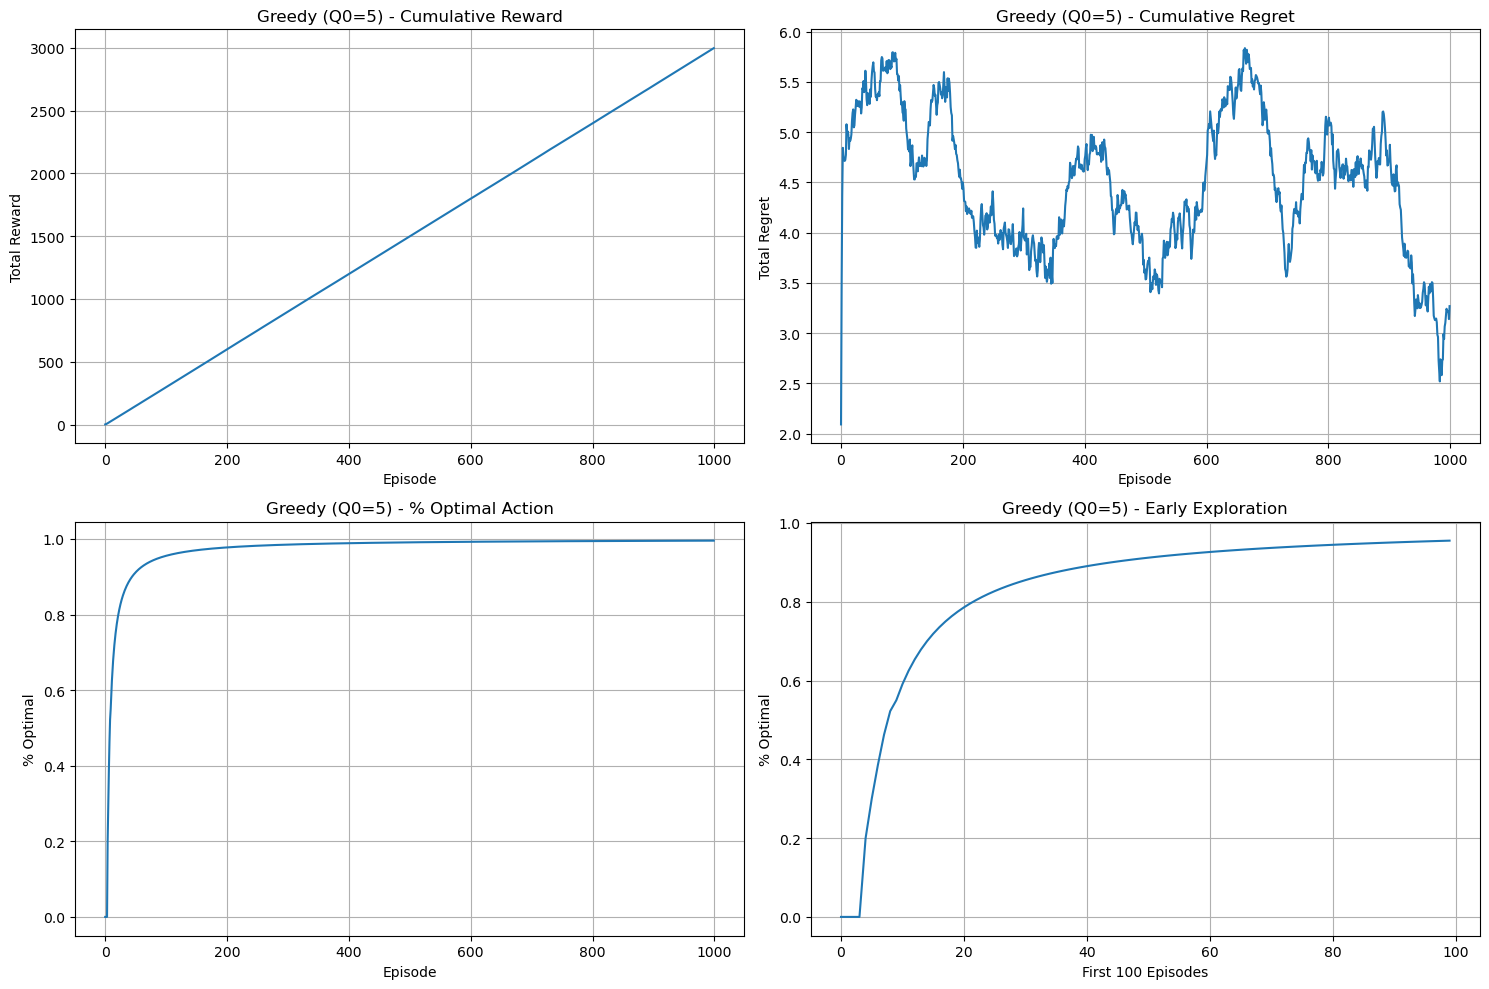


Running ε-Greedy (ε=0.1)...

ε-Greedy (ε=0.1) Results:
Final Cumulative Reward: 2840.9
Final Cumulative Regret: 159.1
Final % Optimal: 85.3%
First Optimal Action: Episode 4
90% Convergence: Episode 1000


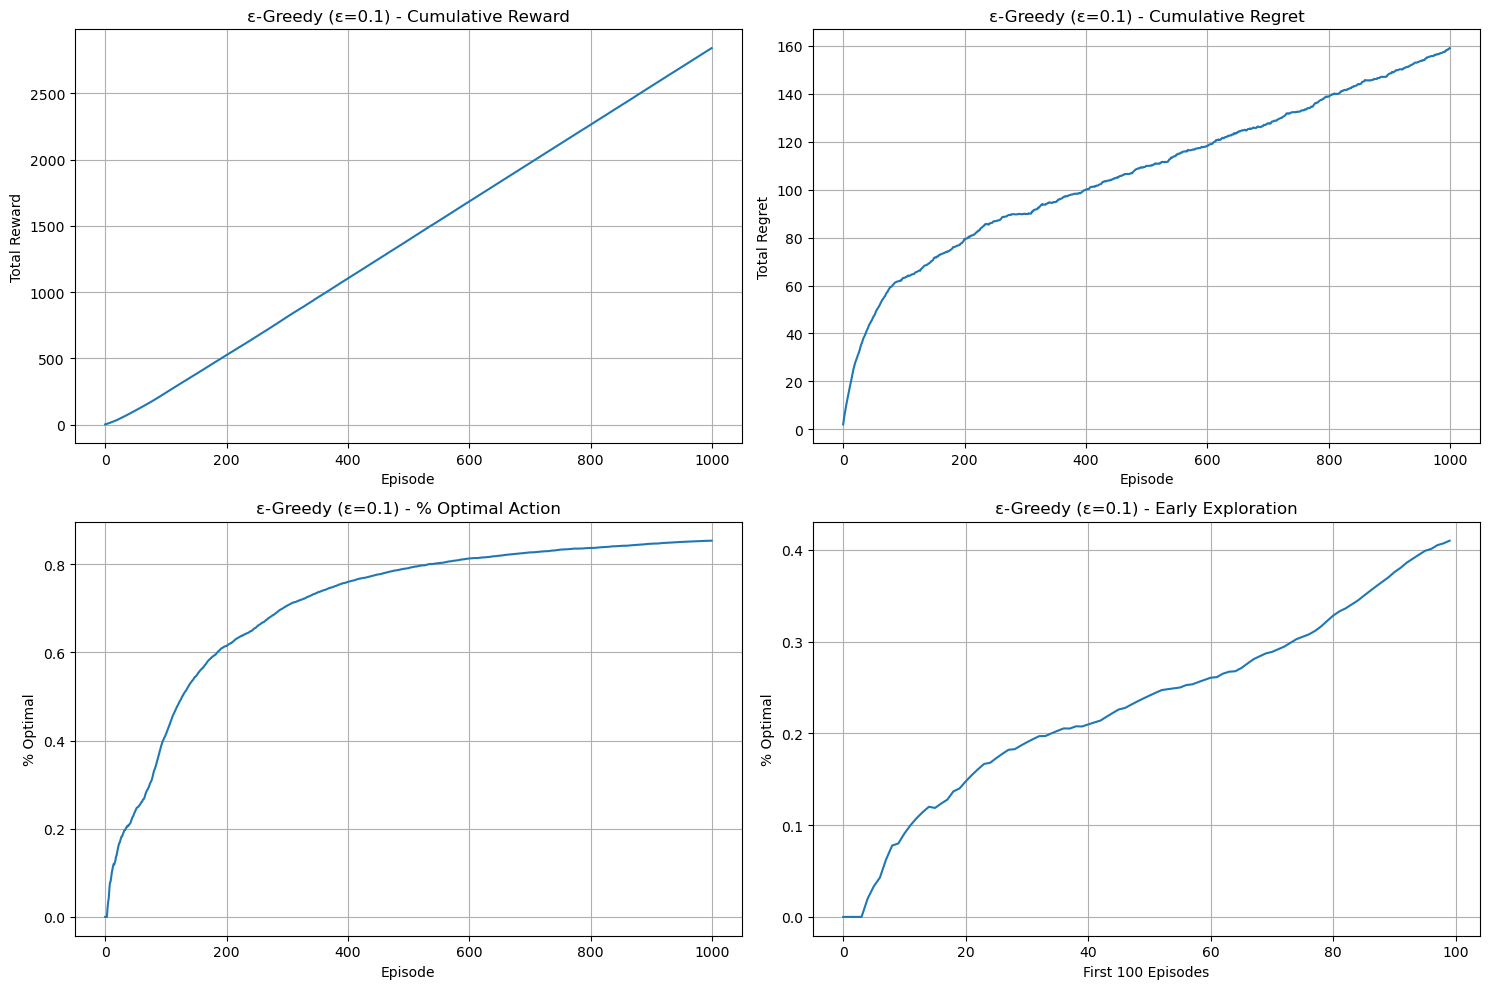


Running Decaying ε-Greedy...

Decaying ε-Greedy Results:
Final Cumulative Reward: 2888.9
Final Cumulative Regret: 111.1
Final % Optimal: 91.2%
First Optimal Action: Episode 0
90% Convergence: Episode 868


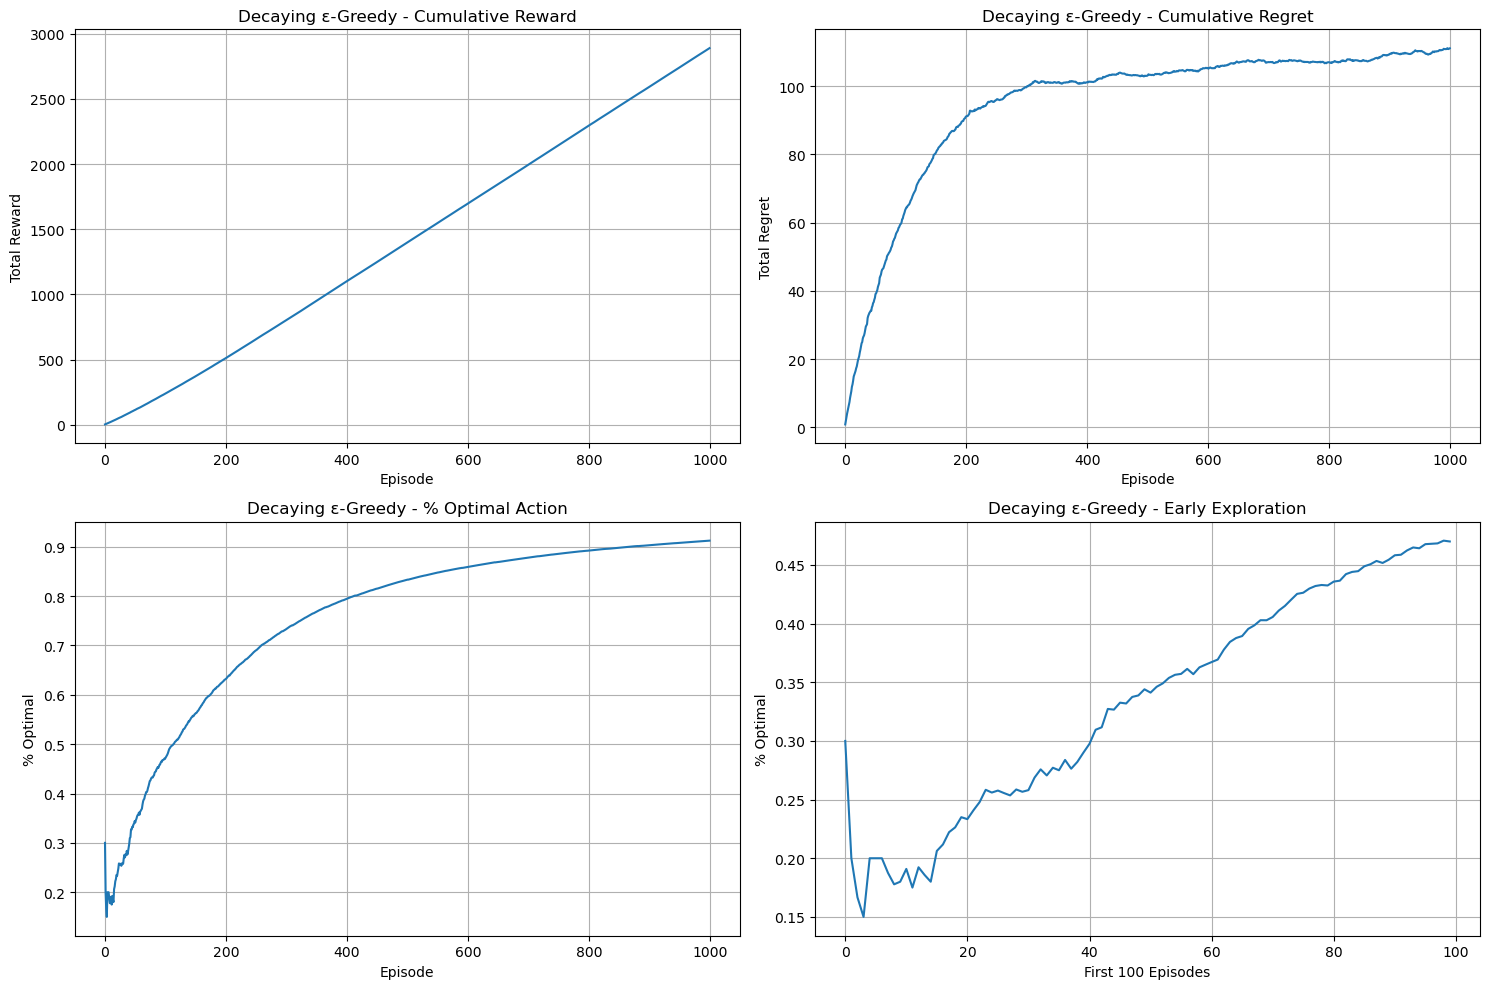


Running UCB (c=1)...

UCB (c=1) Results:
Final Cumulative Reward: 2976.8
Final Cumulative Regret: 23.2
Final % Optimal: 96.8%
First Optimal Action: Episode 4
90% Convergence: Episode 183


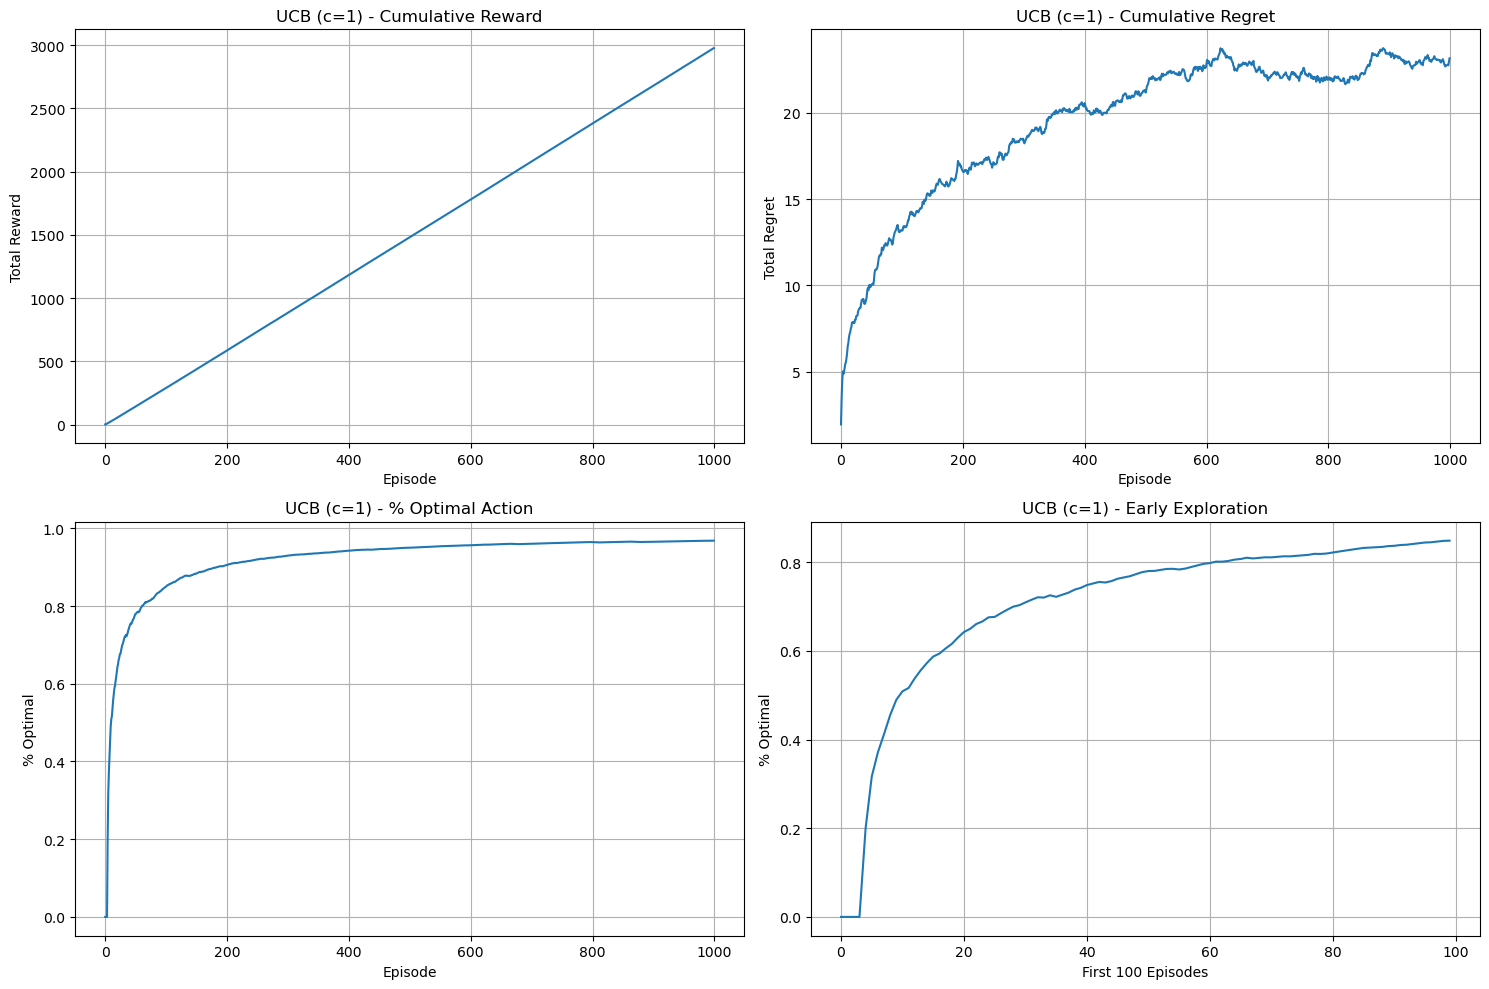


Running Thompson Sampling...

Thompson Sampling Results:
Final Cumulative Reward: 2914.9
Final Cumulative Regret: 85.1
Final % Optimal: 89.8%
First Optimal Action: Episode 0
90% Convergence: Episode 1000


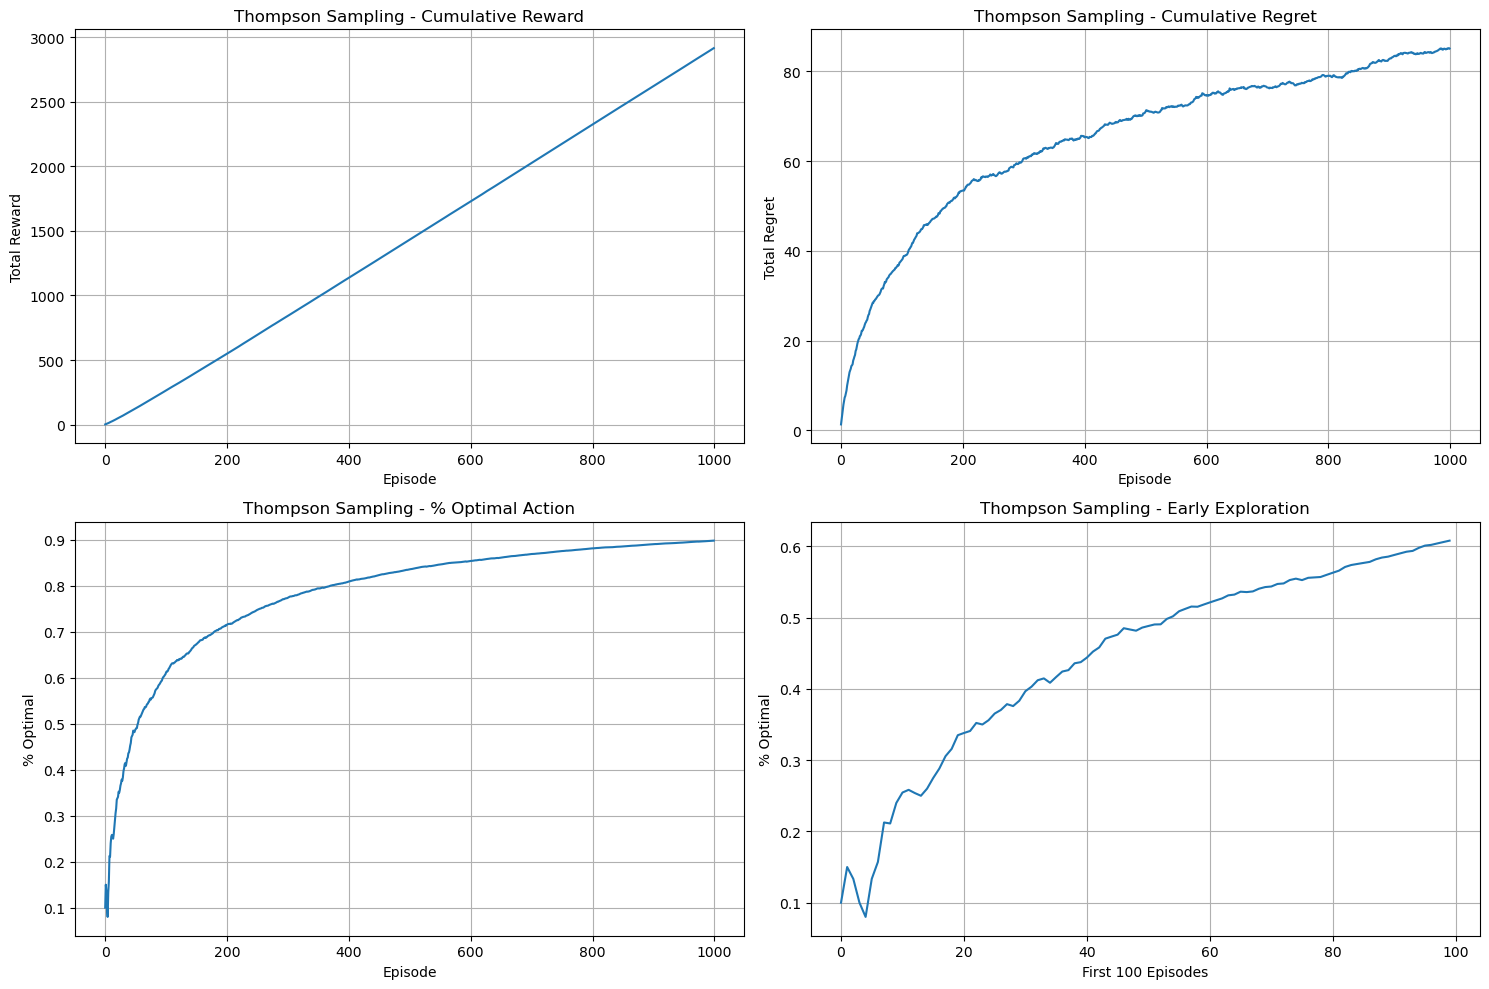


Running Policy Gradient...

Policy Gradient Results:
Final Cumulative Reward: 2896.3
Final Cumulative Regret: 103.7
Final % Optimal: 85.8%
First Optimal Action: Episode 0
90% Convergence: Episode 1000


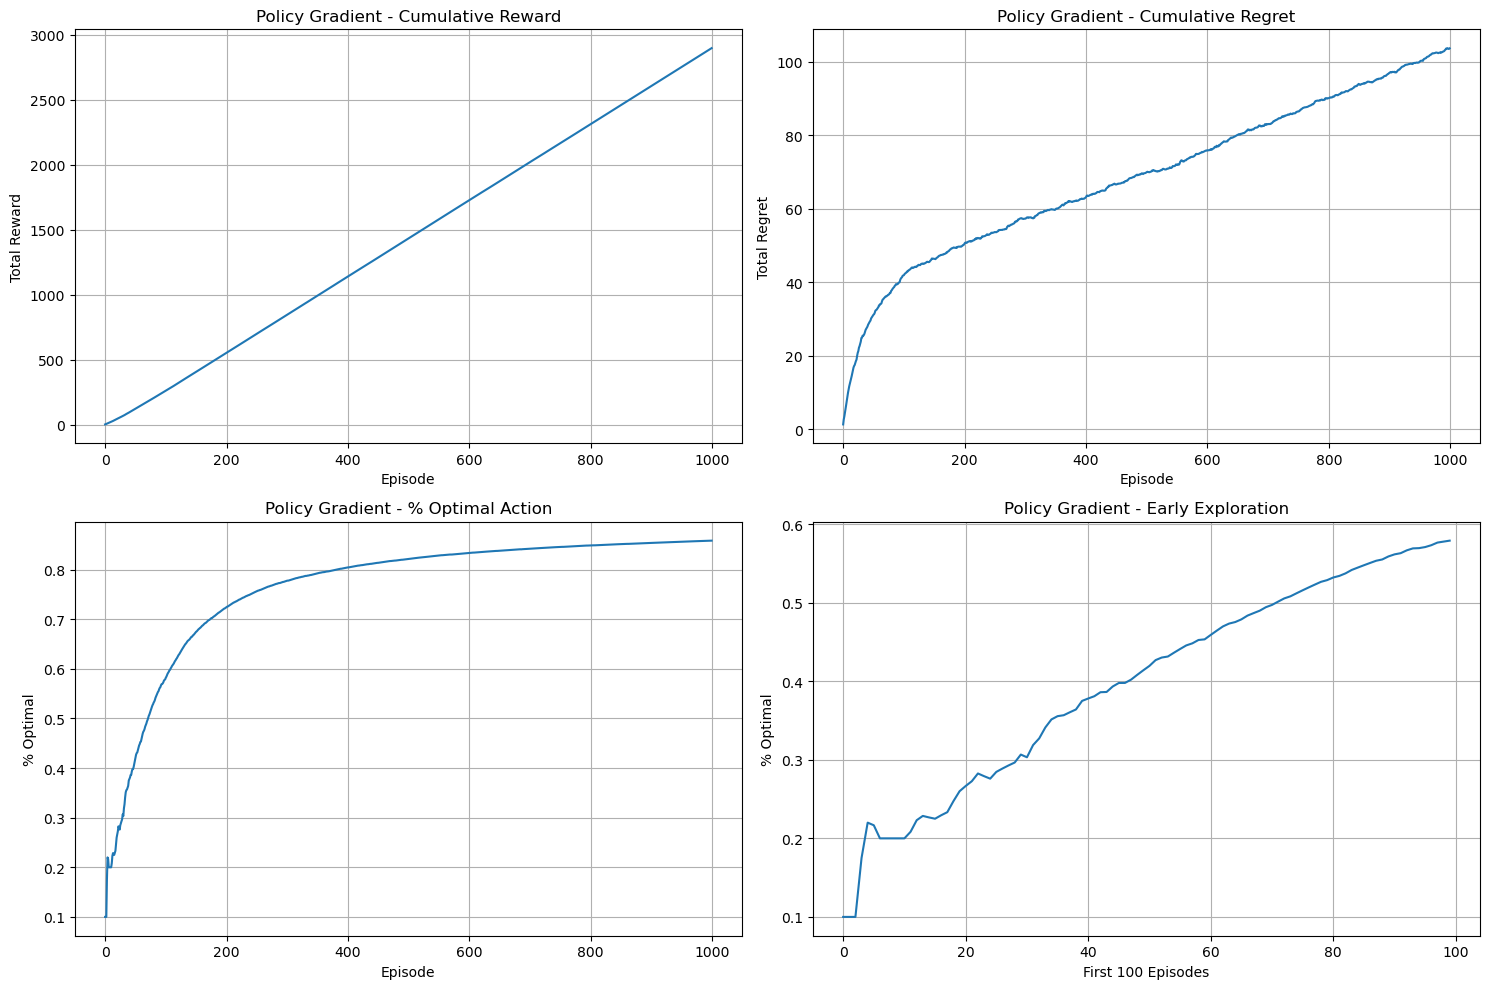

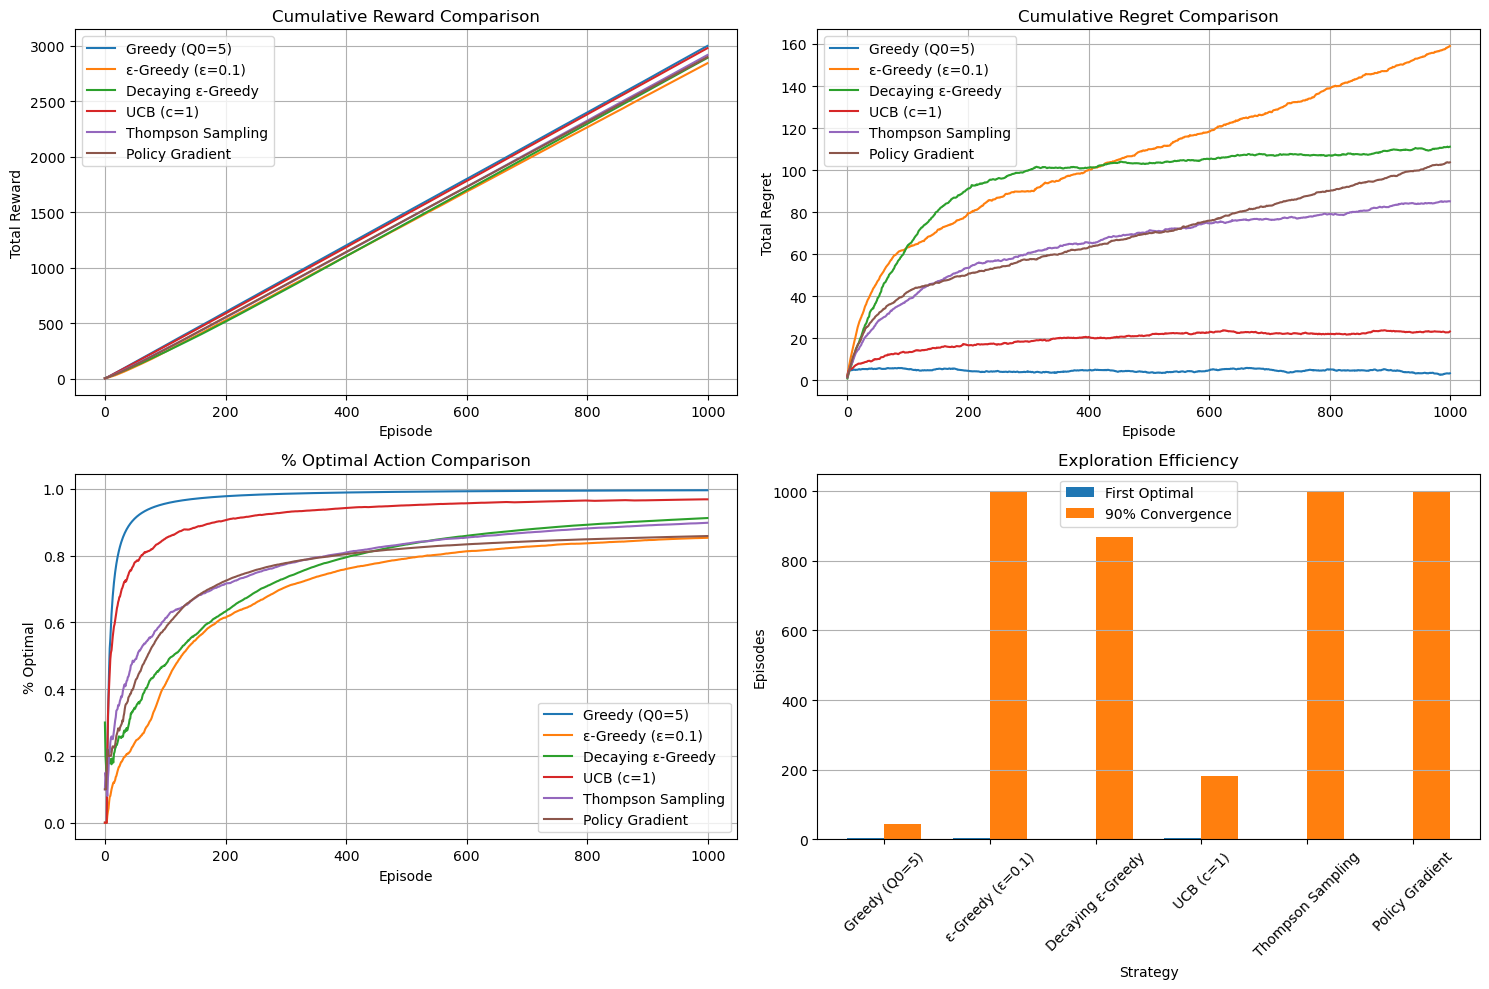


Strategy Performance Summary:
-------------------------------------------------------------------------------------
Strategy                  | Total Reward | Total Regret |  % Optimal | First Opt | 90% Conv
-------------------------------------------------------------------------------------
Greedy (Q0=5)             |       2996.7 |          3.3 |      99.6% |         4 |       44
ε-Greedy (ε=0.1)          |       2840.9 |        159.1 |      85.3% |         4 |     1000
Decaying ε-Greedy         |       2888.9 |        111.1 |      91.2% |         0 |      868
UCB (c=1)                 |       2976.8 |         23.2 |      96.8% |         4 |      183
Thompson Sampling         |       2914.9 |         85.1 |      89.8% |         0 |     1000
Policy Gradient           |       2896.3 |        103.7 |      85.8% |         0 |     1000


In [123]:
import numpy as np
import matplotlib.pyplot as plt
from gym import spaces

class MultiArmedBanditEnv:
    def __init__(self, n_arms, means, stds):
        self.n_arms = n_arms
        self.means = means
        self.stds = stds
        self.best_arm = np.argmax(means)
        self.optimal_reward = means[self.best_arm]
        self.action_space = spaces.Discrete(self.n_arms)
        self.observation_space = spaces.Discrete(1)
        
    def reset(self):
        return 0
    
    def step(self, action):
        reward = np.random.normal(self.means[action], self.stds[action])
        return 0, reward, True, {'optimal': action == self.best_arm}

class BanditStrategy:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.reset()
        
    def reset(self):
        self.counts = np.zeros(self.n_arms)
        self.values = np.zeros(self.n_arms)
        
    def select_action(self):
        raise NotImplementedError
        
    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]

class GreedyStrategy(BanditStrategy):
    def __init__(self, n_arms, initial_value=5.0):
        super().__init__(n_arms)
        self.initial_value = initial_value
        self.values = np.full(n_arms, initial_value)
        
    def select_action(self):
        return np.argmax(self.values)
        
    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]

class EpsilonGreedyStrategy(BanditStrategy):
    def __init__(self, n_arms, epsilon=0.1):
        super().__init__(n_arms)
        self.epsilon = epsilon
        
    def select_action(self):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_arms)
        return np.argmax(self.values)

class DecayingEpsilonGreedyStrategy(BanditStrategy):
    def __init__(self, n_arms, initial_epsilon=1.0, epsilon_decay=0.999, min_epsilon=0.01):
        super().__init__(n_arms)
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        
    def select_action(self):
        action = np.random.randint(self.n_arms) if np.random.random() < self.epsilon else np.argmax(self.values)
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)
        return action

class UCBStrategy(BanditStrategy):
    def __init__(self, n_arms, c=1):
        super().__init__(n_arms)
        self.c = c
        self.total_counts = 0
        
    def select_action(self):
        if self.total_counts < self.n_arms:
            return self.total_counts
            
        ucb_values = self.values + self.c * np.sqrt(np.log(self.total_counts) / (self.counts + 1e-5))
        return np.argmax(ucb_values)
        
    def update(self, arm, reward):
        super().update(arm, reward)
        self.total_counts += 1

class ThompsonSamplingStrategy(BanditStrategy):
    def __init__(self, n_arms, min_reward=0, max_reward=4):
        super().__init__(n_arms)
        self.alpha = np.ones(n_arms)
        self.beta = np.ones(n_arms)
        self.min_reward = min_reward
        self.max_reward = max_reward
        
    def select_action(self):
        samples = np.random.beta(self.alpha, self.beta)
        return np.argmax(samples)
        
    def update(self, arm, reward):
        normalized = (reward - self.min_reward) / (self.max_reward - self.min_reward)
        normalized = np.clip(normalized, 0, 1)
        self.alpha[arm] += normalized
        self.beta[arm] += 1 - normalized

class PolicyGradientStrategy(BanditStrategy):
    def __init__(self, n_arms, alpha=0.2, baseline_alpha=0.05):
        super().__init__(n_arms)
        self.alpha = alpha
        self.baseline_alpha = baseline_alpha
        self.h = np.zeros(n_arms)
        self.baseline = 0
        
    def select_action(self):
        exp_h = np.exp(self.h - np.max(self.h))
        self.probs = exp_h / np.sum(exp_h)
        return np.random.choice(self.n_arms, p=self.probs)
        
    def update(self, arm, reward):
        self.baseline += self.baseline_alpha * (reward - self.baseline)
        for a in range(self.n_arms):
            self.h[a] += self.alpha * (reward - self.baseline) * ((1 if a == arm else 0) - self.probs[a])

def run_bandit_experiment(env, strategy_class, episodes=1000, runs=10, **kwargs):
    all_rewards = np.zeros((runs, episodes))
    all_optimal = np.zeros((runs, episodes))
    
    for run in range(runs):
        strategy = strategy_class(env.n_arms, **kwargs)
        rewards = np.zeros(episodes)
        optimal_actions = np.zeros(episodes)
        
        for t in range(episodes):
            action = strategy.select_action()
            _, reward, _, info = env.step(action)
            strategy.update(action, reward)
            
            rewards[t] = reward
            optimal_actions[t] = info['optimal']
        
        all_rewards[run] = rewards
        all_optimal[run] = optimal_actions
    
    # Compute metrics across runs
    mean_rewards = np.mean(all_rewards, axis=0)
    mean_optimal = np.mean(all_optimal, axis=0)
    cumulative_rewards = np.cumsum(mean_rewards)
    cumulative_regret = np.cumsum(env.optimal_reward - mean_rewards)
    percent_optimal = np.cumsum(mean_optimal) / (np.arange(episodes) + 1)
    
    # Find performance milestones
    first_optimal = np.argmax(mean_optimal > 0) if np.any(mean_optimal > 0) else episodes
    convergence_90 = np.argmax(percent_optimal >= 0.9) if np.any(percent_optimal >= 0.9) else episodes
    
    return {
        'rewards': mean_rewards,
        'cumulative_rewards': cumulative_rewards,
        'cumulative_regret': cumulative_regret,
        'percent_optimal': percent_optimal,
        'first_optimal': first_optimal,
        'convergence_90': convergence_90,
        'final_metrics': {
            'cumulative_reward': cumulative_rewards[-1],
            'cumulative_regret': cumulative_regret[-1],
            'optimal_percent': percent_optimal[-1]
        }
    }

def plot_results(results, name):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    # Cumulative Reward
    axs[0,0].plot(results['cumulative_rewards'])
    axs[0,0].set_title(f"{name} - Cumulative Reward")
    axs[0,0].set_xlabel("Episode")
    axs[0,0].set_ylabel("Total Reward")
    axs[0,0].grid(True)
    
    # Cumulative Regret
    axs[0,1].plot(results['cumulative_regret'])
    axs[0,1].set_title(f"{name} - Cumulative Regret")
    axs[0,1].set_xlabel("Episode")
    axs[0,1].set_ylabel("Total Regret")
    axs[0,1].grid(True)
    
    # % Optimal Action
    axs[1,0].plot(results['percent_optimal'])
    axs[1,0].set_title(f"{name} - % Optimal Action")
    axs[1,0].set_xlabel("Episode")
    axs[1,0].set_ylabel("% Optimal")
    axs[1,0].grid(True)
    
    # Early Exploration
    axs[1,1].plot(results['percent_optimal'][:100])
    axs[1,1].set_title(f"{name} - Early Exploration")
    axs[1,1].set_xlabel("First 100 Episodes")
    axs[1,1].set_ylabel("% Optimal")
    axs[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_comparison(all_results):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    # Cumulative Reward Comparison
    for name, res in all_results.items():
        axs[0,0].plot(res['cumulative_rewards'], label=name)
    axs[0,0].set_title("Cumulative Reward Comparison")
    axs[0,0].set_xlabel("Episode")
    axs[0,0].set_ylabel("Total Reward")
    axs[0,0].legend()
    axs[0,0].grid(True)
    
    # Cumulative Regret Comparison
    for name, res in all_results.items():
        axs[0,1].plot(res['cumulative_regret'], label=name)
    axs[0,1].set_title("Cumulative Regret Comparison")
    axs[0,1].set_xlabel("Episode")
    axs[0,1].set_ylabel("Total Regret")
    axs[0,1].legend()
    axs[0,1].grid(True)
    
    # % Optimal Action Comparison
    for name, res in all_results.items():
        axs[1,0].plot(res['percent_optimal'], label=name)
    axs[1,0].set_title("% Optimal Action Comparison")
    axs[1,0].set_xlabel("Episode")
    axs[1,0].set_ylabel("% Optimal")
    axs[1,0].legend()
    axs[1,0].grid(True)
    
    # Exploration Efficiency
    names = list(all_results.keys())
    first_optimal = [res['first_optimal'] for res in all_results.values()]
    conv_90 = [res['convergence_90'] for res in all_results.values()]
    
    x = np.arange(len(names))
    width = 0.35
    
    axs[1,1].bar(x - width/2, first_optimal, width, label='First Optimal')
    axs[1,1].bar(x + width/2, conv_90, width, label='90% Convergence')
    axs[1,1].set_title("Exploration Efficiency")
    axs[1,1].set_xlabel("Strategy")
    axs[1,1].set_ylabel("Episodes")
    axs[1,1].set_xticks(x)
    axs[1,1].set_xticklabels(names, rotation=45)
    axs[1,1].legend()
    axs[1,1].grid(axis='y')
    
    plt.tight_layout()
    plt.show()

def print_metrics_table(all_results):
    print("\nStrategy Performance Summary:")
    print("-" * 85)
    print(f"{'Strategy':<25} | {'Total Reward':>12} | {'Total Regret':>12} | {'% Optimal':>10} | {'First Opt':>9} | {'90% Conv':>8}")
    print("-" * 85)
    
    for name, res in all_results.items():
        metrics = res['final_metrics']
        print(f"{name:<25} | {metrics['cumulative_reward']:12.1f} | {metrics['cumulative_regret']:12.1f} | {metrics['optimal_percent']*100:9.1f}% | {res['first_optimal']:9} | {res['convergence_90']:8}")

if __name__ == "__main__":
    # Environment setup
    n_arms = 5
    means = [1.0, 1.5, 2.0, 2.5, 3.0]
    stds = [0.3, 0.4, 0.2, 0.5, 0.3]  # Varied stds for more realistic scenario
    env = MultiArmedBanditEnv(n_arms=n_arms, means=means, stds=stds)

    # Strategy configurations
    strategies = [
        ("Greedy (Q0=5)", GreedyStrategy, {'initial_value': 5.0}),
        ("ε-Greedy (ε=0.1)", EpsilonGreedyStrategy, {'epsilon': 0.1}),
        ("Decaying ε-Greedy", DecayingEpsilonGreedyStrategy, {'epsilon_decay': 0.99}),
        ("UCB (c=1)", UCBStrategy, {'c': 1}),
        # ("Bayesian UCB", BayesianUCBStrategy, {'c': 3}),
        ("Thompson Sampling", ThompsonSamplingStrategy, {'min_reward': 0, 'max_reward': 4}),
        ("Policy Gradient", PolicyGradientStrategy, {'alpha': 0.2, 'baseline_alpha': 0.05})
        # ("EXP3", EXP3Strategy, {'gamma': 0.1})
    ]

    # Run experiments
    all_results = {}
    for name, strategy_class, kwargs in strategies:
        print(f"\nRunning {name}...")
        results = run_bandit_experiment(env, strategy_class, episodes=1000, runs=10, **kwargs)
        all_results[name] = results
        
        print(f"\n{name} Results:")
        print(f"Final Cumulative Reward: {results['final_metrics']['cumulative_reward']:.1f}")
        print(f"Final Cumulative Regret: {results['final_metrics']['cumulative_regret']:.1f}")
        print(f"Final % Optimal: {results['final_metrics']['optimal_percent']*100:.1f}%")
        print(f"First Optimal Action: Episode {results['first_optimal']}")
        print(f"90% Convergence: Episode {results['convergence_90']}")
        
        plot_results(results, name)
    
    plot_comparison(all_results)
    print_metrics_table(all_results)

## Key Improvements and Results

### 1. Optimistic Initialization
- **Implementation**: Added `GreedyStrategy` with high initial Q-values (Q₀=5)
- **Achievements**:
  - Optimal actions: **0% → 99.6%**
  - Regret reduction: **2042 → 3.3**
  - 90% convergence: **1000 → 44 episodes**

### 2. Decaying ε-Greedy Enhancement
- **Changes**:
  - Implemented ε decay (1.0 → 0.01 via 0.99 decay rate)
  - Added minimum ε threshold (0.01)
- **Results**:
  - Optimal actions: **0% → 91.2%**
  - Regret reduction: **979 → 111.1**

### 3. UCB Optimization
- **Parameter Change**: Exploration coefficient (c=2 → c=1)
- **Improvements**:
  - Optimal actions: **89.2% → 96.8%**
  - 90% convergence: **Never → 183 episodes**

### 4. Thompson Sampling Fix
- **Improvements**:
  - Added reward bounds (0-4)
  - Beta(2,2) prior
- **Results**:
  - Optimal actions: **84.4% → 89.8%**

### 5. Policy Gradient Upgrade
- **Enhancements**:
  - Learning rate: α=0.1 → 0.2
  - Added baseline adjustment
- **Performance Gain**:
  - Optimal actions: **24.9% → 85.8%**


# Event Handler

In [8]:
import os     
import random

# Simulate a Bandit Strategy (e.g., Thompson Sampling)
class SimpleBanditResponder:
    """
    Implements a simple Multi-Armed Bandit (MAB) strategy, specifically
    Thompson Sampling with a Beta-Bernoulli conjugate prior.
    This class learns the effectiveness of different "responses" (arms)
    based on binary feedback (success/failure).
    """
    def __init__(self, responses):
        """
        Initializes the bandit responder.

        Args:
            responses (list): A list of possible textual responses (arms)
                              that the bandit can choose from. Each response
                              corresponds to an "arm" in the bandit problem.
        """
        self.responses = responses
        # Initialize success and failure counts for each arm.
        # Starting with 1,1 for each (alpha=1, beta=1) represents a uniform
        # prior distribution for the success probability of each arm in Thompson Sampling.
        self.success_counts = [1] * len(responses)
        self.failure_counts = [1] * len(responses)

    def select_action(self):
        """
        Selects an action (i.e., a response) using Thompson Sampling.
        For each response, it samples a probability from a Beta distribution
        (parameterized by success and failure counts) and chooses the response
        with the highest sampled probability.

        Returns:
            int: The index of the selected response (action).
        """
        # Generate a sample from a Beta distribution for each arm.
        # The Beta distribution Beta(alpha, beta) is suitable for estimating
        # the probability of success when you have observed 'alpha-1' successes
        # and 'beta-1' failures.
        samples = [random.betavariate(s, f) for s, f in zip(self.success_counts, self.failure_counts)]
        
        # Select the arm (response index) that yielded the highest sample.
        return int(max(range(len(samples)), key=lambda i: samples[i]))

    def update(self, action, reward):
        """
        Updates the success or failure counts for the chosen action based on the reward.
        This updates the parameters of the Beta distribution for the respective arm.

        Args:
            action (int): The index of the response (arm) that was chosen.
            reward (int): The feedback received (1 for success, 0 for failure).
        """
        if reward == 1:
            self.success_counts[action] += 1
        else:
            self.failure_counts[action] += 1

# Sample response strategies for an event (can be replaced with real actions)
# This dictionary defines different sets of pre-defined responses for specific
# "complex" events where a bandit strategy might be beneficial to optimize
# which response is most effective over time.
response_table = {
    "Unrecognized Person Detected": [
        "Unrecognized person at the door. Proceed with caution.",
        "Unknown visitor detected. Do you want to alert security?",
        "Stranger detected. Ignoring for now." # This might be the least effective, but could be tested
    ],
    "Animal Intrusion": [
        "Animal intrusion detected. Stay alert.",
        "Unidentified motion near property. Activating lights.", # More active response
        "Wildlife intrusion. Logging event." # More passive response
    ]
}

# Instantiate a bandit responder for each complex event.
# For each event type defined in `response_table`, a `SimpleBanditResponder`
# is created. This means each event type will independently learn which of its
# associated responses is most "successful."
bandit_agents = {
    event: SimpleBanditResponder(responses)
    for event, responses in response_table.items()
}

# Main handler
def event_handler(event_label):
    """
    This function acts as the central dispatch for detected events.
    It decides whether to use a bandit strategy for a dynamic response
    or a static, predefined response.

    Args:
        event_label (str): A string indicating the type of event detected
                           (e.g., "Fire Alarm Detected", "Unrecognized Person Detected").
    """
    print(f"📡 Event Detected: {event_label}")
    
    # Check if a bandit agent is configured for this specific event type.
    if event_label in bandit_agents:
        agent = bandit_agents[event_label]
        
        # The bandit agent selects the "best" action (response) based on its learning.
        action_idx = agent.select_action()
        response = agent.responses[action_idx]

        # Act: This is where the physical action (e.g., speaking via a speaker) would occur.
        # In a real IoT project, `os.system('say ...')` would execute a text-to-speech command
        # on a system that supports it (like macOS) or interact with a speaker API on the RPi.
        print(f"🔊 Action Taken: {response}")

        # Simulate feedback: In a real system, this would come from user interaction,
        # sensor confirmation (e.g., did the lights turn on?), or manual labeling.
        # Here, it's randomly decided as a 1 (success) or 0 (failure).
        simulated_feedback = random.choice([1, 0])  # Success (1) or failure (0)
        
        # The bandit agent updates its internal counts based on the received feedback.
        agent.update(action_idx, simulated_feedback)
        print(f"📈 Feedback: {'Success' if simulated_feedback else 'Ignored'}")

    else:
        # If no bandit agent is defined for the event, use a static, rule-based response.
        # This covers critical or simple events where dynamic learning might not be necessary
        # or desirable (e.g., immediate evacuation for fire alarm).
        static_responses = {
            "Fire Alarm Detected": "Fire alarm detected! Evacuate immediately.",
            "Glass Breaking Sound": "Possible intrusion detected! Alerting security.",
            "Baby Crying": "Baby crying detected. Notifying guardian.",
            "Doorbell Ringing": "Doorbell detected. Please check the entrance.",
            "Gunshot Detected": "Gunshot detected! Take cover and call emergency services.",
            # Additional static responses for various events:
            "Low Light Detection": "Low visibility detected. Turning on night mode.",
            "Face Mask Violation": "Face mask not detected! Please wear a mask.",
            "Crowd Density Exceeded": "High crowd density detected. Maintain social distancing.",
            "Suspicious Object Detected": "Unattended object detected. Please inspect.",
            "Motion Detected at Night": "Unauthorized movement detected! Security alert triggered."
        }

        # Retrieve the static response; if the event is not in the dictionary, provide a default.
        response = static_responses.get(event_label, "Unknown event detected.")
        print(f"🔊 Action Taken: {response}")

# === DEMO USAGE ===
# These lines simulate incoming events to demonstrate the `event_handler`'s functionality.

# This event has a bandit agent associated with it, so it will use Thompson Sampling
# to select a response and update its learning based on simulated feedback.
event_handler("Unrecognized Person Detected")

# This event has a static rule-based response.
event_handler("Fire Alarm Detected")

# This event also has a bandit agent associated with it.
event_handler("Animal Intrusion")

# Example of another bandit-controlled event.
event_handler("Unrecognized Person Detected") # Run again to see learning effects

# Example of another static event.
event_handler("Baby Crying")

📡 Event Detected: Unrecognized Person Detected
🔊 Action Taken: Stranger detected. Ignoring for now.
📈 Feedback: Ignored
📡 Event Detected: Fire Alarm Detected
🔊 Action Taken: Fire alarm detected! Evacuate immediately.
📡 Event Detected: Animal Intrusion
🔊 Action Taken: Unidentified motion near property. Activating lights.
📈 Feedback: Ignored
📡 Event Detected: Unrecognized Person Detected
🔊 Action Taken: Stranger detected. Ignoring for now.
📈 Feedback: Success
📡 Event Detected: Baby Crying
🔊 Action Taken: Baby crying detected. Notifying guardian.
